In [31]:
'pause,dock,docking,pause'.find('clean')

-1

In [32]:
import pandas as pd
df=pd.read_csv('./Downloads/All_mission_results.csv',nrows=200000)


In [33]:
df['EVENTSEQ'][1]

'Entered Clean Mode,Told to Clean,Entered Paused Mode,GET_Error_Code,Entered Paused Mode,RunTimeCycle,Error = 0,Entered Dock Mode,Contacted Charging Dock,Entered Dock Mode,Lost Charging Contact,Entered Paused Mode'

In [36]:
df['pause']=df['EVENTSEQ'].apply(lambda x:str(x).find('Paused'))
df['dock']=df['EVENTSEQ'].apply(lambda x:str(x).find('Dock'))
    

In [43]:
df[['EVENTSEQ','pause','dock']]

EVENTSEQ  pause  dock
0       Entered Clean Mode,Entered Dock Mode,RunTimeCy...     94    27
1       Entered Clean Mode,Told to Clean,Entered Pause...     41   119
2       Entered Clean Mode,Lost Charging Contact,Enter...     49    -1
3       Entered Clean Mode,Entered Dock Mode,RunTimeCy...    136    27
4       Entered Clean Mode,RunTimeCumulative,GET_Error...     60    -1
...                                                   ...    ...   ...
199995  Entered Clean Mode,Lost Charging Contact,Enter...     -1    49
199996  Entered Clean Mode,Entered Dock Mode,RunTimeCy...     -1    27
199997  Entered Clean Mode,Told to Clean,Entered Pause...     41    -1
199998  Entered Clean Mode,Entered Paused Mode,RunTime...     27    78
199999  Entered Clean Mode,Entered Paused Mode,RunTime...     27    -1

[200000 rows x 3 columns]

In [141]:
import csv

import pandas as pd
import numpy as np

chunk_list=[]
for chunk in pd.read_csv('./Downloads/All_mission_results.csv', chunksize=200000):
    chunk=chunk[[ 'CREATED_AT_REAL', 
        'OEM_MODEL', 'DSN', 'RUNS', 'LASTEVENT',
       'JOBSTART', 'JOB',  'ENTERED_DOCK_MODE',
       'CONTACTED_CHARGING_DOCK', 'GET_CLEANING_STATISTICS', 'RUNTIMECYCLE',
       'RUNTIMECUMULATIVE',  'TIME_TO_DOCK', 'PAUSE',
       'FIRSTEVENT','EVENTSEQ']]
    #chunk=clean(chunk)
    chunk=chunk[chunk['OEM_MODEL'].isin(['RV1000','RV1000A'])]
    chunk['errors']=chunk['EVENTSEQ'].apply(lambda x:str(x).split(',').count('GET_Error_Code'))
    #chunk['EVENTSEQ']=chunk['EVENTSEQ'].apply(lambda x:str(x).split(','))
    chunk['pause']=chunk['EVENTSEQ'].apply(lambda x:str(x).find('Paused'))
    chunk['dock']=chunk['EVENTSEQ'].apply(lambda x:str(x).find('Dock'))
    chunk['errortime']=chunk['EVENTSEQ'].apply(lambda x:str(x).find('Error_Code'))


    chunk['ENTERED_DOCK_MODE']=pd.to_datetime(chunk['ENTERED_DOCK_MODE'])
    chunk['CONTACTED_CHARGING_DOCK']=pd.to_datetime(chunk['CONTACTED_CHARGING_DOCK'])
    chunk['GET_CLEANING_STATISTICS']=pd.to_datetime(chunk['GET_CLEANING_STATISTICS'])
    chunk['RUNTIMECYCLE']=pd.to_datetime(chunk['RUNTIMECYCLE'])
    chunk['RUNTIMECUMULATIVE']=pd.to_datetime(chunk['RUNTIMECUMULATIVE'])
    
    chunk['JOBEND']=chunk[['ENTERED_DOCK_MODE','CONTACTED_CHARGING_DOCK', 'GET_CLEANING_STATISTICS', 'RUNTIMECYCLE',
    'RUNTIMECUMULATIVE']].min(axis=1)
    chunk=chunk.drop(['EVENTSEQ','ENTERED_DOCK_MODE',
       'CONTACTED_CHARGING_DOCK', 'GET_CLEANING_STATISTICS', 'RUNTIMECYCLE',
       'RUNTIMECUMULATIVE'],axis=1)
    
    chunk_list.append(chunk)

final_df = pd.concat(chunk_list)

In [158]:
final_df=final_df.sort_values(['OEM_MODEL','DSN','CREATED_AT_REAL'])

In [159]:
final_df['CREATED_AT_REAL']=pd.to_datetime(final_df['CREATED_AT_REAL'])
final_df['FIRSTEVENT']=pd.to_datetime(final_df['FIRSTEVENT'])

In [160]:
final_df['age']=(final_df['CREATED_AT_REAL']-final_df['FIRSTEVENT']).dt.days

In [161]:
final_df['age_bin']=(final_df['age']/14).map(int)*14

In [162]:
final_df['startfrom']=final_df['LASTEVENT'].shift(1)
import numpy as np
final_df.loc[(final_df['DSN']!=final_df['DSN'].shift(1)),'startfrom']=np.nan

In [185]:
final_df['weekday']=final_df['CREATED_AT_REAL'].dt.weekday
final_df['weekday']=final_df['weekday'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
final_df['hour']=final_df['CREATED_AT_REAL'].dt.hour
final_df['weekday']=np.where(final_df['weekday'].isin(['Sat','Sun']),'weekend','weekday')
#,M,A,E
#2-10,10-16,16-22,22-2
#bin_labels_5 = ['night','morning', 'afternoon', 'evening']
bin_labels_5=['evening','night','morning','afternoon']
final_df['day']=pd.cut(final_df['hour'],bins=[0,3, 11, 17, 23],labels=bin_labels_5)
#final_df['day']=np.where(final_df['day']=='night1','night',final_df['day'])

In [164]:

final_df['job_end']=final_df['JOBSTART'].shift(-1)
final_df.loc[(final_df['DSN']!=final_df['DSN'].shift(-1)),'job_end']=np.nan

In [165]:
final_df['tag']=np.where(final_df['JOB']==0,'Error',np.where(final_df['pause']>=0,np.where(final_df['pause']>final_df['dock'],'Pause After Dock','Pause Before Dock'),'Success'))

In [60]:
final_df[final_df['tag']=='Success'][['JOB','pause']].drop_duplicates()

JOB  pause
39688921  1.0     -1

In [186]:
final_df[['hour','day']]

hour      day
15153768     7    night
40911822     7    night
57622385     8    night
37539779     8    night
10625638     8    night
...        ...      ...
34852276    16  morning
3563919     16  morning
16575581    16  morning
83781291    16  morning
27872016    16  morning

[13312590 rows x 2 columns]

In [184]:
final_df[final_df['DSN']=='AC000W008190767']

CREATED_AT_REAL OEM_MODEL              DSN   RUNS  \
84712441  2019-10-27 04:08:47   RV1000A  AC000W008190767    0.0   
33047006  2019-10-27 13:53:18   RV1000A  AC000W008190767    2.0   
54625311  2019-10-27 14:10:14   RV1000A  AC000W008190767    3.0   
106631485 2019-10-27 17:14:58   RV1000A  AC000W008190767    4.0   
29415468  2019-10-27 19:57:00   RV1000A  AC000W008190767    5.0   
...                       ...       ...              ...    ...   
80073840  2020-04-09 22:37:00   RV1000A  AC000W008190767  108.0   
56487863  2020-04-10 14:33:34   RV1000A  AC000W008190767  110.0   
66154447  2020-04-10 17:03:05   RV1000A  AC000W008190767  111.0   
106783865 2020-04-11 22:32:42   RV1000A  AC000W008190767  113.0   
50380653  2020-04-12 22:00:07   RV1000A  AC000W008190767  114.0   

                         LASTEVENT             JOBSTART  JOB  TIME_TO_DOCK  \
84712441   Contacted Charging Dock  2019-10-27 04:08:47  1.0         166.0   
33047006       Entered Paused Mode  2019-10-27 13:53:18  0.0           NaN   
54625311   Contacted Charging Dock  2019-10-27 14:10:14  0.0           0.0   
106631485  Contacted Charging Dock  2019-10-27 17:14:58  0.0          17.0   
29415468   Contacted Charging Dock  2019-10-27 19:57:00  1.0           0.0   
...                            ...                  ...  ...           ...   
80073840   Contacted Charging Dock  2020-04-09 22:37:00  1.0           0.0   
56487863   Contacted Charging Dock  2020-04-10 14:33:34  1.0           0.0   
66154447   Contacted Charging Dock  2020-04-10 17:03:05  1.0           0.0   
106783865  Contacted Charging Dock  2020-04-11 22:32:42  1.0           7.0   
50380653       Entered Paused Mode  2020-04-12 22:00:07  1.0           0.0   

           PAUSE          FIRSTEVENT  ...  errortime              JOBEND  \
84712441     NaN 2019-10-27 04:08:47  ...         -1 2019-10-27 04:08:47   
33047006     7.0 2019-10-27 04:08:47  ...         23                 NaT   
54625311     2.0 2019-10-27 04:08:47  ...        152 2019-10-27 14:56:52   
106631485    1.0 2019-10-27 04:08:47  ...         65 2019-10-27 17:50:57   
29415468     NaN 2019-10-27 04:08:47  ...         -1 2019-10-27 20:24:50   
...          ...                 ...  ...        ...                 ...   
80073840     NaN 2019-10-27 04:08:47  ...         -1 2020-04-09 22:52:01   
56487863     NaN 2019-10-27 04:08:47  ...         -1 2020-04-10 15:06:41   
66154447     NaN 2019-10-27 04:08:47  ...         -1 2020-04-10 17:26:17   
106783865    1.0 2019-10-27 04:08:47  ...         -1 2020-04-11 23:03:28   
50380653     0.0 2019-10-27 04:08:47  ...         -1 2020-04-12 22:23:22   

                        tag                startfrom  age age_bin  weekday  \
84712441            Success                      NaN    0       0  weekend   
33047006   Error After Dock  Contacted Charging Dock    0       0  weekend   
54625311   Error After Dock      Entered Paused Mode    0       0  weekend   
106631485  Error After Dock  Contacted Charging Dock    0       0  weekend   
29415468            Success  Contacted Charging Dock    0       0  weekend   
...                     ...                      ...  ...     ...      ...   
80073840            Success  Contacted Charging Dock  165     154  weekday   
56487863            Success  Contacted Charging Dock  166     154  weekday   
66154447            Success  Contacted Charging Dock  166     154  weekday   
106783865  Pause After Dock  Contacted Charging Dock  167     154  weekend   
50380653   Pause After Dock  Contacted Charging Dock  168     168  weekend   

           hour        day              job_end  
84712441      4    morning  2019-10-27 13:53:18  
33047006     13  afternoon  2019-10-27 14:10:14  
54625311     14  afternoon  2019-10-27 17:14:58  
106631485    17  afternoon  2019-10-27 19:57:00  
29415468     19    evening  2019-10-27 22:51:39  
...         ...        ...                  ...  
80073840     22    evening  2020-04-10 14:33:34  
56487863     14  after

In [166]:
final_df['tag'].value_counts()

Success              5708689
Error                5616624
Pause After Dock     1605771
Pause Before Dock     381506
Name: tag, dtype: int64

In [56]:
final_df['tag'].value_counts()

Success              5708689
Error                5616624
Pause After Dock     1605771
Pause Before Dock     381506
Name: tag, dtype: int64

In [167]:
final_df['tag']=np.where(final_df['tag']=='Error',np.where(final_df['errortime']>=0,np.where(final_df['errortime']>final_df['dock'],'Error After Dock','Error Before Dock'),'Other'),final_df['tag'])

In [149]:
final_df['tag'].value_counts()/len(final_df)

Success              0.428819
Error After Dock     0.186792
Other                0.155704
Pause After Dock     0.120620
Error Before Dock    0.079407
Pause Before Dock    0.028658
Name: tag, dtype: float64

In [168]:
final_df[final_df['JOBSTART']>='2019-11-01']['tag'].value_counts()

Success              5620241
Error After Dock     2432292
Other                2031136
Pause After Dock     1570168
Error Before Dock    1037983
Pause Before Dock     373542
Name: tag, dtype: int64

In [152]:
final_df[final_df['JOBSTART']>='2019-11-01']['tag'].value_counts()/len(final_df[final_df['JOBSTART']>='2019-11-01'])

Success              0.430163
Error After Dock     0.186163
Other                0.155460
Pause After Dock     0.120178
Error Before Dock    0.079445
Pause Before Dock    0.028590
Name: tag, dtype: float64

In [154]:
final_df[final_df['tag']=='Other']['errors'].value_counts()

0    2072828
Name: errors, dtype: int64

In [173]:
final_df['day'].value_counts()

afternoon    5774792
evening      4972587
night        1064215
morning       965790
Name: day, dtype: int64

In [179]:
final_df.groupby(['day','tag']).size()

day        tag              
night      Error After Dock      201952
           Error Before Dock      74848
           Other                 185068
           Pause After Dock      143195
           Pause Before Dock      38830
           Success               420322
morning    Error After Dock      153180
           Error Before Dock      86928
           Other                  94924
           Pause After Dock      126783
           Pause Before Dock      23266
           Success               480709
afternoon  Error After Dock     1077987
           Error Before Dock     479343
           Other                 849638
           Pause After Dock      643733
           Pause Before Dock     142291
           Success              2581800
evening    Error After Dock      946350
           Error Before Dock     379183
           Other                 842255
           Pause After Dock      621239
           Pause Before Dock     157201
           Success              2026359
dtype: int6

In [187]:
final_df.groupby(['day']).apply(lambda x:x.groupby(['tag']).size()/len(x))

tag        Error After Dock  Error Before Dock     Other  Pause After Dock  \
day                                                                          
evening            0.189766           0.070332  0.173901          0.134555   
night              0.158606           0.090007  0.098286          0.131274   
morning            0.186671           0.083006  0.147129          0.111473   
afternoon          0.190313           0.076255  0.169380          0.124933   

tag        Pause Before Dock   Success  
day                                     
evening             0.036487  0.394960  
night               0.024090  0.497737  
morning             0.024640  0.447081  
afternoon           0.031614  0.407506

In [180]:
final_df.groupby(['weekday','tag']).size()

weekday  tag              
weekday  Error After Dock     1742662
         Error Before Dock     786977
         Other                1409210
         Pause After Dock     1114443
         Pause Before Dock     265042
         Success              4163119
weekend  Error After Dock      744026
         Error Before Dock     270131
         Other                 663618
         Pause After Dock      491328
         Pause Before Dock     116464
         Success              1545570
dtype: int64

In [182]:
final_df.groupby(['weekday']).apply(lambda x:x.groupby(['tag']).size()/len(x))

tag      Error After Dock  Error Before Dock     Other  Pause After Dock  \
weekday                                                                    
weekday          0.183797           0.083002  0.148628          0.117539   
weekend          0.194205           0.070509  0.173217          0.128246   

tag      Pause Before Dock   Success  
weekday                               
weekday           0.027954  0.439080  
weekend           0.030399  0.403423

In [155]:
final_df['JOBSTART'].max()

'2020-04-13 23:59:37'

In [169]:
final_df[final_df['JOBSTART']>='2019-11-01']['startfrom'].value_counts()

Contacted Charging Dock    8790246
Entered Paused Mode        4118450
Name: startfrom, dtype: int64

In [170]:
final_df['LASTEVENT'].value_counts()

Contacted Charging Dock    9079811
Entered Paused Mode        4232779
Name: LASTEVENT, dtype: int64

In [65]:
final_df['JOB'].value_counts()

1.0    7671143
0.0    5448958
Name: JOB, dtype: int64

In [61]:
final_df['JOBEND']=pd.to_datetime(final_df['JOBEND'])
final_df['job_end']=pd.to_datetime(final_df['job_end'])
final_df['JOBSTART']=pd.to_datetime(final_df['JOBSTART'])
final_df['RUNTIME']=(final_df[['JOBEND','job_end']].min(axis=1)-final_df['JOBSTART']).dt.total_seconds()/60
from scipy import stats
z = np.abs(stats.zscore(final_df[[ 'RUNTIME', 'TIME_TO_DOCK', 'PAUSE','errors']].fillna(0)))
final_df=final_df[(z < 3).all(axis=1)]


In [63]:
final_df['suc']=np.where(final_df['tag']=='Success',1,0)

/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
final_df['suc'].value_counts()

0    7414949
1    5705152
Name: suc, dtype: int64

In [67]:
final_df.head()

CREATED_AT_REAL OEM_MODEL              DSN  RUNS  \
15153768 2020-01-15 07:47:29    RV1000  AC000W006736002   0.0   
40911822 2020-01-15 07:49:49    RV1000  AC000W006736002   1.0   
57622385 2020-01-15 08:21:07    RV1000  AC000W006736002   2.0   
37539779 2020-01-15 08:22:59    RV1000  AC000W006736002   3.0   
10625638 2020-01-15 08:25:29    RV1000  AC000W006736002   4.0   

                    LASTEVENT            JOBSTART  JOB  TIME_TO_DOCK  PAUSE  \
15153768  Entered Paused Mode 2020-01-15 07:47:29  0.0           NaN    1.0   
40911822  Entered Paused Mode 2020-01-15 07:49:49  0.0           NaN   30.0   
57622385  Entered Paused Mode 2020-01-15 08:21:07  0.0           NaN    0.0   
37539779  Entered Paused Mode 2020-01-15 08:22:59  0.0           NaN    0.0   
10625638  Entered Paused Mode 2020-01-15 08:25:29  0.0           NaN   11.0   

                  FIRSTEVENT  ...  age  age_bin            startfrom  weekday  \
15153768 2020-01-15 07:47:29  ...    0        0                  NaN  weekday   
40911822 2020-01-15 07:47:29  ...    0        0  Entered Paused Mode  weekday   
57622385 2020-01-15 07:47:29  ...    0        0  Entered Paused Mode  weekday   
37539779 2020-01-15 07:47:29  ...    0        0  Entered Paused Mode  weekday   
10625638 2020-01-15 07:47:29  ...    0        0  Entered Paused Mode  weekday   

          hour      day             job_end    tag    RUNTIME suc  
15153768     7  morning 2020-01-15 07:49:49  Error   2.333333   0  
40911822     7  morning 2020-01-15 08:21:07  Error  31.300000   0  
57622385     8  morning 2020-01-15 08:22:59  Error   1.683333   0  
37539779     8  morning 2020-01-15 08:25:29  Error   0.016667   0  
10625638     8  morning 2020-01-15 08:38:24  Error   1.800000   0  

[5 rows x 24 columns]

In [70]:
def fun(data):
    
    end=data.groupby('LASTEVENT').size()
    end.index= ['end'+i for i in end.index]
    start=data.groupby('startfrom').size()
    start.index= ['start'+i for i in start.index]
    
    weekday=data.groupby('weekday').size()
    day=data.groupby(['day']).size()
    
    dock=data['TIME_TO_DOCK'].dropna().describe()
    pause=data['PAUSE'].dropna().describe()
    errors=data['errors'].sum()
    
    dock.index= [i+'time to dock' for i in dock.index]
    
    pause.index= [i+'pause time' for i in pause.index]
    sw=data.groupby(['weekday']).apply(lambda x:x['suc'].sum()/len(x))
    sd=data.groupby(['day']).apply(lambda x:x['suc'].sum()/len(x))
    
    sw.index= [i+'successrate' for i in sw.index]
    sd.index= [i+'successrate' for i in sd.index]
    
    
    
    
    s=data['suc'].sum()/data['RUNS'].nunique()
    s1=data[data['RUNTIME']>1]['suc'].sum()/len(data[data['RUNTIME']>1])
    s15=data[data['RUNTIME']>15]['suc'].sum()/len(data[data['RUNTIME']>15])
    a=pd.DataFrame([data['JOBSTART'].min(),data['RUNS'].nunique(),data['RUNS'].max()+1,data['RUNTIME'].max(),data['RUNTIME'].min(),data['RUNTIME'].mean(),data['RUNTIME'].median(),data['RUNTIME'].sum(),errors,s,s1,s15,len(data[data['RUNTIME']<=1]),len(data[(data['RUNTIME']<=15)&(data['RUNTIME']>1)])],
                 index=['date','jobs','cumjobs','max_runtime','min_runtime','mean_runtime','median_runtime','totalruntime','sum_error','successrate','realrate','longrate','less_1_min_runs','shortruns'])
    return pd.concat([end,start,a,weekday,day,dock.T,pause.T,sw.T,sd.T]).T

In [72]:
final_df.groupby(['OEM_MODEL','DSN','age_bin']).apply(fun).reset_index().to_csv('age_rv_cluster_biweek.csv',index=False)

/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


In [73]:
import os
os.system('say "your program has finished"')

0

In [74]:
final_df.to_csv('all_mission_results_rv.csv',index=False)

In [122]:
data=pd.read_csv('age_rv_cluster_biweek.csv')

In [123]:
data.columns

Index(['OEM_MODEL', 'DSN', 'age_bin', 'level_3', 'endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode', 'date', 'jobs', 'cumjobs', 'max_runtime',
       'min_runtime', 'mean_runtime', 'median_runtime', 'totalruntime',
       'sum_error', 'successrate', 'realrate', 'longrate', 'less_1_min_runs',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'meantime to dock', 'stdtime to dock',
       'mintime to dock', '25%time to dock', '50%time to dock',
       '75%time to dock', 'maxtime to dock', 'countpause time',
       'meanpause time', 'stdpause time', 'minpause time', '25%pause time',
       '50%pause time', '75%pause time', 'maxpause time', 'weekdaysuccessrate',
       'nightsuccessrate', 'morningsuccessrate', 'afternoonsuccessrate',
       'eveningsuccessrate', 'weekend', 'weekendsuccessrate'],
      dtype='object')

In [124]:
data=data.fillna(0)

In [130]:
def cum(df):
    df=df.sort_values(['age_bin'])
    df['successjobs']=df['successrate']*df['jobs']
    df['realsuccessjobs']=df['realrate']*df['jobs'] 
    
    cols=[i+'_cum' for i in ['jobs','endContacted Charging Dock','endEntered Paused Mode', 'startContacted Charging Dock','startEntered Paused Mode', 
       'sum_error',  'less_1_min_runs','totalruntime',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'countpause time',
        'weekend', 'successjobs','realsuccessjobs']]
    df[cols]=df[['jobs','endContacted Charging Dock','endEntered Paused Mode', 'startContacted Charging Dock','startEntered Paused Mode', 
       'sum_error',  'less_1_min_runs','totalruntime',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'countpause time',
        'weekend', 'successjobs','realsuccessjobs']].cumsum()
    
    
    for i in ['endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode',  'less_1_min_runs', 'shortruns',
       'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'countpause time','weekend']:
        df[i]=df[i]/df['jobs']
    
    
    roll2=[i+'_rolling2' for i in ['endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode',  'jobs',  'max_runtime',
       'min_runtime', 'mean_runtime', 'median_runtime', 'totalruntime',
       'sum_error', 'successrate', 'realrate', 'longrate', 'less_1_min_runs',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'meantime to dock', 'stdtime to dock',
       'mintime to dock', '25%time to dock', '50%time to dock',
       '75%time to dock', 'maxtime to dock', 'countpause time',
       'meanpause time', 'stdpause time', 'minpause time', '25%pause time',
       '50%pause time', '75%pause time', 'maxpause time', 'weekdaysuccessrate',
       'nightsuccessrate', 'morningsuccessrate', 'afternoonsuccessrate',
       'eveningsuccessrate', 'weekend', 'weekendsuccessrate']]
    roll4=[i+'_rolling4' for i in ['endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode',  'jobs',  'max_runtime',
       'min_runtime', 'mean_runtime', 'median_runtime', 'totalruntime',
       'sum_error', 'successrate', 'realrate', 'longrate', 'less_1_min_runs',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'meantime to dock', 'stdtime to dock',
       'mintime to dock', '25%time to dock', '50%time to dock',
       '75%time to dock', 'maxtime to dock', 'countpause time',
       'meanpause time', 'stdpause time', 'minpause time', '25%pause time',
       '50%pause time', '75%pause time', 'maxpause time', 'weekdaysuccessrate',
       'nightsuccessrate', 'morningsuccessrate', 'afternoonsuccessrate',
       'eveningsuccessrate', 'weekend', 'weekendsuccessrate']]
    
    df[roll2]=df[['endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode',  'jobs',  'max_runtime',
       'min_runtime', 'mean_runtime', 'median_runtime', 'totalruntime',
       'sum_error', 'successrate', 'realrate', 'longrate', 'less_1_min_runs',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'meantime to dock', 'stdtime to dock',
       'mintime to dock', '25%time to dock', '50%time to dock',
       '75%time to dock', 'maxtime to dock', 'countpause time',
       'meanpause time', 'stdpause time', 'minpause time', '25%pause time',
       '50%pause time', '75%pause time', 'maxpause time', 'weekdaysuccessrate',
       'nightsuccessrate', 'morningsuccessrate', 'afternoonsuccessrate',
       'eveningsuccessrate', 'weekend', 'weekendsuccessrate']].rolling(2).mean()
    
    df[roll4]=df[['endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode',  'jobs',  'max_runtime',
       'min_runtime', 'mean_runtime', 'median_runtime', 'totalruntime',
       'sum_error', 'successrate', 'realrate', 'longrate', 'less_1_min_runs',
       'shortruns', 'weekday', 'night', 'morning', 'afternoon', 'evening',
       'counttime to dock', 'meantime to dock', 'stdtime to dock',
       'mintime to dock', '25%time to dock', '50%time to dock',
       '75%time to dock', 'maxtime to dock', 'countpause time',
       'meanpause time', 'stdpause time', 'minpause time', '25%pause time',
       '50%pause time', '75%pause time', 'maxpause time', 'weekdaysuccessrate',
       'nightsuccessrate', 'morningsuccessrate', 'afternoonsuccessrate',
       'eveningsuccessrate', 'weekend', 'weekendsuccessrate']].rolling(4).mean()
    df['gap']=df['age_bin'].diff()-14
    df['gap_cum']=df['gap'].cumsum()
    df['jobs_gap']=df['jobs'].diff()
    return df

In [78]:
final_df.columns

Index(['CREATED_AT_REAL', 'OEM_MODEL', 'DSN', 'RUNS', 'LASTEVENT', 'JOBSTART',
       'JOB', 'TIME_TO_DOCK', 'PAUSE', 'FIRSTEVENT', 'errors', 'pause', 'dock',
       'JOBEND', 'age', 'age_bin', 'startfrom', 'weekday', 'hour', 'day',
       'job_end', 'tag', 'RUNTIME', 'suc'],
      dtype='object')

In [89]:
data.head(100)

OEM_MODEL              DSN  age_bin  level_3  endContacted Charging Dock  \
0     RV1000  AC000W006736002        0        0                         7.0   
1     RV1000  AC000W006736002       42        0                         8.0   
2     RV1000  AC000W006736018        0        0                         NaN   
3     RV1000  AC000W006736021        0        0                         1.0   
4     RV1000  AC000W007127361        0        0                        54.0   
..       ...              ...      ...      ...                         ...   
95    RV1000  AC000W007203599      196        0                         7.0   
96    RV1000  AC000W007203624        0        0                        14.0   
97    RV1000  AC000W007203624       14        0                        14.0   
98    RV1000  AC000W007203624       28        0                        10.0   
99    RV1000  AC000W007203624       84        0                         4.0   

    endEntered Paused Mode  startContacted Charging Dock  \
0                     10.0                           6.0   
1                      3.0                           9.0   
2                     13.0                           NaN   
3                      NaN                           NaN   
4                     39.0                          54.0   
..                     ...                           ...   
95                     2.0                           7.0   
96                     2.0                          13.0   
97                     2.0                          14.0   
98                     NaN                          10.0   
99                     2.0                           3.0   

    startEntered Paused Mode                 date  jobs  ...  50%pause time  \
0                       10.0  2020-01-15 07:47:29    17  ...            1.0   
1                        2.0  2020-02-27 07:52:00    11  ...            1.5   
2                       12.0  2019-12-02 03:50:01    13  ...            0.0   
3                        NaN  2020-02-25 20:37:51     1  ...            7.0   
4                       38.0  2019-08-27 15:26:08    93  ...            1.0   
..                       ...                  ...   ...  ...            ...   
95                       2.0  2020-04-11 16:54:07     9  ...            0.0   
96                       2.0  2019-09-19 02:03:11    16  ...            2.0   
97                       2.0  2019-10-03 13:00:28    16  ...            4.0   
98                       NaN  2019-10-17 13:00:28    10  ...          337.0   
99                       3.0  2019-12-21 00:11:13     6  ...           17.0   

    75%pause time  maxpause time  weekdaysuccessrate  nightsuccessrate  \
0            11.0         1294.0            0.235294               NaN   
1             9.0           13.0            0.100000               0.0   
2             1.0           11.0            0.000000               0.0   
3             7.0            7.0            0.000000               NaN   
4             3.0         1348.0            0.430108               NaN   
..            ...            ...                 ...               ...   
95            0.0            0.0            0.333333               NaN   
96          347.5          592.0            0.538462               0.6   
97          452.0          885.0            0.562500               NaN   
98          387.5          431.0            0.555556               NaN   
99           60.0         2646.0            0.333333               NaN   

    morningsuccessrate  afternoonsuccessrate  eveningsuccessrate  weekend  \
0             0.235294                   NaN                 NaN      NaN   
1             0.125000              0.000000                 NaN      1.0   
2             0.000000                   NaN                 NaN      NaN   
3                  NaN                   NaN            0.000000      NaN   
4                  NaN              0.426471            0.440000      NaN   
..                 ...           

In [113]:
data[data['DSN']=='AC000W007127361'].groupby(['OEM_MODEL', 'DSN']).apply(cum).reset_index(drop=True)[['endContacted Charging Dock','endEntered Paused Mode', 'startContacted Charging Dock','startEntered Paused Mode', 
       'sum_error','endContacted Charging Dock_cum','endEntered Paused Mode_cum', 'startContacted Charging Dock_cum','startEntered Paused Mode_cum', 
       'sum_error_cum','jobs','cumjobs','jobs_cum']]

endContacted Charging Dock  endEntered Paused Mode  \
0                    0.580645                0.419355   
1                    0.764151                0.235849   
2                    0.842857                0.157143   
3                    0.555556                0.444444   
4                    1.000000                0.000000   
5                    0.500000                0.500000   
6                    0.000000                1.000000   

   startContacted Charging Dock  startEntered Paused Mode  sum_error  \
0                      0.580645                  0.408602         17   
1                      0.764151                  0.235849         13   
2                      0.842857                  0.157143         10   
3                      0.555556                  0.444444          1   
4                      1.000000                  0.000000          0   
5                      1.000000                  0.000000          0   
6                      0.000000                  1.000000          3   

   endContacted Charging Dock_cum  endEntered Paused Mode_cum  \
0                            54.0                        39.0   
1                           135.0                        64.0   
2                           194.0                        75.0   
3                           199.0                        79.0   
4                           208.0                        79.0   
5                           209.0                        80.0   
6                           209.0                        86.0   

   startContacted Charging Dock_cum  startEntered Paused Mode_cum  \
0                              54.0                          38.0   
1                             135.0                          63.0   
2                             194.0                          74.0   
3                             199.0                          78.0   
4                             208.0                          78.0   
5                             210.0                          78.0   
6                             210.0                          84.0   

   sum_error_cum  jobs  cumjobs  jobs_cum  
0           17.0    93    112.0      93.0  
1           30.0   106    221.0     199.0  
2           40.0    70    291.0     269.0  
3           41.0     9    301.0     278.0  
4           41.0     9    310.0     287.0  
5           41.0     2    313.0     289.0  
6           44.0     6    319.0     295.0

In [116]:
data[data['DSN']=='AC000W007127361'].groupby(['OEM_MODEL', 'DSN']).apply(cum).reset_index(drop=True)[['endContacted Charging Dock','endEntered Paused Mode', 'startContacted Charging Dock','startEntered Paused Mode', 
       'sum_error','endContacted Charging Dock_rolling2','endEntered Paused Mode_rolling2', 'startContacted Charging Dock_rolling2','startEntered Paused Mode_rolling2', 
       'sum_error_rolling2']]

endContacted Charging Dock  endEntered Paused Mode  \
0                    0.580645                0.419355   
1                    0.764151                0.235849   
2                    0.842857                0.157143   
3                    0.555556                0.444444   
4                    1.000000                0.000000   
5                    0.500000                0.500000   
6                    0.000000                1.000000   

   startContacted Charging Dock  startEntered Paused Mode  sum_error  \
0                      0.580645                  0.408602         17   
1                      0.764151                  0.235849         13   
2                      0.842857                  0.157143         10   
3                      0.555556                  0.444444          1   
4                      1.000000                  0.000000          0   
5                      1.000000                  0.000000          0   
6                      0.000000                  1.000000          3   

   endContacted Charging Dock_rolling2  endEntered Paused Mode_rolling2  \
0                                  NaN                              NaN   
1                             0.672398                         0.327602   
2                             0.803504                         0.196496   
3                             0.699206                         0.300794   
4                             0.777778                         0.222222   
5                             0.750000                         0.250000   
6                             0.250000                         0.750000   

   startContacted Charging Dock_rolling2  startEntered Paused Mode_rolling2  \
0                                    NaN                                NaN   
1                               0.672398                           0.322226   
2                               0.803504                           0.196496   
3                               0.699206                           0.300794   
4                               0.777778                           0.222222   
5                               1.000000                           0.000000   
6                               0.500000                           0.500000   

   sum_error_rolling2  
0                 NaN  
1                15.0  
2                11.5  
3                 5.5  
4                 0.5  
5                 0.0  
6                 1.5

In [131]:
final=data.groupby(['OEM_MODEL', 'DSN']).apply(cum).reset_index(drop=True)

In [132]:
final.columns

Index(['OEM_MODEL', 'DSN', 'age_bin', 'level_3', 'endContacted Charging Dock',
       'endEntered Paused Mode', 'startContacted Charging Dock',
       'startEntered Paused Mode', 'date', 'jobs',
       ...
       'weekdaysuccessrate_rolling4', 'nightsuccessrate_rolling4',
       'morningsuccessrate_rolling4', 'afternoonsuccessrate_rolling4',
       'eveningsuccessrate_rolling4', 'weekend_rolling4',
       'weekendsuccessrate_rolling4', 'gap', 'gap_cum', 'jobs_gap'],
      dtype='object', length=162)

In [133]:
final.shape

(990478, 162)

In [134]:
final.to_csv('age_rv_cluster_biweek_rolling.csv',index=False)

In [135]:
dates=final_df.groupby(['OEM_MODEL', 'DSN','age_bin']).apply(lambda x:x['JOBSTART'].nunique())

In [140]:
pd.merge(final,dates.rename('unique_date').reset_index(),on=['OEM_MODEL','DSN','age_bin'],how='left').drop('level_3',axis=1).to_csv('age_rv_cluster_biweek_rolling.csv',index=False)

In [188]:
final_df['JOBSTART'].max()

'2020-04-13 23:59:37'

In [189]:
final_df[final_df['DSN']=='AC000W008825874']

CREATED_AT_REAL OEM_MODEL              DSN   RUNS  \
73075363  2020-01-23 22:56:40    RV1000  AC000W008825874    0.0   
30449734  2020-01-24 00:32:33    RV1000  AC000W008825874    1.0   
13954534  2020-01-24 00:45:39    RV1000  AC000W008825874    2.0   
37242927  2020-01-24 14:37:07    RV1000  AC000W008825874    3.0   
47972327  2020-01-25 14:00:09    RV1000  AC000W008825874    4.0   
...                       ...       ...              ...    ...   
86280039  2020-04-12 14:23:31    RV1000  AC000W008825874  185.0   
31774669  2020-04-13 12:00:35    RV1000  AC000W008825874  186.0   
107571611 2020-04-13 15:14:41    RV1000  AC000W008825874  187.0   
86002562  2020-04-13 15:15:01    RV1000  AC000W008825874  188.0   
66329959  2020-04-13 19:01:33    RV1000  AC000W008825874  189.0   

                         LASTEVENT             JOBSTART  JOB  TIME_TO_DOCK  \
73075363   Contacted Charging Dock  2020-01-23 22:56:40  1.0           9.0   
30449734       Entered Paused Mode  2020-01-24 00:32:33  0.0           NaN   
13954534   Contacted Charging Dock  2020-01-24 00:45:39  1.0           0.0   
37242927   Contacted Charging Dock  2020-01-24 14:37:07  1.0           2.0   
47972327       Entered Paused Mode  2020-01-25 14:00:09  0.0           NaN   
...                            ...                  ...  ...           ...   
86280039   Contacted Charging Dock  2020-04-12 14:23:31  1.0           0.0   
31774669       Entered Paused Mode  2020-04-13 12:00:35  0.0           NaN   
107571611      Entered Paused Mode  2020-04-13 15:14:41  0.0           NaN   
86002562   Contacted Charging Dock  2020-04-13 15:15:01  1.0           0.0   
66329959   Contacted Charging Dock  2020-04-13 19:01:33  1.0           0.0   

           PAUSE          FIRSTEVENT  ...  errortime              JOBEND  \
73075363     4.0 2020-01-23 22:56:40  ...         -1 2020-01-23 22:56:41   
30449734     0.0 2020-01-23 22:56:40  ...         23                 NaT   
13954534     NaN 2020-01-23 22:56:40  ...         -1 2020-01-24 01:08:02   
37242927     4.0 2020-01-23 22:56:40  ...         -1 2020-01-24 15:37:07   
47972327    14.0 2020-01-23 22:56:40  ...         23                 NaT   
...          ...                 ...  ...        ...                 ...   
86280039     NaN 2020-01-23 22:56:40  ...         -1 2020-04-12 15:40:36   
31774669   192.0 2020-01-23 22:56:40  ...         23 2020-04-13 15:13:02   
107571611    0.0 2020-01-23 22:56:40  ...         -1 2020-04-13 15:14:51   
86002562     NaN 2020-01-23 22:56:40  ...         -1 2020-04-13 16:13:55   
66329959     NaN 2020-01-23 22:56:40  ...         -1 2020-04-13 20:18:44   

                         tag                startfrom age age_bin  weekday  \
73075363    Pause After Dock                      NaN   0       0  weekday   
30449734    Error After Dock  Contacted Charging Dock   0       0  weekday   
13954534             Success      Entered Paused Mode   0       0  weekday   
37242927    Pause After Dock  Contacted Charging Dock   0       0  weekday   
47972327    Error After Dock  Contacted Charging Dock   1       0  weekend   
...                      ...                      ...  ..     ...      ...   
86280039             Success  Contacted Charging Dock  79      70  weekend   
31774669   Error Before Dock  Contacted Charging Dock  80      70  weekday   
107571611              Other      Entered Paused Mode  80      70  weekday   
86002562             Success      Entered Paused Mode  80      70  weekday   
66329959             Success  Contacted Charging Dock  80      70  weekday   

           hour        day              job_end  
73075363     22  afternoon  2020-01-24 00:32:33  
30449734      0        NaN  2020-01-24 00:45:39  
13954534      0        NaN  2020-01-24 14:37:07  
37242927     14    morning  2020-01-25 14:00:09  
47972327     14    morning  2020-01-25 15:12:42  
...         ...        ...                  ...  
86280039     14    morning  2020-04-13 12:00:35  
31774669     12    mor

In [1]:
import pandas as pd
import glob

In [3]:
glob.glob('./Downloads/IoT*')

['./Downloads/IoT+-+Datapoints+-+Last+7+Days.csv']

In [18]:
data=pd.read_csv('./Downloads/IoT+-+Datapoints+-+Last+7+Days.csv',nrows=200000)

In [22]:
data['Property Name']+','+data['Value'].map(str)

0            GET_Operating_Mode,0.0
1                    GET_RSSI,-37.0
2           GET_Charging_Status,nan
3                    GET_RSSI,-60.0
4                    GET_RSSI,-59.0
                    ...            
199995               GET_RSSI,-53.0
199996    GET_Battery_Capacity,55.0
199997       GET_Operating_Mode,3.0
199998               GET_RSSI,-57.0
199999               GET_RSSI,-59.0
Length: 200000, dtype: object

In [107]:
import csv

import pandas as pd
import numpy as np

chunk_list=[]
for chunk in pd.read_csv('./Downloads/RV+return-month.csv', chunksize=200000):
    chunk=chunk[[ 'OEM Model', 'DSN', 'Property Name', 
        'Created At',   'Value','Property Value',
       'Charging Value']].sort_values(['OEM Model','DSN','Created At'])
    #chunk=clean(chunk)
    chunk['event']=chunk['Property Name']+','+chunk['Value'].map(str)+','+chunk['Charging Value'].map(str)
    chunk['event_next']=chunk['event'].shift(-1)
 
    chunk.loc[(chunk['DSN']!=chunk['DSN'].shift(-1)),'event_next']=np.nan

    chunk=chunk[chunk['event']!=chunk['event_next']]
    chunk_list.append(chunk)

final_df = pd.concat(chunk_list)

In [8]:
! pip install --upgrade pandas==0.25.1

     |████████████████████████████████| 10.1MB 2.8MB/s eta 0:00:01
  Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [4]:
final_df.shape

(98915450, 9)

In [5]:
final_df['Created At'].min()

'2020-01-01T00:00:00'

In [6]:
final_df['Created At'].max()

'2020-01-24T19:35:25'

In [25]:
final_df.shape

(137651655, 13)

In [34]:
data.apply(lambda x:x.nunique())

OEM Model                  8
DSN                   107682
Property Name             61
Display Name              62
Data Type                  4
Created At              1449
User ID               106680
Closed                     2
Discarded                  1
Value                   1129
Charging Value             2
Property Name_prev        61
dtype: int64

In [35]:
data.apply(lambda x:x.isnull().sum())

OEM Model                  0
DSN                        0
Property Name              0
Display Name               0
Data Type                  0
Created At                 0
User ID                  967
Closed                     0
Discarded                  0
Value                  35965
Charging Value        186324
Property Name_prev    107682
dtype: int64

In [36]:
data.head()

OEM Model              DSN            Property Name  \
152146    RV1000  AC000W007127967  GET_Extended_Error_Code   
182651    RV1000  AC000W007203637                 GET_RSSI   
71404     RV1000  AC000W007203637                 GET_RSSI   
8661      RV1000  AC000W007207216       SET_Operating_Mode   
23811     RV1000  AC000W007207216                 GET_RSSI   

                Display Name Data Type           Created At  \
152146   Extended Error Code    string  2020-02-02T05:00:09   
182651  WiFi Signal Strength   integer  2020-01-28T00:56:59   
71404   WiFi Signal Strength   integer  2020-01-28T04:57:15   
8661          Operating Mode   integer  2020-01-28T04:00:02   
23811   WiFi Signal Strength   integer  2020-01-28T04:00:03   

                                     User ID  Closed  Discarded  Value  \
152146  47851f04-dbad-11e9-90d8-0e5c5488f560   False      False    NaN   
182651  a4670d94-1a1f-11ea-97b4-0a81a67a115f   False      False  -69.0   
71404   a4670d94-1a1f-11ea-97b4-0a81a67a115f   False      False  -70.0   
8661    ac673156-1681-11e9-b28c-0e233cf4d3f0   False      False    2.0   
23811   ac673156-1681-11e9-b28c-0e233cf4d3f0   False      False  -64.0   

        Charging Value  Property Name_prev  
152146             NaN                 NaN  
182651             NaN            GET_RSSI  
71404              NaN                 NaN  
8661               NaN            GET_RSSI  
23811              NaN  GET_Operating_Mode

In [6]:
import pandas as pd

In [108]:
final_df=final_df.sort_values(['OEM Model','DSN','Created At'])

In [109]:
final_df['event_next']=final_df['event'].shift(-1)

In [110]:
import numpy as np
final_df.loc[(final_df['DSN']!=final_df['DSN'].shift(-1)),'event_next']=np.nan
final_df=final_df[final_df['event']!=final_df['event_next']]

In [111]:
final_df.shape

(98086974, 9)

In [112]:
final_df=final_df[final_df['Created At']<='2020-01-22']

In [113]:
extended_error=final_df[final_df['Property Name']=='GET_Extended_Error_Code'].groupby(['OEM Model','DSN']).size().rename('extend_error')

In [13]:
final_df['Property Name'].unique()

array(['OTA_FW_VERSION', 'GET_Main_PCB_HW_Version', 'GET_Operating_Mode',
       'GET_Main_PCB_BL_Version', 'GET_Nav_Module_App_Version',
       'GET_Nav_Module_FW_Version', 'GET_Robot_Volume_Setting',
       'SET_Reset_WiFi', 'SET_Power_Mode', 'SET_Operating_Mode',
       'GET_Nav_Module_HW_Version', 'SET_Find_Device',
       'GET_Device_Serial_Num', 'GET_Robot_Language_Setting',
       'GET_Battery_Capacity', 'SET_Recharge_Resume', 'GET_Power_Mode',
       'GET_WiFi_HW_Version', 'GET_Device_Model_Number',
       'GET_Robot_Firmware_Version', 'RunTimeCumulative',
       'GET_Cleaning_Statistics', 'GET_MissionComplete',
       'GET_Persistent_Floor_1', 'SET_Robot_Volume_Control',
       'GET_Charging_Status', 'SET_Areas_To_Clean',
       'GET_Main_PCB_FW_Version', 'GET_PbFloor_Confidence',
       'GET_Exec_Response', 'GET_Nav_Module_BL_Version', 'GET_Error_Code',
       'SET_Quiet_Time', 'GET_Extended_Error_Code', 'GET_CleanComplete',
       'RunTimeCycle', 'GET_Operational_Error_Log',

In [14]:
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==-1),'error']= 'Error = -1' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==0),'error']= 'Error = 0' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==1),'error']= 'Reserved / 2017 Overcurrent Error' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==2),'error']= 'Side Brush Error' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==3),'error']= 'Fan Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==4),'error']= 'Main Brush Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==5),'error']= 'Wheels Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==6),'error']= 'Bumper Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==7),'error']= 'Cliff Sensor Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==8),'error']= 'No Battery/Fuse Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==9),'error']= 'No Dustbox Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==10),'error']= 'Drop Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==11),'error']= 'Front Wheel Error' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==12),'error']= 'Charger Error' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==14),'error']= 'Mag Strip Error' 
final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==16),'error']= 'Top Bumper Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==17),'error']= 'Battery Life Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==18),'error']= 'Wheel Encoder Error' 

final_df.loc[(final_df['Property Name']=='GET_Error_Code') & (final_df['Value']==19),'error']= 'Accel Error' 



final_df.loc[(final_df['Property Name']=='GET_Operating_Mode') & (final_df['Value']==0),'Property Name']= 'Entered Paused Mode' 
final_df.loc[(final_df['Property Name']=='GET_Operating_Mode') & (final_df['Value']==1),'Property Name']= 'Entered Spot Mode' 
final_df.loc[(final_df['Property Name']=='GET_Operating_Mode') & (final_df['Value']==2),'Property Name']= 'Entered Clean Mode'  
final_df.loc[(final_df['Property Name']=='GET_Operating_Mode') & (final_df['Value']==3),'Property Name']= 'Entered Dock Mode' 
final_df.loc[(final_df['Property Name']=='GET_Operating_Mode') & (final_df['Value']==-63),'Property Name']= 'Entered Re-Dock Mode'  

final_df.loc[(final_df['Property Name']=='SET_Operating_Mode') & (final_df['Value']==0),'Property Name']= 'Told to Pause' 
final_df.loc[(final_df['Property Name']=='SET_Operating_Mode') & (final_df['Value']==1),'Property Name']= 'Told to enter Spot Mode' 
final_df.loc[(final_df['Property Name']=='SET_Operating_Mode') & (final_df['Value']==2),'Property Name']= 'Told to Clean' 
final_df.loc[(final_df['Property Name']=='SET_Operating_Mode') & (final_df['Value']==3),'Property Name']= 'Told to Dock' 
final_df.loc[(final_df['Property Name']=='SET_Operating_Mode') & (final_df['Value']==-63),'Property Name']= 'Told to Re-Dock' 




 

In [15]:
final_df.loc[(final_df['Property Name']=='GET_Charging_Status') & (final_df['Charging Value']==0),'Property Name']= 'Lost Charging Contact' 
final_df.loc[(final_df['Property Name']=='GET_Charging_Status') & (final_df['Charging Value']==1),'Property Name']= 'Contacted Charging Dock'
# final_df.loc[(final_df['Property Name']=='SET_Evacuate_Resume') & (final_df['Charging Value']==0),'Property Name']= 'Evacuate Resume Disabled'  
# final_df.loc[(final_df['Property Name']=='SET_Evacuate_Resume') & (final_df['Charging Value']==1),'Property Name']= 'Evacuate Resume Enabled'
# final_df.loc[(final_df['Property Name']=='SET_Recharge_Resume') & (final_df['Charging Value']==0),'Property Name']= 'Recharge Resume Disabled'  

# final_df.loc[(final_df['Property Name']=='SET_Recharge_Resume') & (final_df['Charging Value']==1),'Property Name']= 'Recharge Resume Enabled'



In [16]:
final_df['Property Name'].unique()

array(['OTA_FW_VERSION', 'GET_Main_PCB_HW_Version', 'Entered Paused Mode',
       'GET_Main_PCB_BL_Version', 'GET_Nav_Module_App_Version',
       'GET_Nav_Module_FW_Version', 'GET_Robot_Volume_Setting',
       'SET_Reset_WiFi', 'SET_Power_Mode', 'Told to Clean',
       'GET_Nav_Module_HW_Version', 'SET_Find_Device',
       'GET_Device_Serial_Num', 'GET_Robot_Language_Setting',
       'GET_Battery_Capacity', 'SET_Recharge_Resume', 'GET_Power_Mode',
       'GET_WiFi_HW_Version', 'GET_Device_Model_Number',
       'GET_Robot_Firmware_Version', 'Entered Dock Mode',
       'RunTimeCumulative', 'GET_Cleaning_Statistics',
       'GET_MissionComplete', 'GET_Persistent_Floor_1',
       'SET_Robot_Volume_Control', 'Contacted Charging Dock',
       'SET_Areas_To_Clean', 'Lost Charging Contact',
       'Entered Clean Mode', 'Told to Dock', 'GET_Main_PCB_FW_Version',
       'GET_PbFloor_Confidence', 'Told to Pause', 'GET_Exec_Response',
       'GET_Nav_Module_BL_Version', 'GET_Error_Code', 'SET_Quie

In [17]:
final_df.shape

(93171665, 10)

In [18]:
final_df.columns

Index(['OEM Model', 'DSN', 'Property Name', 'Created At', 'Value',
       'Property Value', 'Charging Value', 'event', 'event_next', 'error'],
      dtype='object')

In [19]:
final_df['Created At']=pd.to_datetime(final_df['Created At'])

In [25]:
final_df['DSN'].nunique()

391341

In [143]:
final_df['DSN'].nunique()

389704

In [20]:
final_df['week']=final_df['Created At'].dt.week

In [21]:
def fun(data):
    data['created_next']=data['Created At'].shift(-1)
    data['dur']=(data['created_next']-data['Created At']).dt.total_seconds()/60
    data['date']=data['Created At'].dt.date
    time=data[data['Property Name']=='RunTimeCycle']
    usagetime=time['Value'].sum()
    usagefreq=time['Value'].count()
    daily=time.groupby('date')['Value'].agg(['sum','count'])
    #print(daily.mean().T)
    #online=(data['Created At'].max()-data['Created At'].min()).total_seconds()/60
    err=data.groupby(['error']).size()
    error=data[data['Property Name']=='GET_Error_Code']
    error['error_next']=error['error'].shift(-1)
    error['dur_err']=(error['Created At'].shift(-1)-error['Created At']).dt.total_seconds()/60

    clear=error[(error['error_next']=='Error = 0')&(error['error']!='Error = 0')]
    #print(error)
#     if len(clear)>0:
#         print( clear.groupby('error')['dur_err'].sum())
    errordur=clear.groupby('error')['dur_err'].sum()
    errordur.index= [i+' time to clear' for i in errordur.index]
    errorfreq=clear.groupby('error')['dur_err'].count()
    errorfreq.index= [i+'#clear' for i in errorfreq.index]
    cap=data[data['Property Name']=='GET_Battery_Capacity']
    cap['rate']=cap['Value'].diff()/(cap['Created At'].diff().dt.total_seconds()+0.001)
    charge=sum(cap['rate']>0)
    discharge=sum(cap['rate']<0)
    if len(cap['rate'].dropna())>0:
        max_charge=max(cap['rate'].dropna())
        mean=(cap['rate'].dropna()).mean()
        median=(cap['rate'].dropna()).median()
        maxdischarge=min(cap['rate'].dropna())
        q01=cap['rate'].dropna().quantile(0.1)
        q09=cap['rate'].dropna().quantile(0.9)
    else: 
        max_charge=0
        mean=0
        median=0
        maxdischarge=0
        q01=0
        q09=0
   # print(cap[cap['rate']==5000])
#     version=[data[data['Property Name']=='GET_SCM_FW_Version']['Value'].iloc[0] ,
#     data[data['Property Name']=='GET_WiFi_HW_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Main_PCB_HW_Version']['Value'].iloc[0] ,
#     data[data['Property Name']=='GET_Nav_Module_FW_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Device_Model_Number']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Main_PCB_FW_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Main_PCB_BL_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Nav_Module_HW_Version']['Value'].iloc[0] ,
#     data[data['Property Name']=='GET_Nav_Module_BL_Version']['Value'].iloc[0]]
#     v=pd.DataFrame(version,index=['GET_SCM_FW_Version','GET_WiFi_HW_Version','GET_Main_PCB_HW_Version','GET_Nav_Module_FW_Version',
#                                'GET_Device_Model_Number','GET_Main_PCB_FW_Version','GET_Main_PCB_BL_Version','GET_Nav_Module_HW_Version','GET_Nav_Module_BL_Version'])
    #print(a)
    #print(err)
    #print(errordur.T)
    #print(pd.concat([daily.mean().T,err.T,a,errordur.T,errorfreq.T]).T)
    
    
    # local time stamp

    try:
        maps=data[data['Property Name']=='GET_PbFloor_Confidence'].iloc[-1]['Value']
        
    except: maps=''
    #print(maps)
    mapdel=len(data[(data['Property Name']=='SET_DeleteMaps')&(data['Value']==-1)])
    cycles=len(cap[(cap['Value'].diff()>0)&(cap['Value']==100)])
    #print(cap[(cap['Value'].diff()>0)&(cap['Value']==100)])
#     try:
#         version1=data[data['Property Name']=='GET_Nav_Module_App_Version'].iloc[-1]['Value']
#     except: version1=''
#     try:
#         version2=data[data['Property Name']== 'OTA_FW_VERSION'].iloc[-1]['Value']
#     except: version2=''

    recharge=data[data['Property Name']=='SET_Recharge_Resume']['Charging Value'].max()
    evacuate=data[data['Property Name']=='SET_Evacuate_Resume']['Charging Value'].max()
    #print([maps,mapdel,cycles,version1,version2,recharge,evacuate])
    a=pd.DataFrame([usagetime,usagefreq,charge,discharge,max_charge,maxdischarge,mean,median,q01,q09,cap['Value'].min(),maps,mapdel,cycles,recharge,evacuate],index=['totalruntime','runfreq','chargefreq','dischargefreq','max_chargerate','min_chargerate','meanrate','medianrate','q01rate','q09rate','min_chargelevel','map_confidence','delmap','charge_cycle','recharge','evacuate'])


    return pd.concat([daily.mean().T,err.T,a,errordur.T,errorfreq.T]).T

In [22]:
part=final_df.groupby(['OEM Model','DSN']).apply(fun)

In [23]:
part.to_csv('nav_month_part.csv',index=False)

In [28]:
#a=final_df[(final_df['DSN']=='AC000W007128147')&(final_df['Property Name']!='GET_RSSI')&(final_df['Property Name'].str.contains('Version')==False)]

In [90]:
#final_df[final_df['DSN']=='AC000W008201437'].groupby(['OEM Model','DSN']).apply(fun).reset_index().T

In [76]:
#final_df[(final_df['DSN']=='AC000W008201437')&(final_df['Property Name']=='GET_Battery_Capacity')].shape

In [85]:
#final_df[(final_df['DSN']=='AC000W008201437')&(final_df['Property Name']=='GET_Battery_Capacity')][:60]

In [86]:
#final_df[(final_df['DSN']=='AC000W008201437')&(final_df['Property Name']=='GET_Battery_Capacity')][60:120]

In [78]:
#final_df[(final_df['DSN']=='AC000W008111450')&(final_df['Property Name']=='GET_Battery_Capacity')][120:]

In [14]:
#final_df.iloc[:20000][final_df.iloc[:20000]['DSN']=='AC000W007128147']['Property Name'].value_counts()

In [15]:
#final_df.iloc[:20000][(final_df.iloc[:20000]['DSN']=='AC000W007128147')&(final_df.iloc[:20000]['Property Name']=='GET_Error_Code')]

In [24]:
final_df.loc[(final_df['Property Name']=='GET_Charging_Status') & (final_df['Charging Value']==0),'Property Name']= 'Lost Charging Contact' 
final_df.loc[(final_df['Property Name']=='GET_Charging_Status') & (final_df['Charging Value']==1),'Property Name']= 'Contacted Charging Dock'
# final_df.loc[(final_df['Property Name']=='SET_Evacuate_Resume') & (final_df['Charging Value']==0),'Property Name']= 'Evacuate Resume Disabled'  
# final_df.loc[(final_df['Property Name']=='SET_Evacuate_Resume') & (final_df['Charging Value']==1),'Property Name']= 'Evacuate Resume Enabled'
# final_df.loc[(final_df['Property Name']=='SET_Recharge_Resume') & (final_df['Charging Value']==0),'Property Name']= 'Recharge Resume Disabled'  

# final_df.loc[(final_df['Property Name']=='SET_Recharge_Resume') & (final_df['Charging Value']==1),'Property Name']= 'Recharge Resume Enabled'


In [25]:
final_df.columns

Index(['OEM Model', 'DSN', 'Property Name', 'Created At', 'Value',
       'Property Value', 'Charging Value', 'event', 'event_next', 'error',
       'week'],
      dtype='object')

In [26]:
#final_df=final_df[final_df['Property Name']!='GET_RSSI']

In [45]:
#final_df=final_df.reset_index(drop=True)

In [49]:
final_df['Property Name'].unique()

array(['GET_Battery_Capacity', 'SET_Power_Mode', 'GET_Error_Code',
       'Told to Pause', 'GET_Power_Mode', 'GET_Extended_Error_Code',
       'GET_SCM_FW_Version', 'GET_WiFi_HW_Version',
       'GET_Main_PCB_HW_Version', 'GET_Nav_Module_FW_Version',
       'SET_Find_Device', 'GET_Device_Model_Number',
       'GET_Main_PCB_FW_Version', 'GET_Main_PCB_BL_Version',
       'GET_Nav_Module_HW_Version', 'GET_Nav_Module_BL_Version',
       'GET_Robot_Language_Setting', 'GET_Robot_Firmware_Version',
       'Contacted Charging Dock', 'Entered Dock Mode', 'Told to Dock',
       'SET_Recharge_Resume', 'GET_Nav_Module_App_Version',
       'GET_Robot_Volume_Setting', 'SET_Robot_Volume_Control',
       'SET_Areas_To_Clean', 'Get_Module_debug', 'GET_Exec_Response',
       'GET_OTA_Progress', 'OTA_FW_VERSION', 'Lost Charging Contact',
       'Entered Paused Mode', 'Entered Clean Mode', 'RunTimeCumulative',
       'RunTimeCycle', 'GET_PbFloor_Confidence', 'GET_CleanComplete',
       'GET_Cleaning_Stati

In [39]:
final_df=final_df.groupby(['DSN']).filter(lambda x:x['OEM Model'].nunique()==1)

In [86]:
missions=final_df[final_df['Property Name'].isin(['GET_Error_Code','Contacted Charging Dock', 'Entered Dock Mode',
                                        'Lost Charging Contact','Entered Paused Mode', 'Entered Clean Mode', 'RunTimeCumulative',
       'RunTimeCycle', 'GET_PbFloor_Confidence', 
       'GET_Cleaning_Statistics', 'Entered Re-Dock Mode','GET_MissionComplete','Told to Dock','Told to Clean','Told to Pause','Told to Re-Dock'])]

In [87]:
missions['DSN'].nunique()

111219

In [88]:
missions.loc[missions['Property Name']=='Told to Dock','Property Name']='Entered Dock Mode'
# missions.loc[missions['Property Name']=='Told to Clean','Property Name']='Entered Clean Mode'
missions.loc[missions['Property Name']=='Told to Pause','Property Name']='Entered Paused Mode'
missions.loc[missions['Property Name']=='Told to Re-Dock','Property Name']='Entered Re-Dock Mode'

/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [89]:
missions.columns

Index(['OEM Model', 'DSN', 'Property Name', 'Created At', 'Value',
       'Property Value', 'Charging Value', 'event', 'event_next', 'error',
       'week'],
      dtype='object')

In [90]:
missions['Property Name'].unique()

array(['Entered Paused Mode', 'Told to Clean', 'Entered Dock Mode',
       'RunTimeCumulative', 'GET_Cleaning_Statistics',
       'GET_MissionComplete', 'Contacted Charging Dock',
       'Lost Charging Contact', 'Entered Clean Mode',
       'GET_PbFloor_Confidence', 'GET_Error_Code', 'RunTimeCycle'],
      dtype=object)

In [91]:
import numpy as np
missions=missions.sort_values(['OEM Model','DSN','Created At'])
missions['Property Name next']=missions['Property Name'].shift(-1)
missions.loc[(missions['DSN']!=missions['DSN'].shift(-1)),'Property Name next']=np.nan
missions=missions[missions['Property Name']!=missions['Property Name next']]

In [188]:
def calculate_runtime(data):
    events=list(data['Property Name'])
    if data['OEM Model'].iloc[0]=='RV1000' or data['OEM Model'].iloc[0]=='RV1000A':
        
        if 'GET_Cleaning_Statistics' in events:
            #print('success')
            runtime=(data[data['Property Name']=='GET_Cleaning_Statistics'].iloc[0]['Created At']-data.iloc[0]['Created At']).total_seconds()
            data['runtime']=int(runtime/60)
            
            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
#                 runtime1=(data[data['Property Name']=='Entered Dock Mode']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 if runtime>runtime1:
#                     data['runtime']=int(runtime/60)
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
#                 runtime=(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 data['runtime']=int(runtime/60)
                
            else: data['job']=0
            
        elif 'RunTimeCycle' in events:  
            #print('cycle')
            runtime=(data[data['Property Name']=='RunTimeCycle'].iloc[0]['Created At']-data.iloc[0]['Created At']).total_seconds()
            #print(runtime)


            data['runtime']=int(runtime/60)

            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
#                 runtime1=(data[data['Property Name']=='Entered Dock Mode']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 if runtime>runtime1:
#                     data['runtime']=int(runtime/60)
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
#                 runtime=(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 data['runtime']=int(runtime/60)
                
            else: data['job']=0
        elif 'RunTimeCumulative' in events:
            runtime=(data[data['Property Name']=='RunTimeCumulative'].iloc[0]['Created At']-data.iloc[0]['Created At']).total_seconds()

            data['runtime']=int(runtime/60)
            
            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
#                 runtime=(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 data['runtime']=int(runtime/60)
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
#                 runtime=(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 data['runtime']=int(runtime/60)
                
            else: data['job']=0
        else:
            runtime=(data.iloc[-1]['Created At']-data.iloc[0]['Created At']).total_seconds()
            data['runtime']=int(runtime/60)
            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
                runtime=(data[data['Property Name']=='Entered Dock Mode']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
                data['runtime']=int(runtime/60)
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
                runtime=(data[data['Property Name']=='Entered Dock Mode']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
                data['runtime']=int(runtime/60)
                
            else: data['job']=0
    else:
        #print('youpt')
        if 'RunTimeCycle' in events:  
#             runtime=(data[data['Property Name']=='RunTimeCycle'].iloc[0]['Created At']-data.iloc[0]['Created At']).total_seconds()
#             data['runtime']=int(runtime/60)
            #print(data[data['Property Name']=='RunTimeCycle']['Value'])
            data['runtime']=data[data['Property Name']=='RunTimeCycle']['Value'].iloc[0]
            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
                
                
            else: data['job']=0
            
            
            
            
        elif 'RunTimeCumulative' in events:
            runtime=(data[data['Property Name']=='RunTimeCumulative'].iloc[0]['Created At']-data.iloc[0]['Created At']).total_seconds()
            data['runtime']=int(runtime/60)
            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
#                 runtime1=(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 if runtime>runtime1:
#                     data['runtime']=int(runtime1/60)
                
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
#                 runtime=(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
#                 data['runtime']=int(runtime/60)
            else: data['job']=0
            
        else:
            #print(data[data['Property Name']=='Contacted Charging Dock']['Created At'].min())
            runtime=(data.iloc[-1]['Created At']-data.iloc[0]['Created At']).total_seconds()
            data['runtime']=int(runtime/60)
            if 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events and 'GET_Error_Code' not in events:
                data['job']=1
                
                runtime=(data[data['Property Name']=='Entered Dock Mode']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
                data['runtime']=int(runtime/60)
            elif 'Contacted Charging Dock' in events and 'Entered Dock Mode' in events:
                data['job']=0
                
                runtime=(data[data['Property Name']=='Entered Dock Mode']['Created At'].min()-data.iloc[0]['Created At']).total_seconds()
                data['runtime']=int(runtime/60)
            else: data['job']=0
    if 'Contacted Charging Dock' in events or 'Entered Dock Mode' in events:
        docktime=data[data['Property Name'].isin(['Entered Dock Mode','Contacted Charging Dock'])]['Created At'].min()
    else: docktime=data['Created At'].iloc[-1]
    data.loc[(data['Property Name']=='GET_Error_Code')&(data['Value']!=0)&(data['Created At']>docktime),'errorafterdock']=1
    data.loc[(data['Property Name']=='GET_Error_Code')&(data['Value']!=0)&(data['Created At']<=docktime),'errorbeforedock']=1
    
    
    data.loc[(data['Property Name']=='Entered Paused Mode')&(data['Created At']>docktime),'pauseafterdock']=1
    data.loc[(data['Property Name']=='Entered Paused Mode')&(data['Created At']<=docktime),'pausebeforedock']=1
    
    return data

In [189]:
def mission_results(data):
    data=data.sort_values('Created At')
    data.loc[data['Property Name']=='Entered Clean Mode','runs']=range(sum(data['Property Name']=='Entered Clean Mode'))
    data['runs']=data['runs'].fillna(method='ffill')
    data=data.groupby(['runs']).apply(calculate_runtime).reset_index(drop=True)
    return data

In [95]:
#missions=missions.drop(['tag'],axis=1)

In [50]:
#missions['DSN'].map(str).apply(lambda x:len(x)).unique()

In [190]:
missions=missions.groupby('DSN').apply(mission_results).reset_index(drop=True).dropna(subset=['DSN'])

In [187]:
missions[missions['DSN']=='AC000W007127361'].groupby('DSN').apply(mission_results).reset_index(drop=True)

OEM Model              DSN            Property Name          Created At  \
0     RV1000  AC000W007127361       Entered Clean Mode 2020-01-09 14:04:09   
1     RV1000  AC000W007127361           GET_Error_Code 2020-01-09 15:35:37   
2     RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 16:20:09   
3     RV1000  AC000W007127361       Entered Clean Mode 2020-01-09 16:20:18   
4     RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 16:37:52   
5     RV1000  AC000W007127361           GET_Error_Code 2020-01-09 16:38:23   
6     RV1000  AC000W007127361       Entered Clean Mode 2020-01-09 16:38:24   
7     RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 16:38:26   
8     RV1000  AC000W007127361        RunTimeCumulative 2020-01-09 16:38:29   
9     RV1000  AC000W007127361   GET_PbFloor_Confidence 2020-01-09 16:38:29   
10    RV1000  AC000W007127361  GET_Cleaning_Statistics 2020-01-09 16:38:30   
11    RV1000  AC000W007127361       Entered Clean Mode 2020-01-09 16:38:49   
12    RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 16:50:17   
13    RV1000  AC000W007127361  GET_Cleaning_Statistics 2020-01-09 16:50:22   
14    RV1000  AC000W007127361             RunTimeCycle 2020-01-09 16:50:22   
15    RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 18:37:59   
16    RV1000  AC000W007127361       Entered Clean Mode 2020-01-09 18:42:08   
17    RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 19:26:05   
18    RV1000  AC000W007127361           GET_Error_Code 2020-01-09 19:26:05   
19    RV1000  AC000W007127361       Entered Clean Mode 2020-01-09 19:49:47   
20    RV1000  AC000W007127361      Entered Paused Mode 2020-01-09 22:02:06   
21    RV1000  AC000W007127361           GET_Error_Code 2020-01-09 22:09:22   
22    RV1000  AC000W007127361             RunTimeCycle 2020-01-09 22:09:26   
23    RV1000  AC000W007127361   GET_PbFloor_Confidence 2020-01-09 22:09:27   

    Value                                     Property Value  Charging Value  \
0     2.0                                                NaN             NaN   
1    10.0                                                NaN             NaN   
2     0.0                                                NaN             NaN   
3     2.0                                                NaN             NaN   
4     0.0                                                NaN             NaN   
5     0.0                                                NaN             NaN   
6     2.0                                                NaN             NaN   
7     0.0                                                NaN             NaN   
8    72.0                                                NaN             NaN   
9    33.0                                                NaN             NaN   
10    NaN  https://ads-field.aylanetworks.com/apiv1/devic...             NaN   
11    2.0                                                NaN             NaN   
12    0.0                                                NaN             NaN   
13    NaN  https://ads-field.aylanetworks.com/apiv1/devic...             NaN   
14    0.0                                                NaN             NaN   
15    0.0                                                NaN             NaN   
16    2.0                                                NaN             NaN   
17    0.0                                                NaN             NaN   
18   10.0                                                NaN             NaN   
19    2.0                                                NaN             NaN   
20    0.0                                                NaN             NaN   
21    8.0                                                NaN             NaN   
22    0.0                                                NaN             NaN   
23   33.0                                                NaN             NaN   

                              event                

In [ ]:
#missions=missions.groupby(['DSN']).filter(lambda x:x['OEM Model'].nunique()==1)

In [ ]:
missions['DSN'].nunique()

In [191]:
missions.to_csv('missions_result_month.csv',index=False)

In [656]:
missions=pd.read_csv('missions_result_month.csv')

In [657]:
missions['Created At']=pd.to_datetime(missions['Created At'])

In [664]:
def fun3(data):
    #data['hour']=data['localtime'].map(str).apply(lambda x:x[11:13])
    data['weekday']=data['Created At'].dt.weekday
    data['weekday']=data['weekday'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
    #hour=data[data['Property Name']=='Entered Clean Mode'].groupby('hour').size()
    weekday=data[data['Property Name']=='Entered Clean Mode'].groupby('weekday').size()
    jobs=data['runs'].max()+1
    
    runs=data.groupby('runs').apply(fun4).reset_index(drop=True)
    runtime=runs['runtime'].describe()
    
    dock=runs['time_to_dock'].dropna().describe()
    clean=runs['pause'].describe()
    
    nodock=sum(runs['time_to_dock']>0)
    nopause=sum(runs['pause']>0)
    
    afterdock=runs['sum_error_afterdock'].describe()
    beforedock=runs['sum_error_beforedock'].describe()
    
    afterdock_1=runs['sum_pause_afterdock'].describe()
    beforedock_1=runs['sum_pause_beforedock'].describe()
    
#     no_afterdock=sum(runs['sum_afterdock']>0)
#     no_beforedock=sum(runs['sum_beforedock']>0)
    
    runtime.index= [i+'runtime' for i in runtime.index]
    dock.index= [i+'time to dock' for i in dock.index]

    clean.index= [i+'pause time' for i in clean.index]
    
    afterdock.index= [i+'errorafterdock' for i in afterdock.index]
    beforedock.index= [i+'errorbeforedock' for i in beforedock.index]
    afterdock_1.index= [i+'pauseafterdock' for i in afterdock.index]
    beforedock_1.index= [i+'pausebeforedock' for i in beforedock.index]
    
    job=pd.DataFrame([nodock,nopause,jobs,(runs['job'].sum()/jobs),runs['runtime'].sum(),runs['time_to_dock'].sum(),runs['pause'].sum()],index=['dock_no','pause_no','jobs','successrate','totalrun','totaldock','totalpause'])
    #runs[['runtime','time_to_dock','clean_time']].describe().unstack()
    return pd.concat([weekday.T,runtime.T,dock.T,clean.T,job,afterdock.T,beforedock.T,afterdock_1.T,beforedock_1.T,runs.groupby('lastevent').size().T]).T

In [667]:
def fun4(data):
    #print(data)
    dockend=data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()
    dockst=data[data['Property Name']=='Entered Dock Mode']['Created At'].min()
    dur=abs((dockend-dockst).total_seconds()/60)
    #print(dockend,dockst)
#     op=data[data['Property Name'].isin(['Entered Paused Mode', 'Told to Clean', 'Entered Dock Mode',
#         'Contacted Charging Dock',
#        'Lost Charging Contact', 'Entered Clean Mode', 'GET_Error_Code'])]
#     op['dur']=-op['Created At'].diff(-1).dt.total_seconds()/60

#     pauseop=op[op['Property Name'].isin(['Entered Paused Mode','GET_Error_Code'])]['dur'].sum()


    data['dur']=-data['Created At'].diff(-1).dt.total_seconds()/60
    pause=data[data['Property Name'].isin(['Entered Paused Mode','GET_Error_Code'])]['dur'].sum()
    data['sum_error_afterdock']=sum(data['errorafterdock']==1)
    data['sum_error_beforedock']=sum(data['errorbeforedock']==1)
    
    data['sum_pause_afterdock']=sum(data['pauseafterdock']==1)
    data['sum_pause_beforedock']=sum(data['pausebeforedock']==1)

    data['time_to_dock']=dur
    data['pause']=pause
    
    last=data[data['Property Name'].isin(['Entered Paused Mode','Contacted Charging Dock','Entered Clean Mode'])]
    #print(last)
    data['lastevent']=last['Property Name'].iloc[-1]
    #print(data.iloc[0][['time_to_dock','pause']])
    return data.iloc[0]

In [196]:
#missions[missions['DSN']=='AC000W007127361'].groupby(['OEM Model','DSN']).apply(fun3).reset_index()[['meanafterdock','meanbeforedock','dock_no','pause_no']]

In [668]:
missions.groupby(['OEM Model','DSN']).apply(fun3).reset_index().to_csv('mission_result_month.csv',index=False)

In [197]:
#missions=pd.read_csv('missions_localtime2.csv')
missions=missions[missions['Property Name']=='Entered Clean Mode']
actual=missions[(missions['runtime']>5)&(missions['Property Name']=='Entered Clean Mode')].groupby(['OEM Model','DSN'])['runtime'].describe().reset_index()
actual.columns=['OEM Model', 'DSN', 'count_real', 'mean_real', 'std_real', 'min_real', '25%_real', '50%_real', '75%_real','max_real']

In [669]:
data=pd.merge(part,actual,on=['OEM Model','DSN'],how='left')

In [57]:
# errors=['Error = -1' , 'Reserved / 2017 Overcurrent Error' ,'Side Brush Error','Fan Error','Main Brush Error' ,'Wheels Error' ,'Bumper Error' ,'Cliff Sensor Error' ,'No Battery/Fuse Error' ,'No Dustbox Error' ,'Drop Error' ,'Front Wheel Error' ,'Charger Error','Mag Strip Error','Top Bumper Error',  'Wheel Encoder Error' ]




In [59]:
# data['time_to_clear_error']=data[['Bumper Error time to clear',  'No Battery/Fuse Error time to clear',
#         'Drop Error time to clear',
#      'Cliff Sensor Error time to clear',
       
#        'Front Wheel Error time to clear', 
#        'Wheel Encoder Error time to clear', 
#        'Wheels Error time to clear', 
#        'No Dustbox Error time to clear',  'Mag Strip Error time to clear',
#         'Charger Error time to clear',
#        'Fan Error time to clear',
       
#        'Reserved / 2017 Overcurrent Error time to clear',
       
#        'Main Brush Error time to clear',  'Side Brush Error time to clear',
       
#        'Top Bumper Error time to clear',  'Error = -1 time to clear']].mean(axis=1)

In [ ]:
# data['sum_error']=data[errors].sum(axis=1)

In [ ]:
# data=data.drop(['Bumper Error time to clear',  'No Battery/Fuse Error time to clear',
#         'Drop Error time to clear',
#      'Cliff Sensor Error time to clear',
       
#        'Front Wheel Error time to clear', 
#        'Wheel Encoder Error time to clear', 
#        'Wheels Error time to clear', 
#        'No Dustbox Error time to clear',  'Mag Strip Error time to clear',
#         'Charger Error time to clear',
#        'Fan Error time to clear',
       
#        'Reserved / 2017 Overcurrent Error time to clear',
       
#        'Main Brush Error time to clear',  'Side Brush Error time to clear',
       
#        'Top Bumper Error time to clear',  'Error = -1 time to clear','Error = -1'  ,'Reserved / 2017 Overcurrent Error' ,'Side Brush Error','Fan Error','Main Brush Error' ,'Wheels Error' ,'Bumper Error' ,'Cliff Sensor Error' ,'No Battery/Fuse Error' ,'No Dustbox Error' ,'Drop Error' ,'Front Wheel Error' ,'Charger Error','Mag Strip Error','Top Bumper Error',  'Wheel Encoder Error' ],axis=1)

In [ ]:
# data['#clear error']=data[['Bumper Error#clear',
#        'No Battery/Fuse Error#clear', 'Drop Error#clear',
#        'Cliff Sensor Error#clear', 'Front Wheel Error#clear',
#        'Wheel Encoder Error#clear', 'Wheels Error#clear',
#        'No Dustbox Error#clear', 'Mag Strip Error#clear',
#        'Charger Error#clear', 'Fan Error#clear',
#        'Reserved / 2017 Overcurrent Error#clear', 'Main Brush Error#clear',
#        'Side Brush Error#clear', 'Top Bumper Error#clear', 'Error = -1#clear']].sum(axis=1)

In [ ]:
# data=data.drop(['Bumper Error#clear',
#        'No Battery/Fuse Error#clear', 'Drop Error#clear',
#        'Cliff Sensor Error#clear', 'Front Wheel Error#clear',
#        'Wheel Encoder Error#clear', 'Wheels Error#clear',
#        'No Dustbox Error#clear', 'Mag Strip Error#clear',
#        'Charger Error#clear', 'Fan Error#clear',
#        'Reserved / 2017 Overcurrent Error#clear', 'Main Brush Error#clear',
#        'Side Brush Error#clear', 'Top Bumper Error#clear', 'Error = -1#clear'],axis=1)

In [199]:
shortruns=missions[(missions['runtime']>5)&(missions['runtime']<=15)].groupby(['OEM Model','DSN'])['runtime'].describe().reset_index()
shortruns.columns=['OEM Model', 'DSN', 'count_shortruns', 'mean_shortruns', 'std_shortruns', 'min_shortruns', '25%_shortruns', '50%_shortruns', '75%_shortruns','max_shortruns']

In [670]:
data=pd.merge(data,shortruns,on=['OEM Model','DSN'],how='left')

In [671]:
errors=list(final_df['error'].unique())

In [672]:
errors.remove('Error = 0')

In [673]:
time_to_clear=[i for i in data.columns if 'time to clear' in i]

In [674]:
clear=[i for i in data.columns if '#clear' in i]

In [675]:
data['time_to_clear_error']=data[time_to_clear].mean(axis=1)

In [676]:
data['sum_error']=data[errors[1:]].sum(axis=1)

In [677]:
data=data.drop(time_to_clear,axis=1)

In [678]:
data['#clear error']=data[clear].sum(axis=1)

In [679]:
data=data.drop(clear,axis=1)

In [680]:
data=data.drop(errors[1:],axis=1)

In [681]:
data=pd.merge(data,pd.read_csv('mission_result_month.csv'),on=['OEM Model','DSN'],how='left')

In [682]:
data['weekday']=data[['Mon','Tue','Wed','Thu','Fri']].sum(axis=1)
data['weekend']=data[['Sat','Sun']].sum(axis=1)

In [683]:
data['totalrun']=data['countruntime']*data['meanruntime']
data['totaldock']=data['counttime to dock']*data['meantime to dock']
data['totalpause']=data['countpause time']*data['meanpause time']
data['totalrun_real']=data['count_real']*data['mean_real']
data['totalshortrun']=data['count_shortruns']*data['mean_shortruns']



data=data.drop(['runfreq','totalruntime'],axis=1)

# data['totalrun_per']=data['countruntime']*data['meanruntime']/(10080*3)
# data['totaldock_per']=data['counttime to dock']*data['meantime to dock']/(10080*3)
# data['totalpause_per']=data['countpause time']*data['meanpause time']/(10080*3)
# data['totalrun_real_per']=data['count_real']*data['mean_real']/(10080*3)
# data['totalshortrun']=data['count_shortruns']*data['mean_shortruns']/(10080*3)



# data['totalruns']=data[['latenight', 'morning',
#        'afternoon', 'evening']].sum(axis=1)

# data['latenight_per']=data['latenight']/data['jobs']
# data['morning_per']=data['morning']/data['jobs']
# data['afternoon_per']=data['afternoon']/data['jobs']
# data['evening_per']=data['evening']/data['jobs']

data['weekday_per']=data['weekday']/data['jobs']
data['weekend_per']=data['weekend']/data['jobs']

In [684]:
data['pause_per']=data['dock_no']/(data['jobs']+0.001)
data['dock_per']=data['pause_no']/(data['jobs']+0.001)
data['real_per']=data['count_real']/(data['jobs']+0.001)
data['shortrun_per']=data['count_shortruns']/(data['jobs']+0.001)
data['short/real']=data['shortrun_per']/data['real_per']




In [685]:
data=data.drop(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],axis=1)

In [686]:
data.columns

Index(['OEM Model', 'DSN', 'sum', 'count', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'min_chargerate', 'meanrate', 'medianrate',
       ...
       'weekend', 'totalrun_real', 'totalshortrun', 'weekday_per',
       'weekend_per', 'pause_per', 'dock_per', 'real_per', 'shortrun_per',
       'short/real'],
      dtype='object', length=116)

In [219]:
data.columns[:60]

Index(['OEM Model', 'DSN', 'sum', 'count', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'min_chargerate', 'meanrate', 'medianrate', 'q01rate',
       'q09rate', 'min_chargelevel', 'map_confidence', 'delmap',
       'charge_cycle', 'recharge', 'evacuate', 'Error = 0', 'count_real',
       'mean_real', 'std_real', 'min_real', '25%_real', '50%_real', '75%_real',
       'max_real', 'count_shortruns', 'mean_shortruns', 'std_shortruns',
       'min_shortruns', '25%_shortruns', '50%_shortruns', '75%_shortruns',
       'max_shortruns', 'time_to_clear_error', 'sum_error', '#clear error',
       'level_2', 'countruntime', 'meanruntime', 'stdruntime', 'minruntime',
       '25%runtime', '50%runtime', '75%runtime', 'maxruntime',
       'counttime to dock', 'meantime to dock', 'stdtime to dock',
       'mintime to dock', '25%time to dock', '50%time to dock',
       '75%time to dock', 'maxtime to dock', 'countpause time',
       'meanpause time', 'stdpause time', 'minpause time', '25%pause

In [220]:
data.columns[60:]

Index(['50%pause time', '75%pause time', 'maxpause time', 'dock_no',
       'pause_no', 'jobs', 'successrate', 'totalrun', 'totaldock',
       'totalpause', 'counterrorafterdock', 'meanerrorafterdock',
       'stderrorafterdock', 'minerrorafterdock', '25%errorafterdock',
       '50%errorafterdock', '75%errorafterdock', 'maxerrorafterdock',
       'counterrorbeforedock', 'meanerrorbeforedock', 'stderrorbeforedock',
       'minerrorbeforedock', '25%errorbeforedock', '50%errorbeforedock',
       '75%errorbeforedock', 'maxerrorbeforedock',
       'counterrorafterdockpauseafterdock', 'meanerrorafterdockpauseafterdock',
       'stderrorafterdockpauseafterdock', 'minerrorafterdockpauseafterdock',
       '25%errorafterdockpauseafterdock', '50%errorafterdockpauseafterdock',
       '75%errorafterdockpauseafterdock', 'maxerrorafterdockpauseafterdock',
       'counterrorbeforedockpausebeforedock',
       'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'mine

In [687]:
num_cols=data.select_dtypes(include=np.number).columns



In [688]:
data.to_csv('customer_month.csv',index=False)

In [115]:
import pandas as pd
data=pd.read_csv('customer_month.csv')

In [116]:
data=data[['OEM Model', 'DSN', 'sum', 'count',  'map_confidence', 'delmap',
       'charge_cycle',  
       'mean_real', 'std_real',   '75%_real',
       'max_real', 'mean_shortruns', 'std_shortruns',
      '75%_shortruns',
       'max_shortruns', 'time_to_clear_error', 'sum_error', 
       'meanruntime', 'stdruntime',  '75%runtime', 'maxruntime',
       'meantime to dock', 'stdtime to dock',
       
       '75%time to dock', 'maxtime to dock', 
       'meanpause time', 'stdpause time', '75%pause time', 'maxpause time',  'jobs', 'successrate',  
       'meanerrorafterdockpauseafterdock',
       'stderrorafterdockpauseafterdock',  
        'maxerrorafterdockpauseafterdock',
       'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'maxerrorbeforedockpausebeforedock', 
           'Contacted Charging Dock',
       'Entered Paused Mode', 
       'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real',
       'totalrun_real', 'totalshortrun', 'totalrun', 'totaldock',
       'totalpause', 'weekday_per', 'weekend_per']]

In [117]:
data['Contacted Charging Dock']=data['Contacted Charging Dock']/(data['jobs']+0.001)
data['Entered Paused Mode']=data['Entered Paused Mode']/(data['jobs']+0.001)

In [79]:
#data=pd.merge(data,extended_error,on=['OEM Model','DSN'],how='left')

In [80]:
data.columns

Index(['OEM Model', 'DSN', 'sum', 'count', 'map_confidence', 'delmap',
       'charge_cycle', 'mean_real', 'std_real', '75%_real', 'max_real',
       'mean_shortruns', 'std_shortruns', '75%_shortruns', 'max_shortruns',
       'time_to_clear_error', 'sum_error', 'meanruntime', 'stdruntime',
       '75%runtime', 'maxruntime', 'meantime to dock', 'stdtime to dock',
       '75%time to dock', 'maxtime to dock', 'meanpause time', 'stdpause time',
       '75%pause time', 'maxpause time', 'jobs', 'successrate',
       'meanerrorafterdockpauseafterdock', 'stderrorafterdockpauseafterdock',
       'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause', 'weekday_per', 'weekend_per'],
   

In [118]:
data['error_per']=data['sum_error']/(data['jobs']+0.001)
#data['extend_error_per']=data['extend_error']/(data['jobs']+0.001)

In [82]:
#data.to_csv('train_month.csv',index=False)

In [83]:
#data=pd.read_csv('train_month.csv')

In [84]:

data.columns


Index(['OEM Model', 'DSN', 'sum', 'count', 'map_confidence', 'delmap',
       'charge_cycle', 'mean_real', 'std_real', '75%_real', 'max_real',
       'mean_shortruns', 'std_shortruns', '75%_shortruns', 'max_shortruns',
       'time_to_clear_error', 'sum_error', 'meanruntime', 'stdruntime',
       '75%runtime', 'maxruntime', 'meantime to dock', 'stdtime to dock',
       '75%time to dock', 'maxtime to dock', 'meanpause time', 'stdpause time',
       '75%pause time', 'maxpause time', 'jobs', 'successrate',
       'meanerrorafterdockpauseafterdock', 'stderrorafterdockpauseafterdock',
       'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause', 'weekday_per', 'weekend_per',
    

In [119]:
import numpy as np
from scipy import stats
# z = np.abs(stats.zscore(data[['sum', 'count', 'map_confidence', 'delmap',
#        'charge_cycle', 'mean_real', 'std_real', '75%_real', 'max_real',
#        'mean_shortruns', 'std_shortruns', '75%_shortruns', 'max_shortruns',
#        'time_to_clear_error', 'sum_error', 'meanruntime', 'stdruntime',
#        '75%runtime', 'maxruntime', 'meantime to dock', 'stdtime to dock',
#        '75%time to dock', 'maxtime to dock', 'meanpause time', 'stdpause time',
#        '75%pause time', 'maxpause time', 'jobs', 'successrate',
#        'meanerrorafterdockpauseafterdock', 'stderrorafterdockpauseafterdock',
#        'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
#        'stderrorbeforedockpausebeforedock',
#        'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
#        'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
#        'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
#        'totalrun', 'totaldock', 'totalpause', 'weekday_per', 'weekend_per',
#        'extend_error', 'error_per', 'extend_error_per']].fillna(0)))

In [124]:
#data=data[(z < 3).all(axis=1)]

In [24]:
# data[['OEM Model', 'DSN', 'sum', 'count',   'delmap',
#        'charge_cycle',  'count_real',
#        'mean_real', 'std_real',   '75%_real',
#        'max_real', 'count_shortruns', 'mean_shortruns', 'std_shortruns',
#       '75%_shortruns',
#        'max_shortruns', 'time_to_clear_error', 'sum_error', 
#        'meanruntime', 'stdruntime',  '75%runtime', 'maxruntime',
#        'meantime to dock', 'stdtime to dock',
       
#        '75%time to dock', 'maxtime to dock', 
#        'meanpause time', 'stdpause time', '75%pause time', 'maxpause time', 'dock_no',
#        'pause_no', 'jobs', 
#        'meanerrorafterdockpauseafterdock',
#        'stderrorafterdockpauseafterdock',  
#         'maxerrorafterdockpauseafterdock',
       
#        'meanerrorbeforedockpausebeforedock',
#        'stderrorbeforedockpausebeforedock',
#        'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
#         'Entered Paused Mode', 
#        'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real',
#        'totalrun_real', 'totalshortrun', 'totalrun_per', 'totaldock_per',
#        'totalpause_per', 'totalrun_real_per', 'weekday_per', 'weekend_per']]=data[['OEM Model', 'DSN', 'sum', 'count',   'delmap',
#        'charge_cycle',  'count_real',
#        'mean_real', 'std_real',   '75%_real',
#        'max_real', 'count_shortruns', 'mean_shortruns', 'std_shortruns',
#       '75%_shortruns',
#        'max_shortruns', 'time_to_clear_error', 'sum_error', 
#        'meanruntime', 'stdruntime',  '75%runtime', 'maxruntime',
#        'meantime to dock', 'stdtime to dock',
       
#        '75%time to dock', 'maxtime to dock', 
#        'meanpause time', 'stdpause time', '75%pause time', 'maxpause time', 'dock_no',
#        'pause_no', 'jobs', 
#        'meanerrorafterdockpauseafterdock',
#        'stderrorafterdockpauseafterdock',  
#         'maxerrorafterdockpauseafterdock',
       
#        'meanerrorbeforedockpausebeforedock',
#        'stderrorbeforedockpausebeforedock',
#        'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
#         'Entered Paused Mode', 
#        'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real',
#        'totalrun_real', 'totalshortrun', 'totalrun_per', 'totaldock_per',
#        'totalpause_per', 'totalrun_real_per', 'weekday_per', 'weekend_per']].fillna(0)

In [25]:
#data['map_confidence']=data['map_confidence'].fillna(data['map_confidence'].mean())

In [26]:
#data['successrate']=data['successrate'].fillna(data['successrate'].mean())

In [120]:
data=data.fillna(0)

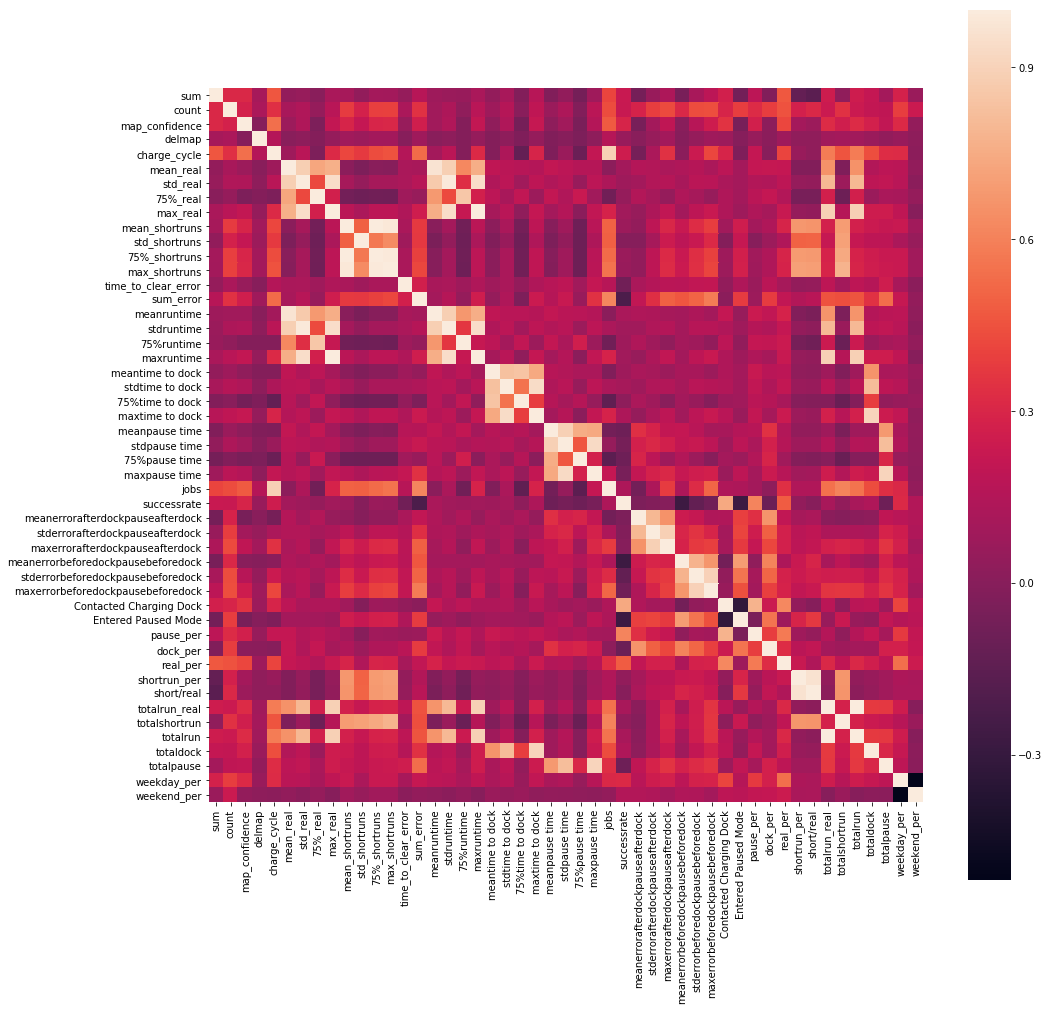

In [746]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cor = data.drop(['OEM Model','DSN'],axis=1).corr()
plt.figure(figsize=(16,16))#Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [9]:
# for i in data[(data['DSN']=='AC000W006736002')]:
#     print(data[(data['DSN']=='AC000W006736002')][i])

In [12]:
num_cols=data.select_dtypes(include=np.number).columns



In [121]:
from scipy import stats
skewlist=[]
for i in num_cols:
    
    if stats.skew(data[i])>1:
        skewlist.append(i)
    

In [122]:
#stats.skew(result['jobs'])

In [123]:
skewlist

['sum',
 'count',
 'delmap',
 'charge_cycle',
 'mean_real',
 'std_real',
 '75%_real',
 'max_real',
 'std_shortruns',
 'time_to_clear_error',
 'sum_error',
 'meanruntime',
 'stdruntime',
 '75%runtime',
 'maxruntime',
 'meantime to dock',
 'stdtime to dock',
 '75%time to dock',
 'maxtime to dock',
 'meanpause time',
 'stdpause time',
 '75%pause time',
 'maxpause time',
 'jobs',
 'meanerrorafterdockpauseafterdock',
 'stderrorafterdockpauseafterdock',
 'maxerrorafterdockpauseafterdock',
 'meanerrorbeforedockpausebeforedock',
 'shortrun_per',
 'short/real',
 'totalrun_real',
 'totalshortrun',
 'totalrun',
 'totaldock',
 'totalpause',
 'weekend_per',
 'error_per']

In [16]:
# for i in [ 'sum', 'count',   'delmap',
#        'charge_cycle',  
#        'mean_real', 'std_real',   '75%_real',
#        'max_real', 'mean_shortruns', 'std_shortruns',
#       '75%_shortruns',
#        'max_shortruns', 'time_to_clear_error', 'sum_error', 
#        'meanruntime', 'stdruntime',  '75%runtime', 'maxruntime',
#        'meantime to dock', 'stdtime to dock',
       
#        '75%time to dock', 'maxtime to dock', 
#        'meanpause time', 'stdpause time', '75%pause time', 'maxpause time',  'jobs', 'successrate',  
#        'meanerrorafterdockpauseafterdock',
#        'stderrorafterdockpauseafterdock',  
#         'maxerrorafterdockpauseafterdock',
#        'meanerrorbeforedockpausebeforedock',
#        'stderrorbeforedockpausebeforedock',
#        'maxerrorbeforedockpausebeforedock', 
#            'Contacted Charging Dock',
#        'Entered Paused Mode', 
#        'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real',
#        'totalrun_real', 'totalshortrun', 'totalrun', 'totaldock',
#        'totalpause', 'weekday_per', 'weekend_per']:
#     print(data[data[i]<0][i])

In [18]:
# data[[ 'sum', 'count',  'delmap',
#        'charge_cycle',  
#        'mean_real', 'std_real',   '75%_real',
#        'max_real', 'mean_shortruns', 'std_shortruns',
#       '75%_shortruns',
#        'max_shortruns', 'time_to_clear_error', 'sum_error', 
#        'meanruntime', 'stdruntime',  '75%runtime', 'maxruntime',
#        'meantime to dock', 'stdtime to dock',
       
#        '75%time to dock', 'maxtime to dock', 
#        'meanpause time', 'stdpause time', '75%pause time', 'maxpause time',  'jobs', 'successrate',  
#        'meanerrorafterdockpauseafterdock',
#        'stderrorafterdockpauseafterdock',  
#         'maxerrorafterdockpauseafterdock',
#        'meanerrorbeforedockpausebeforedock',
#        'stderrorbeforedockpausebeforedock',
#        'maxerrorbeforedockpausebeforedock', 
#            'Contacted Charging Dock',
#        'Entered Paused Mode', 
#        'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real',
#        'totalrun_real', 'totalshortrun', 'totalrun', 'totaldock',
#        'totalpause', 'totalrun_real', 'weekday_per', 'weekend_per']]+0.001

In [705]:
# stats.boxcox(data[[ 'sum', 'count',  'delmap',
#        'charge_cycle',  
#        'mean_real', 'std_real',   '75%_real',
#        'max_real', 'mean_shortruns', 'std_shortruns',
#       '75%_shortruns',
#        'max_shortruns', 'time_to_clear_error', 'sum_error', 
#        'meanruntime', 'stdruntime',  '75%runtime', 'maxruntime',
#        'meantime to dock', 'stdtime to dock',
       
#        '75%time to dock', 'maxtime to dock', 
#        'meanpause time', 'stdpause time', '75%pause time', 'maxpause time',  'jobs', 'successrate',  
#        'meanerrorafterdockpauseafterdock',
#        'stderrorafterdockpauseafterdock',  
#         'maxerrorafterdockpauseafterdock',
#        'meanerrorbeforedockpausebeforedock',
#        'stderrorbeforedockpausebeforedock',
#        'maxerrorbeforedockpausebeforedock', 
#            'Contacted Charging Dock',
#        'Entered Paused Mode', 
#        'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real',
#        'totalrun_real', 'totalshortrun', 'totalrun', 'totaldock',
#        'totalpause', 'totalrun_real', 'weekday_per', 'weekend_per']]+0.00001)

In [481]:
# data=data[['OEM Model', 'DSN', 'sum', 'count', 'chargefreq', 'dischargefreq',
#        'max_chargerate', 'min_chargerate', 'meanrate', 'medianrate', 'q01rate',
#        'q09rate', 'min_chargelevel', 'map_confidence', 'delmap',
#        'charge_cycle', 'countruntime', 'meanruntime', 'stdruntime',
#        '50%runtime', '75%runtime', 'maxruntime','counttime to dock' ,'meantime to dock',
#        'stdtime to dock', '50%time to dock', '75%time to dock',
#        'maxtime to dock', 'countpause time', 'meanpause time', 'stdpause time',
#        '50%pause time', '75%pause time', 'maxpause time', 'jobs',
#        'successrate', 'time_to_clear_error', 'sum_error', 'count_sig',
#        'mean_sig', 'std_sig', 'min_sig', '50%_sig', '75%_sig', 'mean_real',
#        'std_real', '50%_real', '75%_real', 'max_real', 'totalrun_per',
#        'totaldock_per', 'totalpause_per', 'totalrun_real_per',  'weekday_per',
#        'weekend_per', 'pause_per', 'dock_per']].fillna(0)

In [124]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y
data[skewlist] = sigmoid(data[skewlist])



In [125]:

# import plotly.plotly as py #For World Map
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys                    # For data size

In [126]:
#Scaling of data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MaxAbsScaler

from sklearn.cluster import KMeans

In [22]:
# data['Contacted Charging Dock']=data['Contacted Charging Dock']/(data['jobs']+0.001)
# data['Entered Paused Mode']=data['Entered Paused Mode']/(data['jobs']+0.001)

In [23]:
data.columns

Index(['OEM Model', 'DSN', 'sum', 'count', 'map_confidence', 'delmap',
       'charge_cycle', 'mean_real', 'std_real', '75%_real', 'max_real',
       'mean_shortruns', 'std_shortruns', '75%_shortruns', 'max_shortruns',
       'time_to_clear_error', 'sum_error', 'meanruntime', 'stdruntime',
       '75%runtime', 'maxruntime', 'meantime to dock', 'stdtime to dock',
       '75%time to dock', 'maxtime to dock', 'meanpause time', 'stdpause time',
       '75%pause time', 'maxpause time', 'jobs', 'successrate',
       'meanerrorafterdockpauseafterdock', 'stderrorafterdockpauseafterdock',
       'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause', 'weekday_per', 'weekend_per',
    

In [127]:
cols=['OEM Model', 'DSN', 'map_confidence', 'delmap',
        'mean_real',  'max_real',
       'mean_shortruns', 'max_shortruns',
       'time_to_clear_error', 'sum_error', 'meanruntime','maxruntime', 'meantime to dock', 'maxtime to dock', 'meanpause time', 'stdpause time',
       '75%pause time', 'maxpause time', 'jobs', 'successrate',
       'meanerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
        'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause',
        'error_per']

In [7]:
e = np.exp(1)
1/(1+e**(-0.1))

0.52497918747894

In [128]:
#data=data[cols].fillna(0)

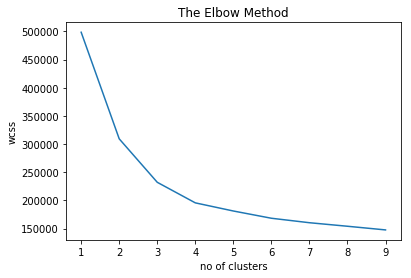

In [129]:
import pickle
nav=data.drop(['OEM Model','DSN','map_confidence'],axis=1)
ss = MinMaxScaler()
nav=ss.fit_transform(nav.fillna(0))
wcss=[]

filename = 'minmax_nav_new_month.sav'
pickle.dump(ss, open(filename, 'wb'))

for i in range(1,10):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(nav)
        wcss.append(kmeans.inertia_)
    #Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [97]:
nav.shape

(111772, 49)

In [249]:
data.columns

Index(['OEM Model', 'DSN', 'map_confidence', 'delmap', 'mean_real', 'max_real',
       'mean_shortruns', 'max_shortruns', 'time_to_clear_error', 'sum_error',
       'meanruntime', 'maxruntime', 'meantime to dock', 'maxtime to dock',
       'meanpause time', 'stdpause time', '75%pause time', 'maxpause time',
       'jobs', 'successrate', 'meanerrorafterdockpauseafterdock',
       'meanerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause', 'error_per', 'extend_error_per'],
      dtype='object')

In [250]:
# data[['meanpause time', 
#        '75%pause time', 'maxpause time',  'successrate',
#        'meanerrorafterdockpauseafterdock', 
#        'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       
#        'maxerrorbeforedockpausebeforedock', 'pause_per', 'totalpause', 'sum_error']]=data[['meanpause time', 
#        '75%pause time', 'maxpause time',  'successrate',
#        'meanerrorafterdockpauseafterdock', 
#        'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       
#        'maxerrorbeforedockpausebeforedock', 'pause_per', 'totalpause', 'sum_error']]*1.5

In [251]:
# data['sum_error']=data['sum_error']*1.5
# data['pause_per']=data['pause_per']*1.5

[0.4778504  0.13532472 0.09099642 0.04826022 0.03068817 0.02884683
 0.02723274 0.02404021 0.01915979 0.01724958 0.01442813 0.01035909
 0.00732142 0.00696939 0.00597198 0.00563491 0.0055122  0.00511987
 0.00475999 0.00424554]


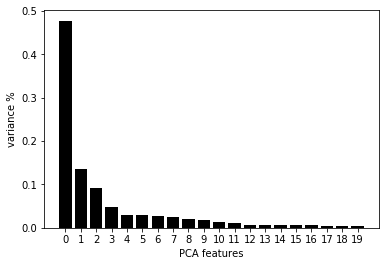

In [130]:
from sklearn.decomposition import PCA
pca_nav = PCA(n_components=20)
principalComponents_nav = pca_nav.fit_transform(nav)

filename = 'pca_nav_new_month.sav'
pickle.dump(pca_nav, open(filename, 'wb'))


# Plot the explained variances
features = range(pca_nav.n_components_)
plt.bar(features, pca_nav.explained_variance_ratio_, color='black')
print(pca_nav.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
PCA_components_nav = pd.DataFrame(principalComponents_nav)




In [131]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Text(0, 0.5, 'PCA 3')

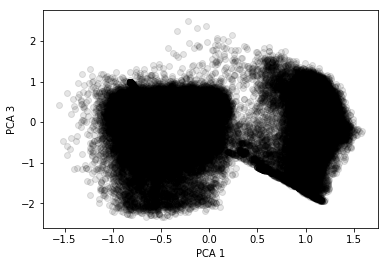

In [192]:
plt.scatter(PCA_components_nav[1], PCA_components_nav[2], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 3')

Text(0, 0.5, 'PCA 3')

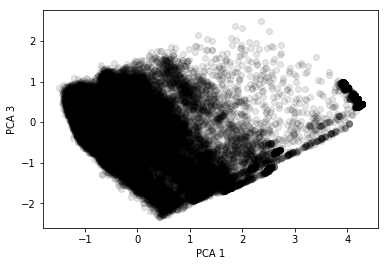

In [193]:
plt.scatter(PCA_components_nav[0], PCA_components_nav[2], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 3')

Text(0, 0.5, 'PCA 3')

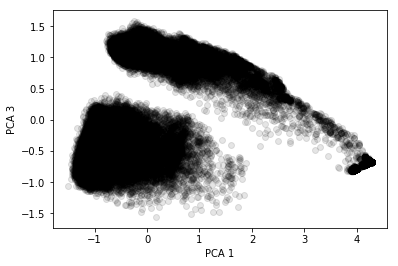

In [194]:
plt.scatter(PCA_components_nav[0], PCA_components_nav[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 3')

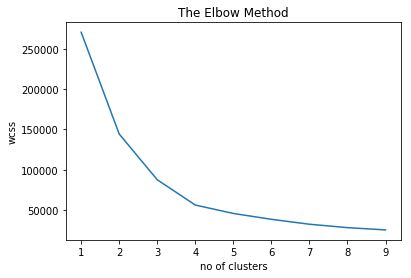

In [323]:
wcss=[]
for i in range(1,10):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(PCA_components_nav.iloc[:,:4])
        wcss.append(kmeans.inertia_)
    #Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()




In [32]:
import seaborn as sns
pca_nav=PCA_components_nav.iloc[:,:6]
pca_tsne = TSNE(n_components=3, perplexity=50.0)
nav_pca_tsne=pca_tsne.fit_transform(pca_nav)





In [33]:
tsne = TSNE(n_components=3, perplexity=50.0)
nav_tsne=tsne.fit_transform(nav)



In [42]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=20)
nav_tsvd = tsvd.fit(nav)

In [44]:
nav_tsvd.explained_variance_ratio_

array([0.4612626 , 0.1448005 , 0.09431324, 0.04988158, 0.0313098 ,
       0.02947237, 0.02735704, 0.02412745, 0.01918554, 0.01727041,
       0.01444414, 0.01035922, 0.00750749, 0.00702194, 0.00597257,
       0.00566891, 0.00552555, 0.00513177, 0.00476638, 0.00449619])

In [46]:
pd.DataFrame(nav_tsvd)

ValueError: DataFrame constructor not properly called!

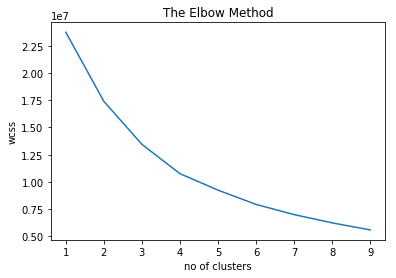

In [47]:
wcss=[]
for i in range(1,10):
        kmeans2 = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans2.fit(nav_tsne)
        wcss.append(kmeans2.inertia_)
    #Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()



In [43]:
wcss=[]
for i in range(1,10):
        kmeans2 = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans2.fit(data2.iloc[:,:4])
        wcss.append(kmeans2.inertia_)
    #Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()



AttributeError: 'TruncatedSVD' object has no attribute 'iloc'

The `size` parameter has been renamed to `height`; pleaes update your code.
invalid value encountered in true_divide
invalid value encountered in double_scalars


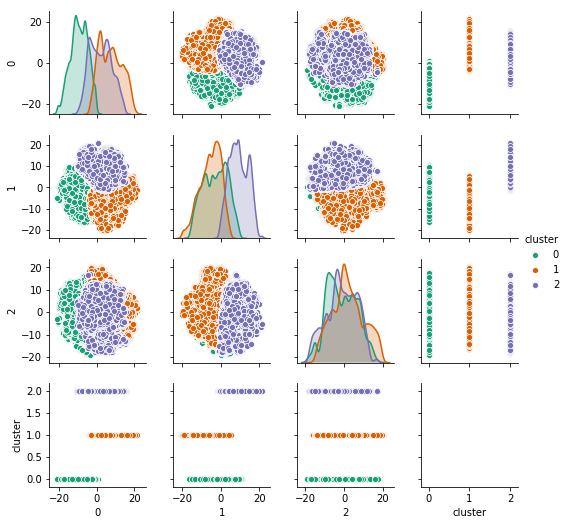

In [102]:
kmeansmodel_nav = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans_nav= kmeansmodel_nav.fit_predict(nav_tsne)
nav_pca_tsne_df=pd.DataFrame(nav_tsne)
nav_pca_tsne_df['cluster']=y_kmeans_nav
sns.pairplot(nav_pca_tsne_df, hue='cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [ ]:
#db = DBSCAN(eps=eps, min_samples=ms, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [325]:
#X_nav['X_cluster'].value_counts()/len(X_nav)

1    0.574849
0    0.340729
2    0.084422
Name: X_cluster, dtype: float64

In [440]:
#X_nav['X_cluster'].value_counts()

1    64252
0    38084
2     9436
Name: X_cluster, dtype: int64

In [103]:
nav_pca_tsne_df['cluster'].value_counts()/len(nav_pca_tsne_df)

0    0.358363
1    0.347878
2    0.293759
Name: cluster, dtype: float64

In [56]:
cols=['OEM Model', 'DSN', 'map_confidence', 'delmap', 'mean_real', 'max_real', 'mean_shortruns', 'max_shortruns', 'time_to_clear_error', 'sum_error', 'meanruntime', 'maxruntime', 'meantime to dock', 'maxtime to dock', 'meanpause time', 'stdpause time', '75%pause time', 'maxpause time', 'jobs', 'successrate', 'meanerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock', 'Contacted Charging Dock', 'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per', 'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun', 'totalrun', 'totaldock', 'totalpause', 'error_per']

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier(max_depth= 3, eta= 1, learning_rate= 0.01,n_estimators=200)

model.fit(data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1),nav_pca_tsne_df['cluster'])

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

#predict_test = model.predict(test[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))
predict_train = model.predict(data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


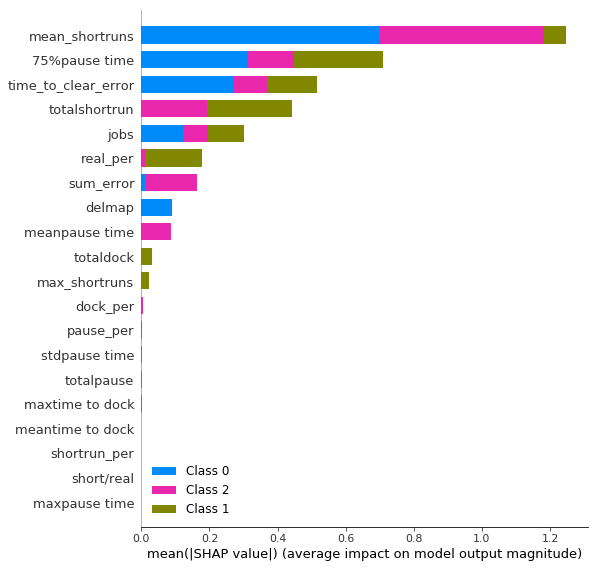

In [105]:
shap.summary_plot(shap_values, data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

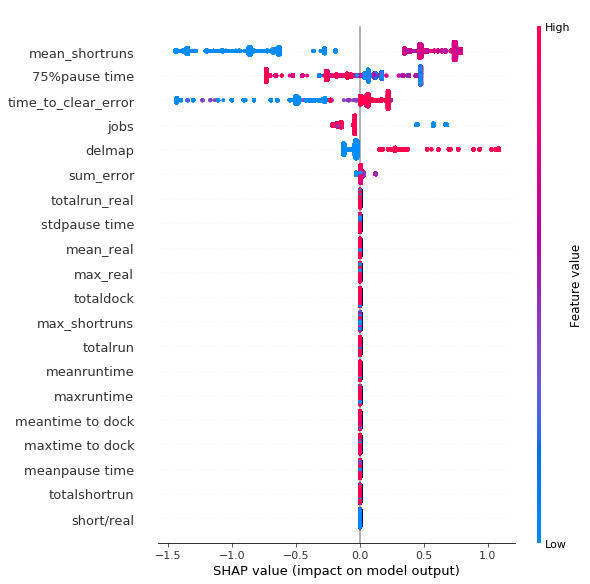

In [106]:
shap.summary_plot(shap_values[0], data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

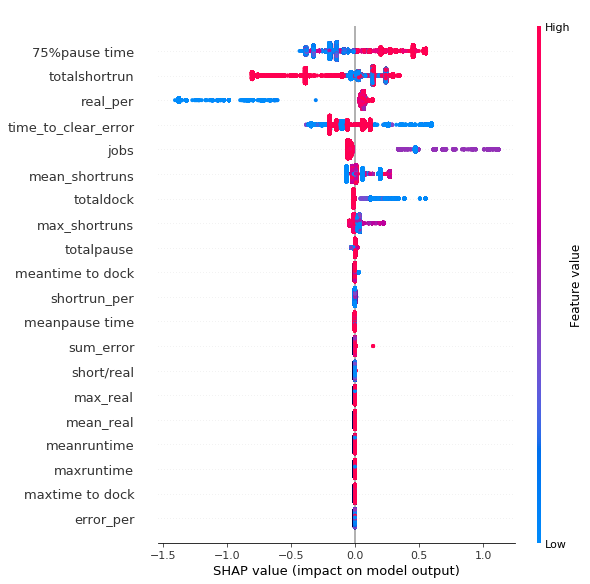

In [107]:
shap.summary_plot(shap_values[1], data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

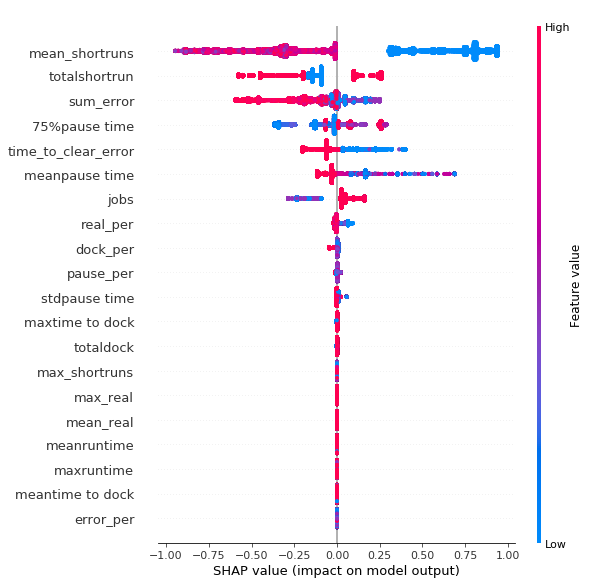

In [108]:
shap.summary_plot(shap_values[2], data[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The `size` parameter has been renamed to `height`; pleaes update your code.
invalid value encountered in true_divide
invalid value encountered in double_scalars


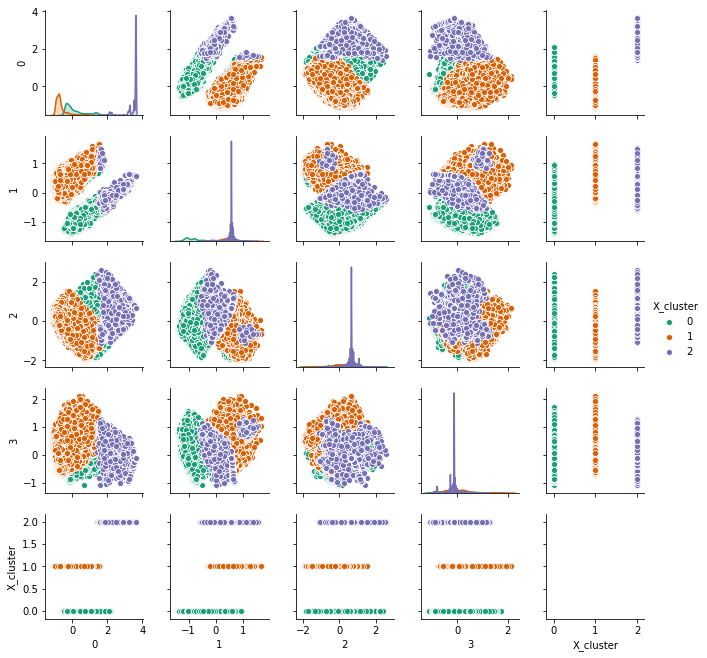

In [326]:
import seaborn as sns
X_nav=PCA_components_nav.iloc[:,:4]
kmeansmodel_nav = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans_nav= kmeansmodel_nav.fit_predict(X_nav)
X_nav['X_cluster']=y_kmeans_nav
sns.pairplot(X_nav, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [328]:
import pickle
filename = 'kmeans_nav_new_month.sav'
pickle.dump(kmeansmodel_nav, open(filename, 'wb'))

In [92]:
test=pd.read_csv('test_month.csv')

In [93]:
test[skewlist] = sigmoid(test[skewlist])

In [98]:
nav_test.shape

(142, 51)

In [100]:
nav_test.columns

Index(['sum', 'count', 'delmap', 'charge_cycle', 'mean_real', 'std_real',
       '75%_real', 'max_real', 'mean_shortruns', 'std_shortruns',
       '75%_shortruns', 'max_shortruns', 'time_to_clear_error', 'sum_error',
       'meanruntime', 'stdruntime', '75%runtime', 'maxruntime',
       'meantime to dock', 'stdtime to dock', '75%time to dock',
       'maxtime to dock', 'meanpause time', 'stdpause time', '75%pause time',
       'maxpause time', 'jobs', 'successrate',
       'meanerrorafterdockpauseafterdock', 'stderrorafterdockpauseafterdock',
       'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause', 'weekday_per', 'weekend_per',
       'extend_error', 'error_per', 'exten

In [111]:
nav_test=test.drop(['DSN','OEM Model','map_confidence','extend_error_per','extend_error'],axis=1).fillna(0)

nav_test=ss.transform(nav_test)

#principalComponents_nav_test = pca_nav.transform(nav_test)



#PCA_components_nav_test = pd.DataFrame(principalComponents_nav_test)


nav_test=tsne.fit_transform(nav_test)



The `size` parameter has been renamed to `height`; pleaes update your code.
invalid value encountered in true_divide
invalid value encountered in double_scalars


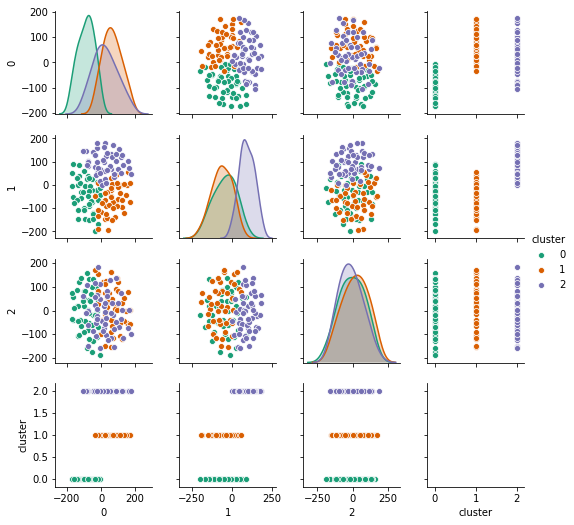

In [112]:
#X_nav_test=PCA_components_nav_test.iloc[:,:4]
y_kmeans_nav_test= kmeansmodel_nav.predict(nav_test)
nav_test_df=pd.DataFrame(nav_test)
nav_test_df['cluster']=y_kmeans_nav_test
sns.pairplot(nav_test_df, hue='cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [114]:
nav_test_df['cluster'].value_counts()

2    50
0    47
1    45
Name: cluster, dtype: int64

In [417]:
data2=X_nav[X_nav['X_cluster']!=2]

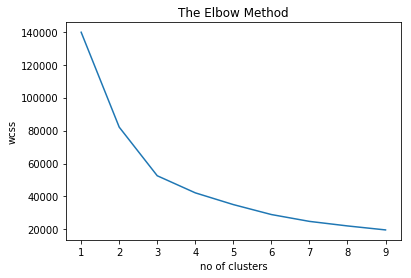

In [424]:
wcss=[]
for i in range(1,10):
        kmeans2 = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans2.fit(data2.iloc[:,:4])
        wcss.append(kmeans2.inertia_)
    #Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The `size` parameter has been renamed to `height`; pleaes update your code.
invalid value encountered in true_divide
invalid value encountered in double_scalars


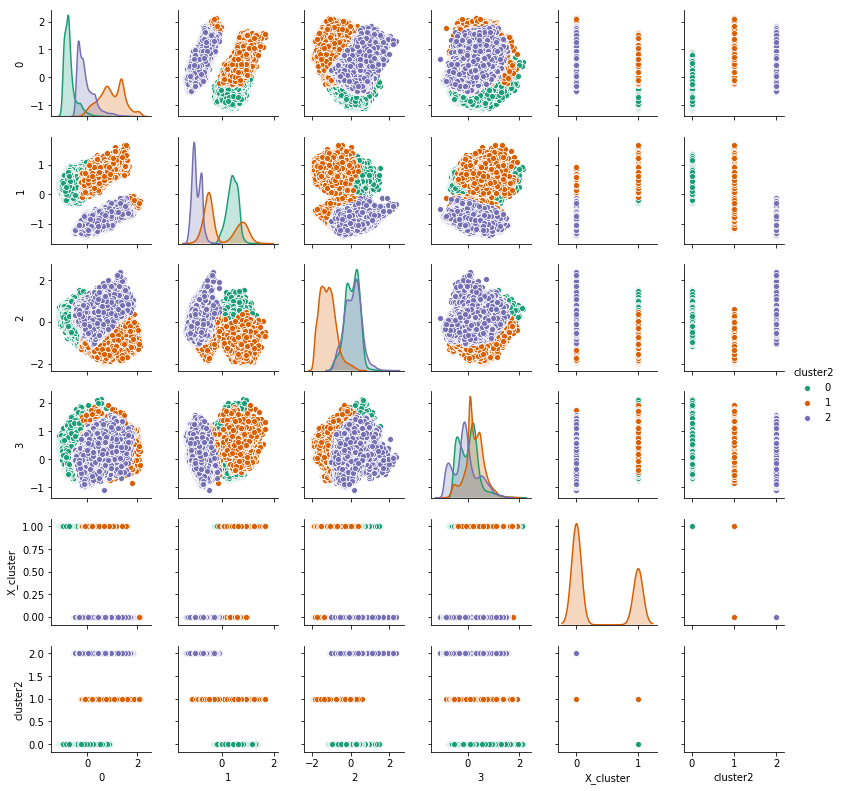

In [425]:
import seaborn as sns
#X_nav=PCA_components_nav.iloc[:,:4]
kmeansmodel2_nav = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans2_nav= kmeansmodel2_nav.fit_predict(data2.iloc[:,:4])
data2['cluster2']=y_kmeans2_nav
sns.pairplot(data2, hue='cluster2', palette= 'Dark2', diag_kind='kde',size=1.85)

In [432]:
train[cols][X_nav['X_cluster']!=2].shape

Boolean Series key will be reindexed to match DataFrame index.


(102267, 36)

In [433]:
data2['cluster2'].shape

(102336,)

In [434]:
model = XGBClassifier(max_depth= 3, eta= 1, learning_rate= 0.01,n_estimators=200)

model.fit(data[cols][X_nav['X_cluster']!=2].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1),data2['cluster2'])

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[cols][X_nav['X_cluster']!=2].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

#predict_test = model.predict(test[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))
predict_train = model.predict(data[cols][X_nav['X_cluster']!=2].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

#print(accuracy_score(train[X_nav['X_cluster']!=2]['target'],predict_train))
#print(accuracy_score(y_test_nav,predict_test))

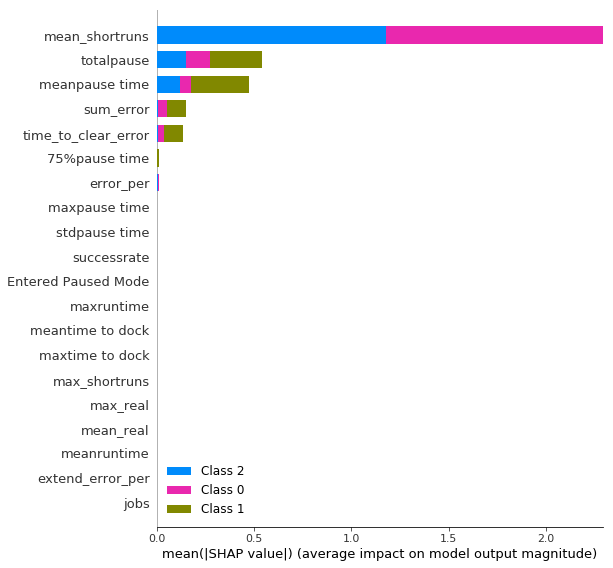

In [436]:
shap.summary_plot(shap_values, data[cols][X_nav['X_cluster']!=2][cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [ ]:
more shortruns, more pause

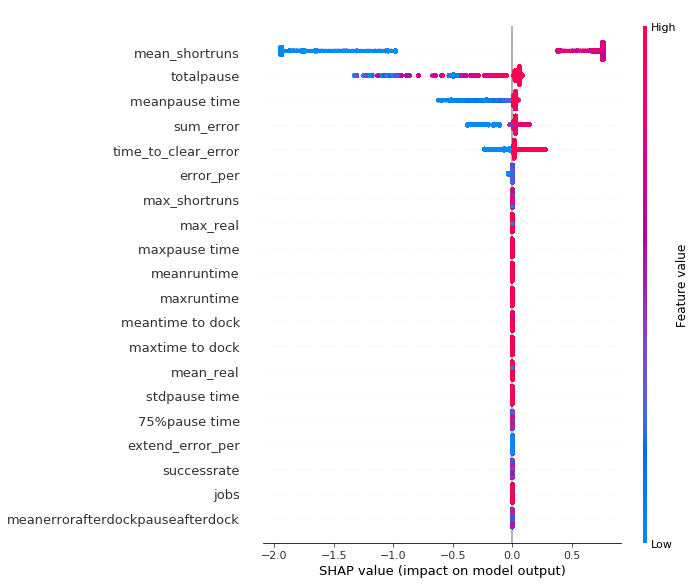

In [435]:
shap.summary_plot(shap_values[0], data[X_nav['X_cluster']!=2][cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [ ]:
less pause, less error

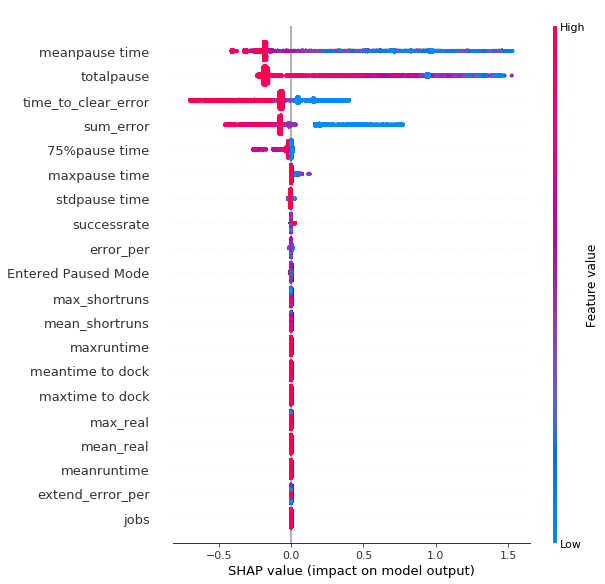

In [437]:
shap.summary_plot(shap_values[1], data[X_nav['X_cluster']!=2][cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [ ]:
less shortruns, more pause

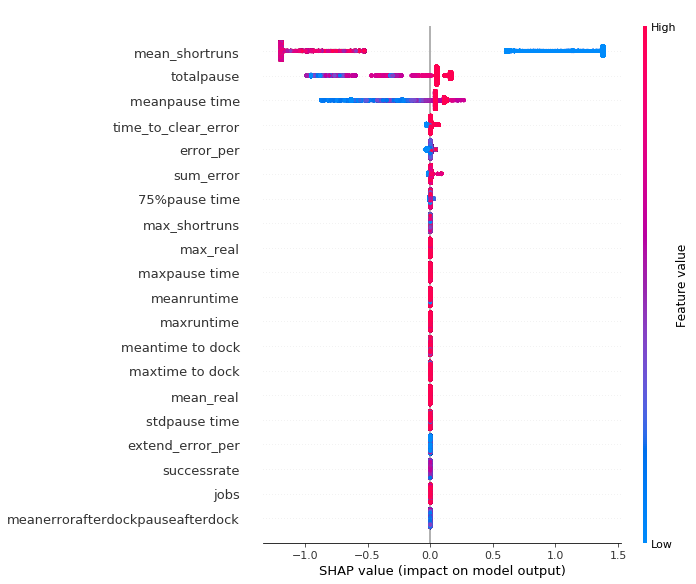

In [438]:
shap.summary_plot(shap_values[2], data[X_nav['X_cluster']!=2][cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [439]:
data2['cluster2'].value_counts()

0    60021
2    30467
1    11848
Name: cluster2, dtype: int64

In [ ]:
data2

In [4]:
import numpy as np
e = np.exp(1)
1/(1+e**(-10))

0.9999546021312976

In [334]:
test=pd.read_csv('test_month.csv')
validate=pd.read_csv('test_month.csv')[80:]
train=pd.read_csv('train_month.csv')

In [335]:
badlist=list(test['DSN'].unique())
badlist.append(list(validate['DSN'].unique()))

In [336]:
train.columns

Index(['OEM Model', 'DSN', 'sum', 'count', 'map_confidence', 'delmap',
       'charge_cycle', 'mean_real', 'std_real', '75%_real', 'max_real',
       'mean_shortruns', 'std_shortruns', '75%_shortruns', 'max_shortruns',
       'time_to_clear_error', 'sum_error', 'meanruntime', 'stdruntime',
       '75%runtime', 'maxruntime', 'meantime to dock', 'stdtime to dock',
       '75%time to dock', 'maxtime to dock', 'meanpause time', 'stdpause time',
       '75%pause time', 'maxpause time', 'jobs', 'successrate',
       'meanerrorafterdockpauseafterdock', 'stderrorafterdockpauseafterdock',
       'maxerrorafterdockpauseafterdock', 'meanerrorbeforedockpausebeforedock',
       'stderrorbeforedockpausebeforedock',
       'maxerrorbeforedockpausebeforedock', 'Contacted Charging Dock',
       'Entered Paused Mode', 'pause_per', 'dock_per', 'real_per',
       'shortrun_per', 'short/real', 'totalrun_real', 'totalshortrun',
       'totalrun', 'totaldock', 'totalpause', 'weekday_per', 'weekend_per',
    

In [337]:
#train=train[(z < 3).all(axis=1)].fillna(0)
test=test.fillna(0)
validate=validate.fillna(0)
# train[skewlist] = sigmoid(train[skewlist])
# test[skewlist] = sigmoid(test[skewlist])
# validate[skewlist] = sigmoid(validate[skewlist])

In [338]:
train['target']=y_kmeans_nav

In [339]:
train=train[train['DSN'].isin(badlist)==False]

In [340]:
train.shape

(111701, 55)

In [341]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# train_nav, test_nav, y_train_nav, y_test_nav = train_test_split(
#     data,y_kmeans_nav , test_size=0.20, random_state=None)


# Vectorizer / regressor pipeline that filters out tokens that are too rare or too frequent

# train_rad, test_rad, y_train_rad, y_test_rad = train_test_split(
#     random,y_kmeans_rad , test_size=0.20, random_state=None)

In [363]:
model = XGBClassifier(max_depth= 3, eta= 1, learning_rate= 0.01,n_estimators=200)

model.fit(train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1),train['target'])

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

predict_test = model.predict(test[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))
predict_train = model.predict(train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

print(accuracy_score(train['target'],predict_train))
#print(accuracy_score(y_test_nav,predict_test))

0.9949776635840324


1. error related feature a larger weight
2. different threshold

In [387]:
sum(predict_test==0)/len(predict_test)

0.24647887323943662

In [344]:
sum(predict_test==1)/len(predict_test)

0.9084507042253521

In [345]:
sum(predict_test==2)/len(predict_test)

0.08450704225352113

In [359]:
len(predict_test)

142

In [381]:
test['cluster']=predict_test

In [383]:
test['cluster']=test['cluster'].map({0:'success',1:'failed',2:'not often'})

In [388]:
sum(predict_test==1)/len(predict_test)

0.6619718309859155

In [384]:
test['cluster'].value_counts()

failed       94
success      35
not often    13
Name: cluster, dtype: int64

In [389]:
test[['DSN','cluster']].to_csv('returned_rv1000.csv',index=False)

In [360]:
predict_test

array([1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

In [364]:
predict_train_prob = model.predict_proba(train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))
predict_test_prob = model.predict_proba(test[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))


In [347]:
predict_train_prob[:,0].mean()

0.33930314

In [348]:
predict_train_prob[:,1].mean()

0.5355267

In [349]:
predict_train_prob[:,2].mean()

0.12517013

In [350]:
predict_test_prob[:,0].mean()

0.08735893

In [351]:
predict_test_prob[:,1].mean()

0.814782

In [352]:
predict_test_prob[:,2].mean()

0.09785902

In [353]:
sum(predict_train_prob.max(axis=1)>0.5)/len(predict_train_prob)

0.9980931236067716

In [354]:
sum(predict_test_prob.max(axis=1)>0.6)/len(predict_test_prob)

0.9014084507042254

In [92]:
predict_test_prob.max(axis=1)

array([0.88963646, 0.8804458 , 0.88963646, 0.8839666 , 0.8897861 ,
       0.89090884, 0.88963646, 0.88963646, 0.89090884, 0.89090884,
       0.87709695, 0.88963646, 0.8897861 , 0.8897861 , 0.8897861 ,
       0.8897861 , 0.8897861 , 0.8897861 , 0.88822335, 0.70429   ,
       0.8804458 , 0.8804458 , 0.88963646, 0.8897861 , 0.867419  ,
       0.8897861 , 0.885506  , 0.8576113 , 0.89090884, 0.8897861 ,
       0.8897861 , 0.8897861 , 0.8897861 , 0.8897861 , 0.88963646,
       0.8897861 , 0.8897861 , 0.86524516, 0.88963646, 0.88963646,
       0.885506  , 0.8897861 , 0.8897861 , 0.88963646, 0.8897861 ,
       0.8897861 , 0.8897861 , 0.88473463, 0.88963646, 0.89090884,
       0.8897861 , 0.8897861 , 0.8694303 , 0.8897861 , 0.8897861 ,
       0.8897861 , 0.8886174 , 0.8897861 , 0.8897861 , 0.8897861 ,
       0.8897861 , 0.88963646, 0.88963646, 0.8897861 , 0.8897861 ,
       0.8897861 , 0.85631776, 0.8897861 , 0.88963646, 0.88963646,
       0.88963646, 0.88963646, 0.8897861 , 0.8897861 , 0.88978

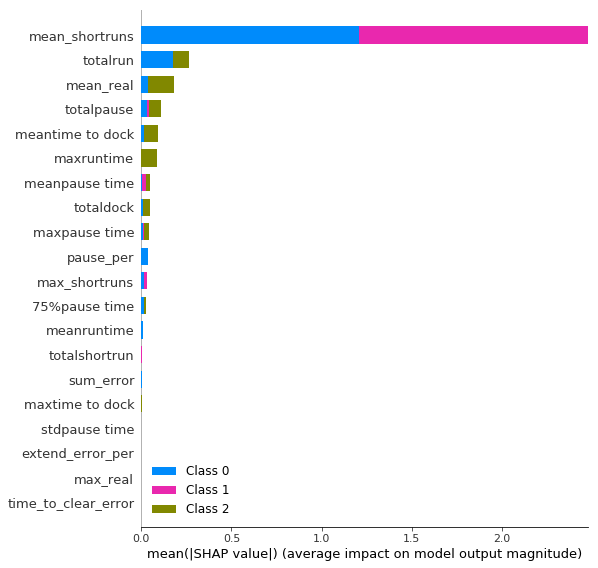

In [366]:
shap.summary_plot(shap_values, train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [921]:
#success

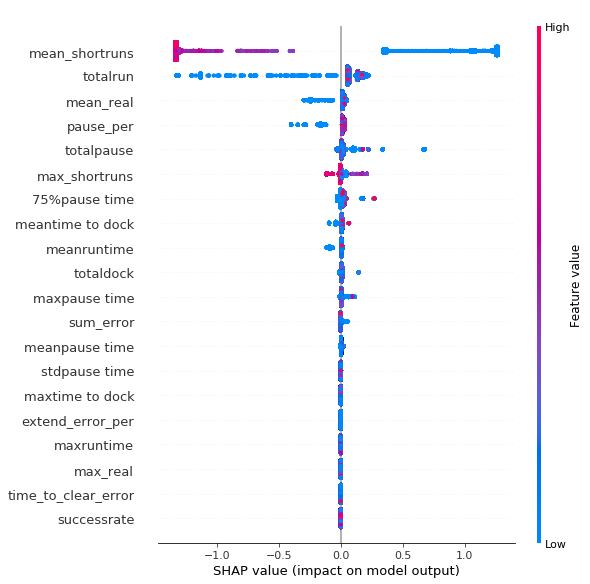

In [367]:
shap.summary_plot(shap_values[0], train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [155]:
#more shortruns, more pause, more error

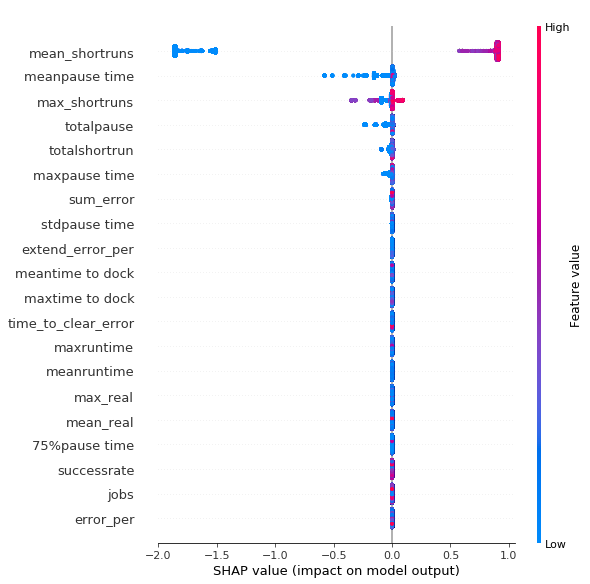

In [368]:
shap.summary_plot(shap_values[1], train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [157]:
#less real, low dock

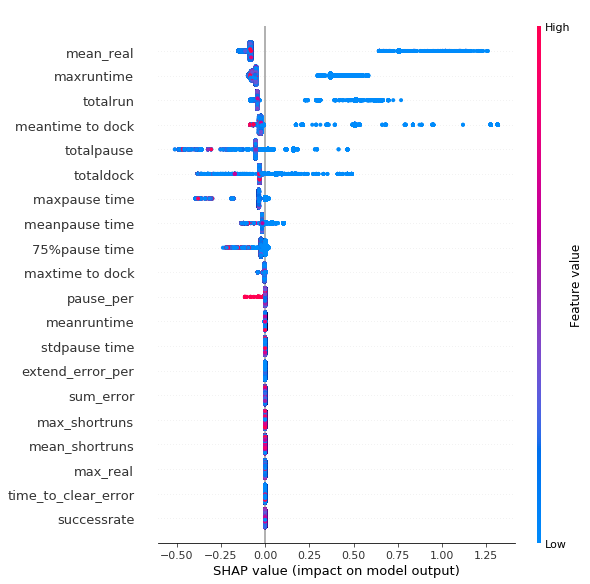

In [369]:
shap.summary_plot(shap_values[2], train[cols].fillna(0).drop(['OEM Model','DSN','map_confidence'],axis=1))

In [ ]:
less shortruns, more pause, more error

In [312]:
shap.summary_plot(shap_values[3], train.drop(['OEM Model','DSN','map_confidence','target'],axis=1))

IndexError: list index out of range

In [863]:
predict_train_proba = model.predict_proba(train.drop(['OEM Model','DSN','map_confidence'],axis=1))



In [864]:
predict_train_proba

array([[0.05502938, 0.88970983, 0.05526076],
       [0.05522522, 0.05518329, 0.8895915 ],
       [0.06174293, 0.8631303 , 0.07512674],
       ...,
       [0.05522522, 0.05518329, 0.8895915 ],
       [0.05522522, 0.05518329, 0.8895915 ],
       [0.05789892, 0.05699076, 0.8851103 ]], dtype=float32)

In [370]:
result=pd.read_csv('train_month.csv').fillna(0)

In [371]:
#result=result[(z < 3).all(axis=1)]

In [372]:
result['cluster']=y_kmeans_nav

In [373]:
result['cluster'].value_counts()

1    64252
0    38084
2     9436
Name: cluster, dtype: int64

In [374]:
result['cluster'].value_counts()/len(result)

1    0.574849
0    0.340729
2    0.084422
Name: cluster, dtype: float64

In [106]:
list(test[predict_test==2]['DSN'])

['AC000W008128921',
 'AC000W008129582',
 'AC000W008136541',
 'AC000W008137212',
 'AC000W008140665',
 'AC000W008141580',
 'AC000W008186082',
 'AC000W008190301',
 'AC000W008191923',
 'AC000W008216434',
 'AC000W008235242',
 'AC000W008241414',
 'AC000W008244446',
 'AC000W008250040',
 'AC000W008285000',
 'AC000W008310869',
 'AC000W008311693',
 'AC000W008341279',
 'AC000W008341628',
 'AC000W008342339',
 'AC000W008342634',
 'AC000W008343379',
 'AC000W008356715',
 'AC000W008361606',
 'AC000W008364359',
 'AC000W008369879',
 'AC000W008602177',
 'AC000W008708162',
 'AC000W008709081',
 'AC000W008779874',
 'AC000W008791727',
 'AC000W008797817',
 'AC000W008797820',
 'AC000W008799146',
 'AC000W008824713']

In [376]:
result.fillna(0).groupby(['cluster'])[cols].mean().T

cluster                                       0            1           2
map_confidence                        44.439292    58.253300    3.963226
delmap                                 0.076935     0.175777    0.005405
mean_real                            338.054102   169.359373   27.415819
max_real                            1189.338331  1301.521213   32.460894
mean_shortruns                         0.041776    10.521732    0.061308
max_shortruns                          0.041934    11.954445    0.061573
time_to_clear_error                  916.026300   972.746647  245.592134
sum_error                              2.548078     5.674640    0.366151
meanruntime                          281.158206   138.436618   22.697920
maxruntime                          1187.989681  1301.513042   30.358627
meantime to dock                     323.605999   189.695491   19.121611
maxtime to dock                     1008.012906  1139.065390   19.621181
meanpause time                       210.898227   102.324188   15.323926
stdpause time                        317.607746   262.347137    4.030433
75%pause time                        199.231875    49.527148   16.434750
maxpause time                        856.277386   960.430785   19.431254
jobs                                   8.817272    21.166625    0.265155
successrate                            0.416778     0.370588    0.049167
meanerrorafterdockpauseafterdock       0.797268     0.594676    0.073170
meanerrorbeforedockpausebeforedock     0.288254     0.341272    0.037131
Contacted Charging Dock                0.579363     0.505085    0.055998
Entered Paused Mode                    0.237410     0.299187    0.046678
pause_per                              0.551338     0.468679    0.038050
dock_per                               0.493401     0.448463    0.045170
real_per                               0.832354     0.819006    0.058123
shortrun_per                           0.001654     0.166516    0.004564
short/real                             0.001821     0.212373    0.005797
totalrun_real                       1752.269772  2435.490459   35.323442
totalshortrun                          0.043903    29.343974    0.062209
totalrun                            1753.001680  2440.386634   33.687368
totaldock                           1280.234960  1711.053533   19.627505
totalpause                          1075.097233  1453.079336   19.434314
error_per                              0.384977     0.301107    0.057610
extend_error_per                       1.325400     0.640724    0.374320

In [403]:
internal2=pd.read_csv('./Downloads/Sharkninja+Internal+DSN.csv')

In [391]:
internal[internal['OEM Model'].isin(['RV1000','RV1000A'])]

UserEmail                                  UUID  \
0                 akumar@sharkninja.com  034859c0-fcd0-11e9-bf86-0eeeac4e5622   
2               grichter@sharkninja.com  03bcfac0-7328-11e7-88af-0e9382159dc5   
3               bmuldoon@sharkninja.com  04726268-8531-11e8-8178-0ab3f06930bb   
15              bmuldoon@sharkninja.com  04726268-8531-11e8-8178-0ab3f06930bb   
114   sharkiotind+smoketestmd@gmail.com  04a9fb12-5d05-11ea-af6b-0a580ae90507   
...                                 ...                                   ...   
1352                  2290639816@qq.com  ff7381cc-ff7b-11e9-aeeb-0eeeac4e5622   
1353                  2290639816@qq.com  ff7381cc-ff7b-11e9-aeeb-0eeeac4e5622   
1354                  2290639816@qq.com  ff7381cc-ff7b-11e9-aeeb-0eeeac4e5622   
1355                  2290639816@qq.com  ff7381cc-ff7b-11e9-aeeb-0eeeac4e5622   
1356                  2290639816@qq.com  ff7381cc-ff7b-11e9-aeeb-0eeeac4e5622   

                  DSN OEM Model  
0     AC000W008714127   RV1000A  
2     AC000W008699125   RV1000A  
3     AC000W008687166    RV1000  
15    AC000W007825682    RV1000  
114   AC000W008708314   RV1000A  
...               ...       ...  
1352  AC000W008096195   RV1000A  
1353  AC000W008096197   RV1000A  
1354  AC000W008096198   RV1000A  
1355  AC000W008228116   RV1000A  
1356  AC000W008368885   RV1000A  

[697 rows x 4 columns]

In [395]:
internal.shape

(1357, 4)

In [393]:
result[result['DSN'].isin(internal['DSN'])]['cluster'].value_counts()

2    95
0    84
1    81
Name: cluster, dtype: int64

In [414]:
result[result['DSN'].isin(internal['DSN'])]['cluster'].value_counts()/len(result[result['DSN'].isin(internal['DSN'])])

2    0.365385
0    0.323077
1    0.311538
Name: cluster, dtype: float64

In [521]:
result[result['DSN'].isin(internal['DSN'])]['cluster'].value_counts()/len(result[result['DSN'].isin(internal['DSN'])])

0    0.369231
1    0.357692
2    0.273077
Name: cluster, dtype: float64

In [399]:
internal=result[result['DSN'].isin(internal['DSN'])]

In [401]:
internal['cluster']=internal['cluster'].map({0:'success',1:'failed',2:'not often'})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [411]:
internal['cluster'].value_counts()

not often    95
success      84
failed       81
Name: cluster, dtype: int64

In [406]:
f=pd.merge(internal2,internal[['DSN','cluster']],on='DSN',how='right')

In [409]:
f.drop_duplicates(subset=['DSN']).to_csv('internal_rv1000.csv',index=False)

In [407]:
f.to_csv('internal_rv1000.csv',index=False)

In [13]:
0- success
1- failed
2- not often

map({0:'success',1:'failed',2:'not often'})

In [166]:
train['extend_error']

0          0.0
3          0.0
4         35.0
5          0.0
7          0.0
          ... 
111767     0.0
111768     0.0
111769     0.0
111770     0.0
111771     0.0
Name: extend_error, Length: 83889, dtype: float64

In [413]:
f.drop_duplicates(subset=['DSN'])['cluster'].value_counts()

not often    90
success      84
failed       81
Name: cluster, dtype: int64

In [ ]:
missions.to_csv('missions_localtime2.csv',index=False)

# switch to Untitled1

In [122]:
missions['DSN'].nunique()

387198

In [14]:
#missions=missions.drop('job',axis=1)

In [148]:
missions[missions['Property Name']=='GET_PbFloor_Confidence']['OEM Model'].value_counts()

RV1000A    153467
RV1000      30997
Name: OEM Model, dtype: int64

In [17]:
location=pd.read_csv('./Downloads/IoT+-+Locations.csv').sort_values(['OEM Model','DSN','Location Timestamp UTC']).drop_duplicates(['DSN'],keep='last')

In [18]:
from timezonefinder import TimezoneFinder
def timezone(data):
    tf = TimezoneFinder()
    latitude, longitude = data['Lat'], data['Long']
    return tf.timezone_at(lng=longitude, lat=latitude) # returns 'Europe/Berlin'

In [19]:
location=location.dropna(subset=['Lat','Long'])

In [20]:
location['zone']=location.T.apply(timezone)

In [21]:
location.to_csv('location_zone.csv',index=False)

In [26]:
missions.shape

(10908633, 19)

In [214]:
location.shape

(555810, 10)

In [215]:
location['DSN'].nunique()

555810

In [27]:
missions=pd.merge(missions,location[['DSN','zone']],on='DSN',how='left')

In [28]:
missions['Created At']=pd.to_datetime(missions['Created At'])

In [29]:
missions.shape

(10908633, 20)

In [35]:
import pytz
def localtime(data):
    try:
        tz = pytz.timezone(data['zone'])

        local=tz.fromutc(data['Created At'])
    except: local=np.nan
    return local

In [38]:
missions['localtime']=missions.T.apply(localtime)

In [39]:
missions.to_csv('missions_localtime.csv',index=False)

In [138]:
missions=pd.read_csv('missions_localtime.csv')

In [110]:
# def fun2(data):
#     # local time stamp

#     try:
#         maps=data[data['Property Name']=='GET_PbFloor_Confidence'].iloc[-1]['Value']
        
#     except: maps=''
#     #print(maps)
#     mapdel=len(data[(data['Property Name']=='SET_DeleteMaps')&(data['Value']==-1)])
#     cycles=len(data[(data['Property Name']=='GET_Battery_Capacity')&(data['Value'].diff()!=0)&(data['Value']==100)])

# #     try:
# #         version1=data[data['Property Name']=='GET_Nav_Module_App_Version'].iloc[-1]['Value']
# #     except: version1=''
# #     try:
# #         version2=data[data['Property Name']== 'OTA_FW_VERSION'].iloc[-1]['Value']
# #     except: version2=''

#     recharge=data[data['Property Name']=='SET_Recharge_Resume']['Charging Value'].max()
#     evacuate=data[data['Property Name']=='SET_Evacuate_Resume']['Charging Value'].max()
#     #print([maps,mapdel,cycles,version1,version2,recharge,evacuate])
#     return pd.DataFrame([maps,mapdel,cycles,recharge,evacuate],index=['map_confidence','delmap','charge_cycle','recharge','evacuate']).T
    

In [1]:
def fun4(data):
    dockend=data[data['Property Name']=='Contacted Charging Dock']['Created At'].min()
    dockst=data[data['Property Name']=='Entered Dock Mode']['Created At'].min()
    dur=(dockend-dockst).total_seconds()/60
    data['dur']=-data['Created At'].diff(-1).dt.total_seconds()/60
    pause=data[data['Property Name'].isin(['Entered Paused Mode','GET_Error_Code'])]['dur'].sum()
    data['time_to_dock']=dur
    data['pause']=pause
    return data.iloc[0]

In [134]:
def fun3(data):
    data['hour']=data['localtime'].map(str).apply(lambda x:x[11:13])
    data['weekday']=data['Created At'].dt.weekday
    data['weekday']=data['weekday'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
    hour=data[data['Property Name']=='Entered Clean Mode'].groupby('hour').size()
    weekday=data[data['Property Name']=='Entered Clean Mode'].groupby('weekday').size()
    jobs=data['runs'].max()+1
    
    runs=data.groupby('runs').apply(fun4).reset_index(drop=True)
    runtime=runs['runtime'].describe()
    dock=runs['time_to_dock'].dropna().describe()
    clean=runs['pause'].dropna().describe()
    runtime.index= [i+'runtime' for i in runtime.index]
    dock.index= [i+'time to dock' for i in dock.index]

    clean.index= [i+'pause time' for i in clean.index]
    
    job=pd.DataFrame([jobs,(runs['job'].sum()/jobs)],index=['jobs','successrate'])
    #runs[['runtime','time_to_dock','clean_time']].describe().unstack()
    return pd.concat([hour.T,weekday.T,runtime.T,dock.T,clean.T,job]).T

In [140]:
missions['Created At']=pd.to_datetime(missions['Created At'])

In [141]:
missions.groupby(['OEM Model','DSN']).apply(fun3).reset_index().to_csv('mission_result.csv',index=False)

In [111]:
#final_df.groupby(['OEM Model','DSN']).apply(fun2).reset_index().to_csv('cluster_part2.csv',index=False)

In [16]:
#part1=pd.read_csv('cluster_part1.csv')

In [171]:
part1.columns

Index(['OEM Model', 'DSN', 'level_2', 'sum', 'count', 'No Dustbox Error',
       'totalruntime', 'runfreq', 'online', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'max_dischargerate', 'min_chargelevel',
       'Bumper Error', 'Cliff Sensor Error', 'Error = 0',
       'Bumper Error time to clear', 'Bumper Error#clear',
       'No Battery/Fuse Error', 'No Battery/Fuse Error time to clear',
       'No Battery/Fuse Error#clear', 'Drop Error', 'Drop Error time to clear',
       'Drop Error#clear', 'Cliff Sensor Error time to clear',
       'Cliff Sensor Error#clear', 'Front Wheel Error',
       'Front Wheel Error time to clear', 'Front Wheel Error#clear',
       'Wheel Encoder Error', 'Wheels Error',
       'Wheel Encoder Error time to clear', 'Wheel Encoder Error#clear',
       'Wheels Error time to clear', 'Wheels Error#clear',
       'No Dustbox Error time to clear', 'No Dustbox Error#clear',
       'Mag Strip Error', 'Mag Strip Error time to clear',
       'Mag Strip Error#cl

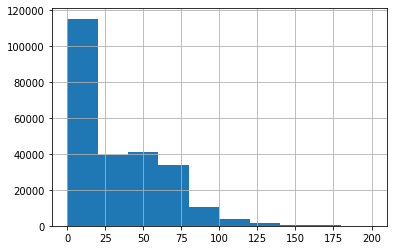

In [168]:
%matplotlib inline
part1['sum'].hist(range=[0,200])

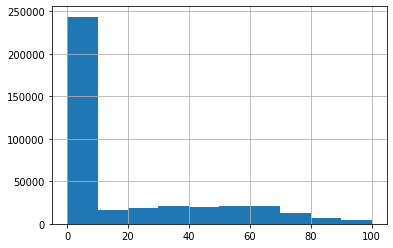

In [174]:
part1['sum'].fillna(0).hist(range=[0,100])

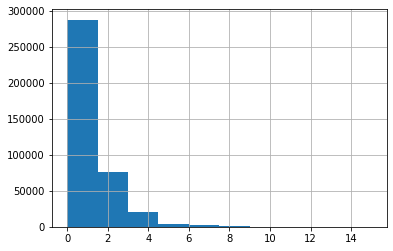

In [175]:
part1['count'].fillna(0).hist(range=[0,15])

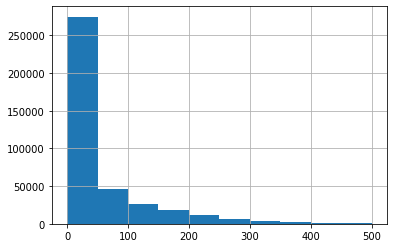

In [179]:
part1['totalruntime'].fillna(0).hist(range=[0,500])

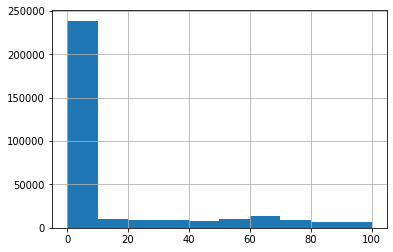

In [180]:
part1['totalruntime'].fillna(0).hist(range=[0,100])

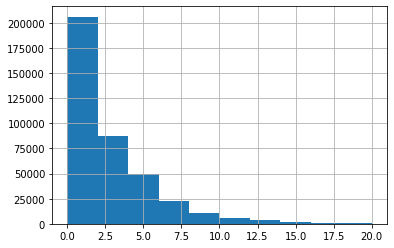

In [182]:
part1['runfreq'].fillna(0).hist(range=[0,20])

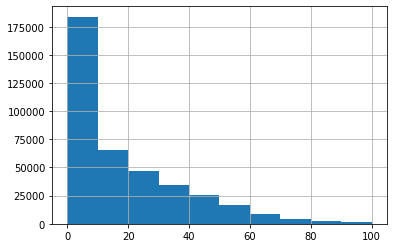

In [185]:
part1['chargefreq'].fillna(0).hist(range=[0,100])

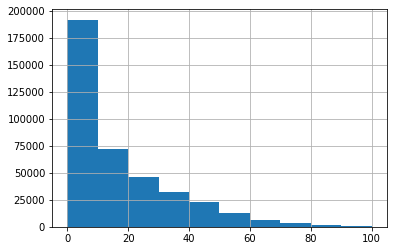

In [186]:
part1['dischargefreq'].fillna(0).hist(range=[0,100])

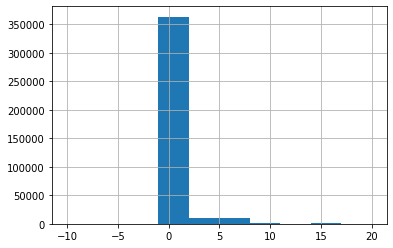

In [193]:
part1[part1['max_chargerate']!=np.inf]['max_chargerate'].hist(range=[-10,20])

In [194]:
part1[part1['max_chargerate']!=np.inf]['max_chargerate'].describe()

count    385708.000000
mean          0.476837
std           1.892280
min         -21.250000
25%           0.000000
50%           0.041322
75%           0.263158
max         100.000000
Name: max_chargerate, dtype: float64

In [197]:
part1.columns

Index(['OEM Model', 'DSN', 'level_2', 'sum', 'count', 'No Dustbox Error',
       'totalruntime', 'runfreq', 'online', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'max_dischargerate', 'min_chargelevel',
       'Bumper Error', 'Cliff Sensor Error', 'Error = 0',
       'Bumper Error time to clear', 'Bumper Error#clear',
       'No Battery/Fuse Error', 'No Battery/Fuse Error time to clear',
       'No Battery/Fuse Error#clear', 'Drop Error', 'Drop Error time to clear',
       'Drop Error#clear', 'Cliff Sensor Error time to clear',
       'Cliff Sensor Error#clear', 'Front Wheel Error',
       'Front Wheel Error time to clear', 'Front Wheel Error#clear',
       'Wheel Encoder Error', 'Wheels Error',
       'Wheel Encoder Error time to clear', 'Wheel Encoder Error#clear',
       'Wheels Error time to clear', 'Wheels Error#clear',
       'No Dustbox Error time to clear', 'No Dustbox Error#clear',
       'Mag Strip Error', 'Mag Strip Error time to clear',
       'Mag Strip Error#cl

In [196]:
part1.describe().T

count         mean  \
level_2                                          391371.0     0.000000   
sum                                              246400.0    30.851546   
count                                            246400.0     1.657444   
No Dustbox Error                                  28323.0     1.705893   
totalruntime                                     391371.0    47.281975   
runfreq                                          391371.0     2.425233   
online                                           391371.0  7845.727122   
chargefreq                                       391371.0    20.136931   
dischargefreq                                    391371.0    18.307460   
max_chargerate                                   391371.0          inf   
max_dischargerate                                391371.0          NaN   
min_chargelevel                                  387345.0    41.996461   
Bumper Error                                      58352.0     1.541524   
Cliff Sensor Error                                61308.0     1.594409   
Error = 0                                        185707.0     2.819560   
Bumper Error time to clear                        44775.0   180.628737   
Bumper Error#clear                                44775.0     1.456683   
No Battery/Fuse Error                             22268.0     1.404572   
No Battery/Fuse Error time to clear               15350.0   612.603242   
No Battery/Fuse Error#clear                       15350.0     1.350489   
Drop Error                                        73596.0     1.703571   
Drop Error time to clear                          55631.0   156.421240   
Drop Error#clear                                  55631.0     1.597059   
Cliff Sensor Error time to clear                  47155.0   160.336177   
Cliff Sensor Error#clear                          47155.0     1.495706   
Front Wheel Error                                 32613.0     1.670806   
Front Wheel Error time to clear                   21435.0   420.653948   
Front Wheel Error#clear                           21435.0     1.526895   
Wheel Encoder Error                                 548.0     2.023723   
Wheels Error                                      14394.0     1.496387   
Wheel Encoder Error time to clear                   410.0   150.432195   
Wheel Encoder Error#clear                           410.0     1.878049   
Wheels Error time to clear                        10423.0   130.290607   
Wheels Error#clear                                10423.0     1.460040   
No Dustbox Error time to clear                    20629.0   214.021467   
No Dustbox Error#clear                            20629.0     1.719763   
Mag Strip Error                                    4106.0     1.298831   
Mag Strip Error time to clear                      2994.0   160.411078   
Mag Strip Error#clear                              2994.0     1.272545   
Charger Error                                      1415.0     4.086219   
Charger Error time to clear                        1071.0   147.902443   
Charger Error#clear                                1071.0     4.827264   
Fan Error                                          1233.0     2.888889   
Fan Error time to clear                             996.0   323.871168   
Fan Error#clear                                     996.0     2.610442   
Reserved / 2017 Overcurrent Error                  3635.0     1.445667   
Reserved / 2017 Overcurrent Error time to clear    2802.0   460.723513   
Reserved / 2017 Overcurrent Error#clear            2802.0     1.389365   
Main Brush Error                                  23968.0     1.938209   
Main Brush Error time to clear                    19506.0   208.790363   
Main Brush Error#clear                            19506.0     1.806829   
Side Brush Error                                  10393.0     1.569037   
Side Brush Error time to clear                     8201.0   209.781496   
Side Brush Error#clear                             8201.

In [332]:
part1['DSN'].isin(returns['DSN'].unique()).sum()

201

In [339]:
part1['returned']=np.where(part1['DSN'].isin(returns['DSN'].unique()),'returned','not returned')

In [340]:
part1.groupby(['OEM Model','returned']).size()

OEM Model  returned    
RV1000     not returned    20096
           returned            8
RV1000A    not returned    88701
           returned          193
RV750      not returned    81566
RV750L     not returned    46031
RV750N     not returned    72746
RV750R     not returned       24
RV850      not returned    76713
RV871      not returned     5293
dtype: int64

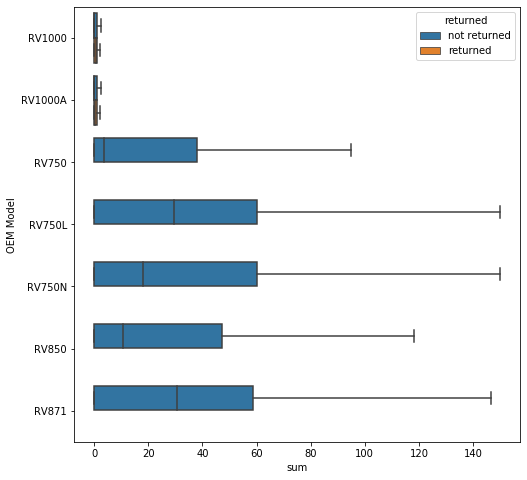

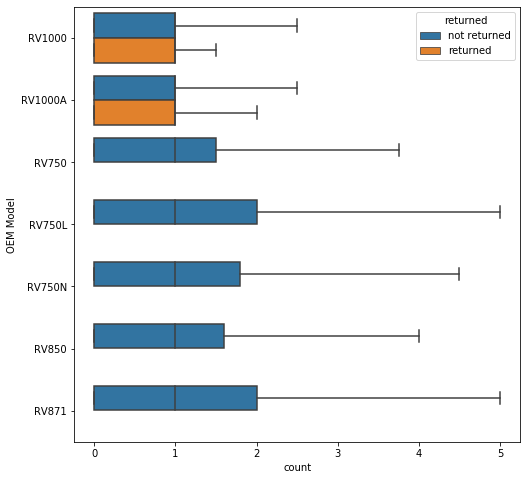

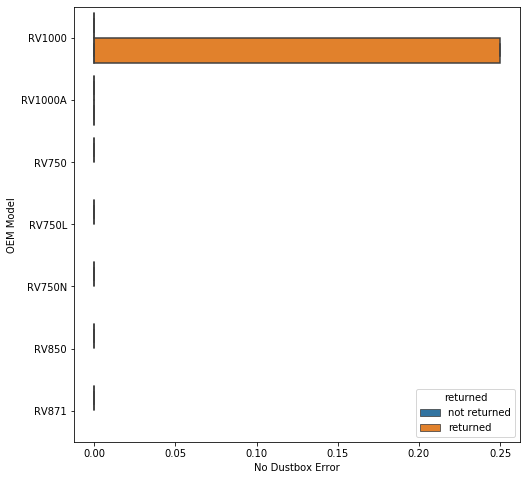

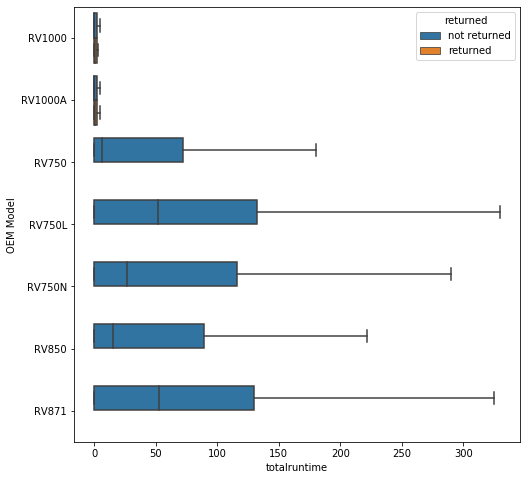

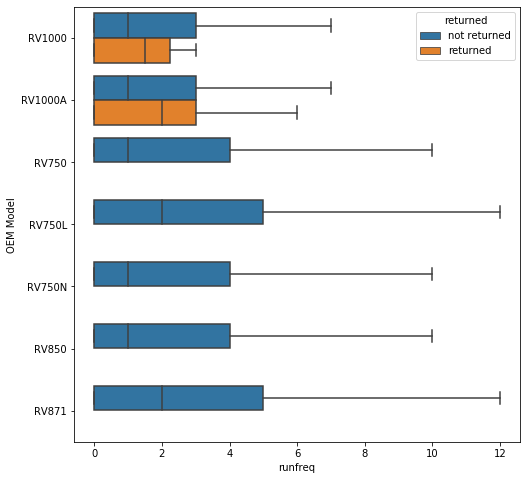

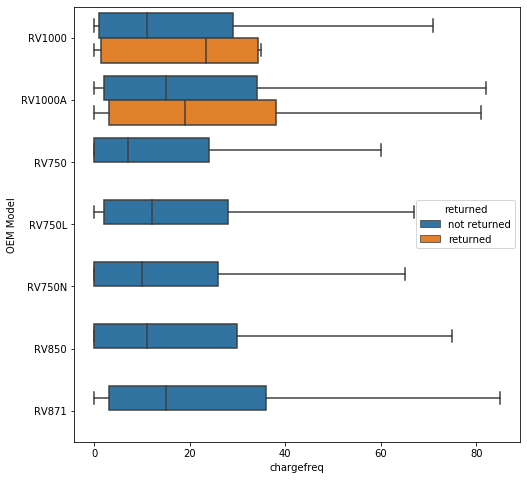

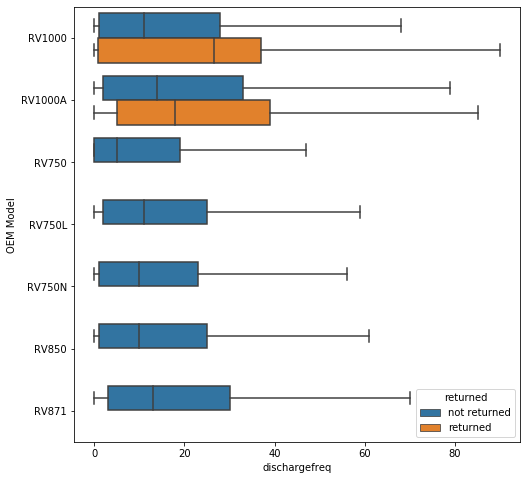

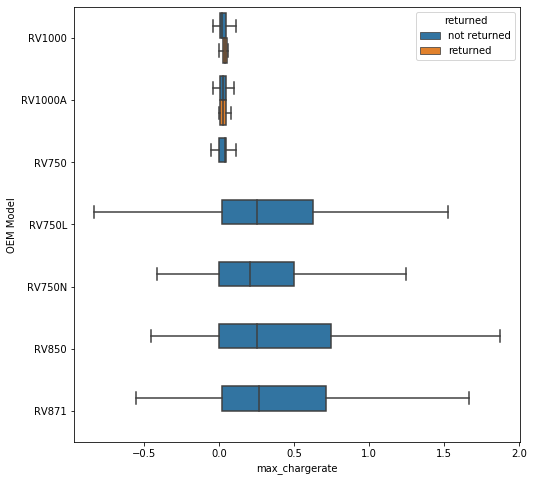

/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


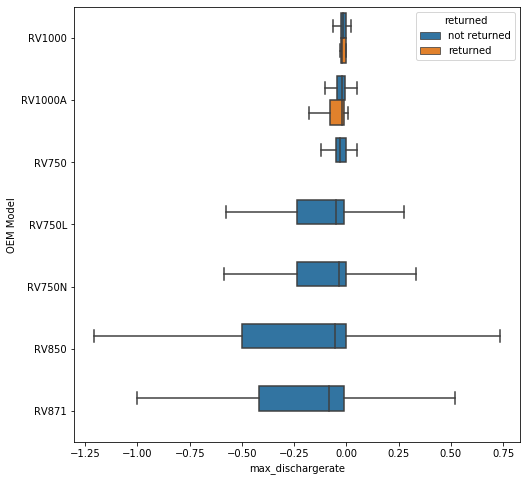

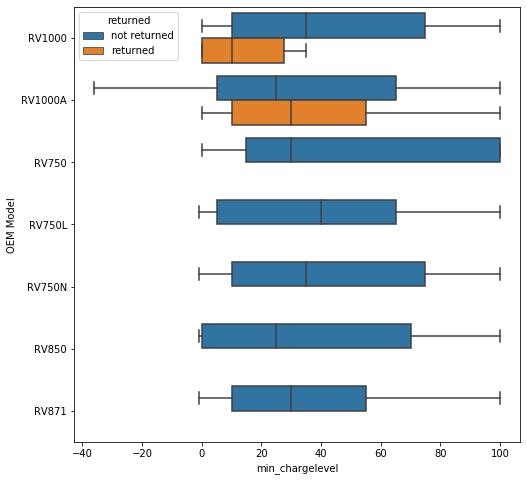

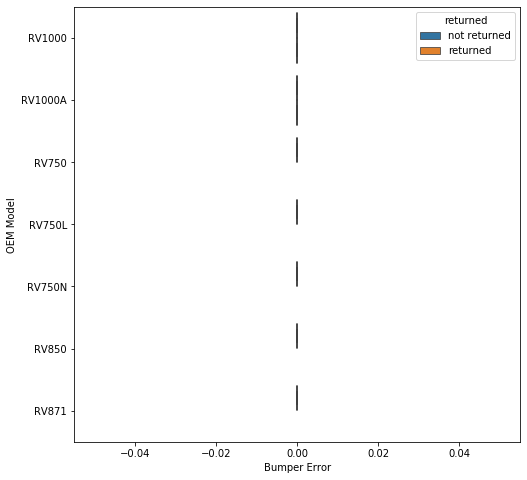

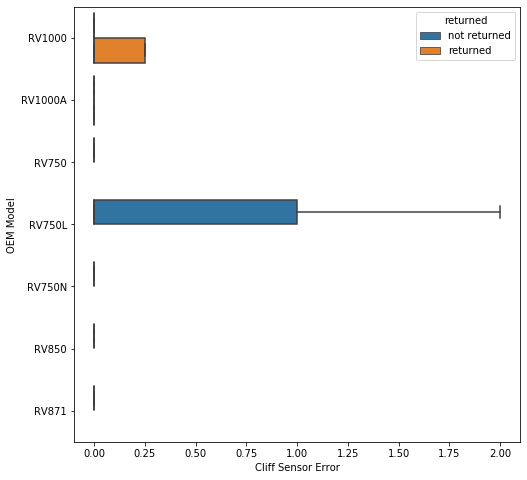

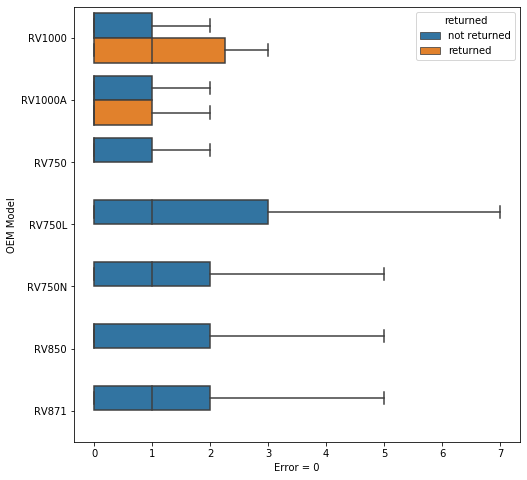

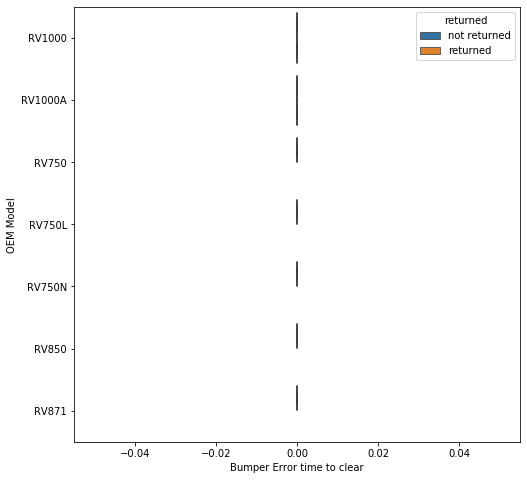

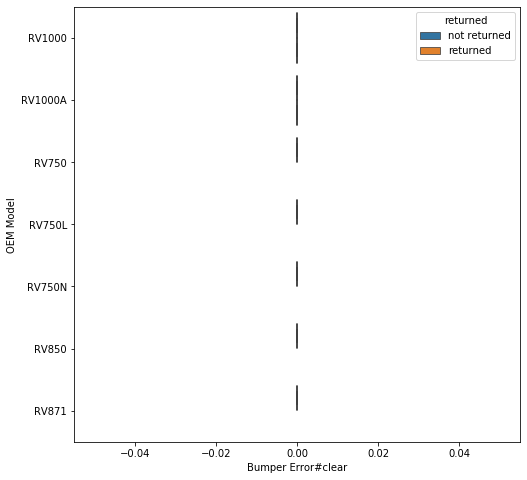

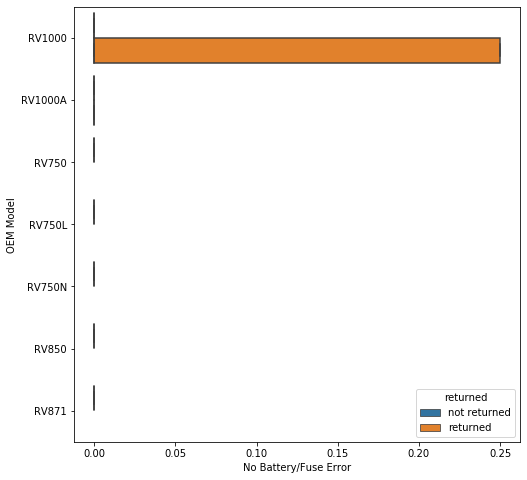

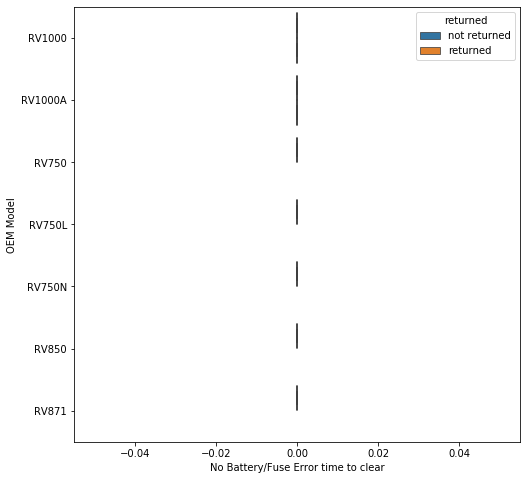

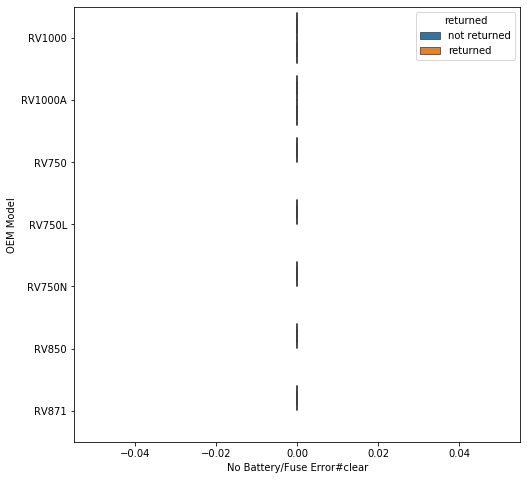

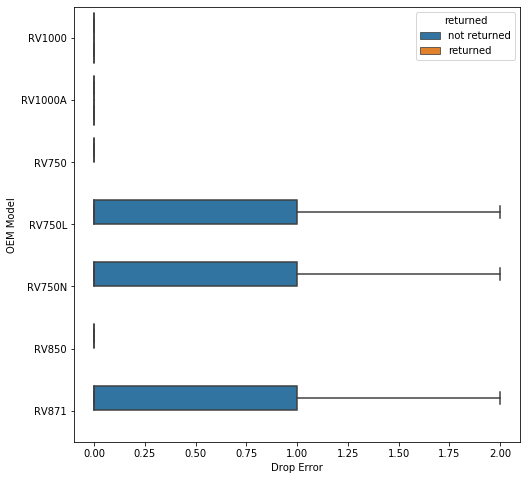

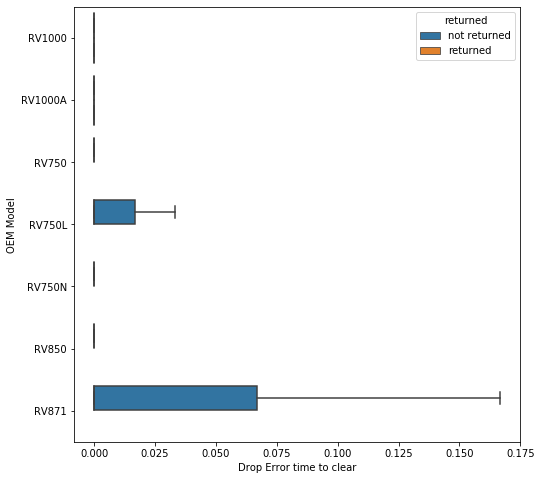

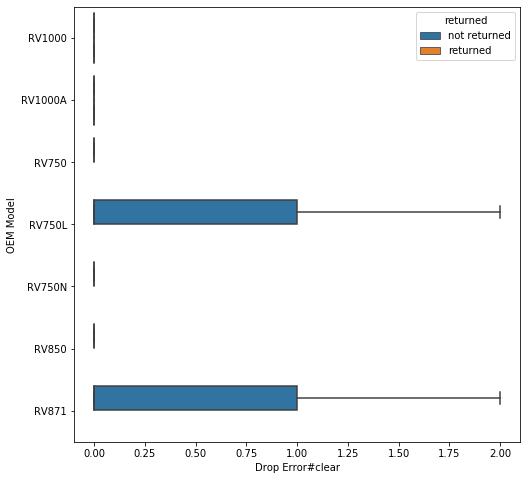

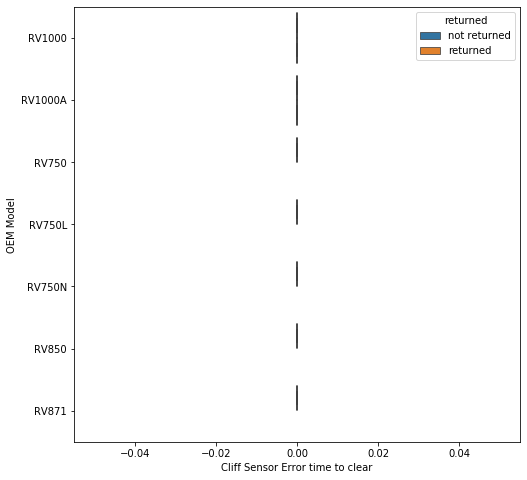

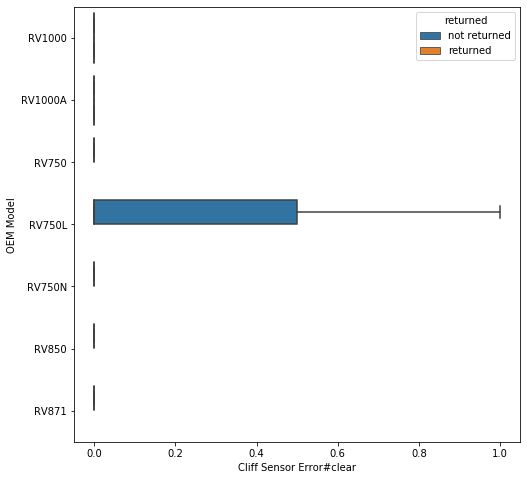

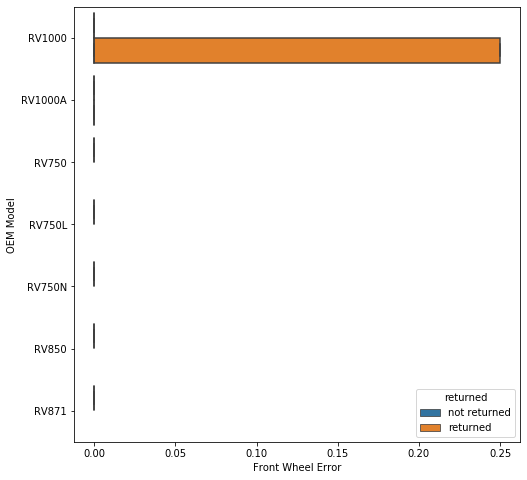

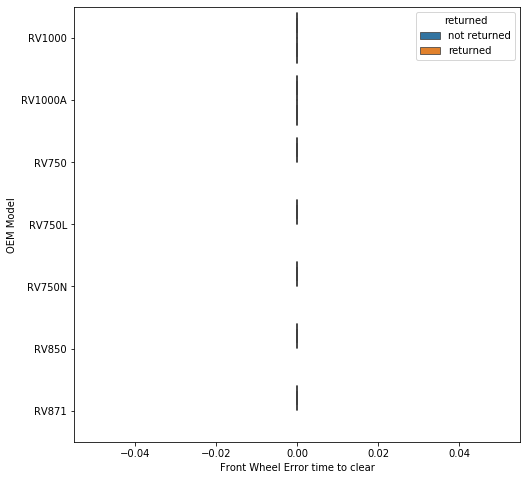

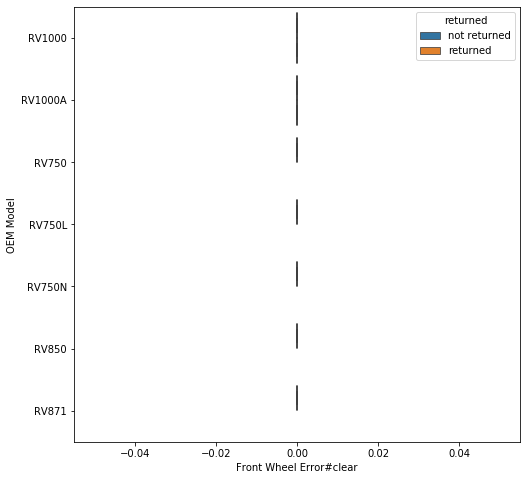

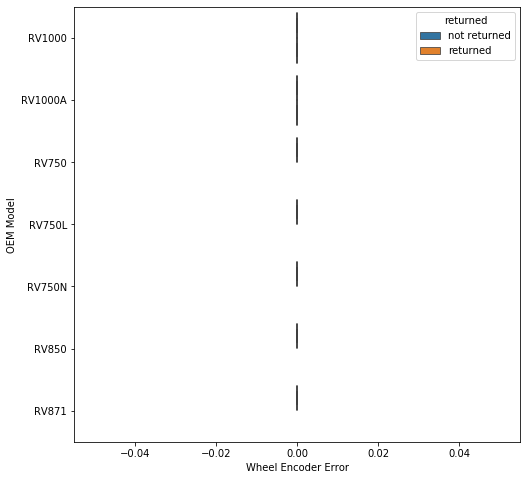

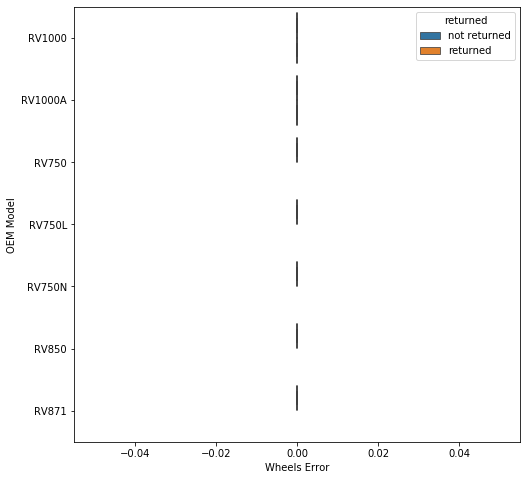

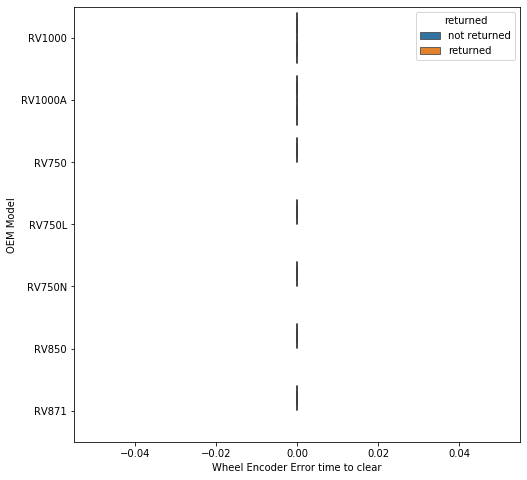

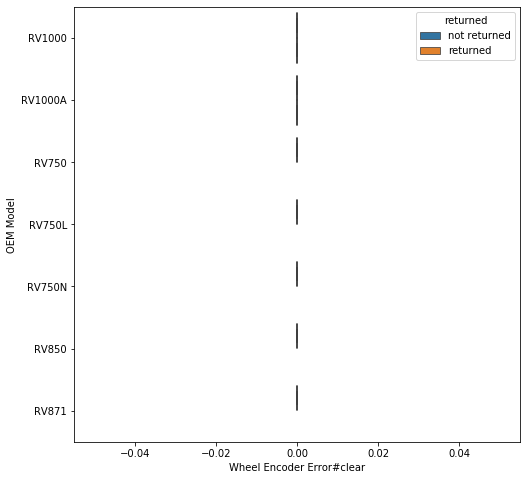

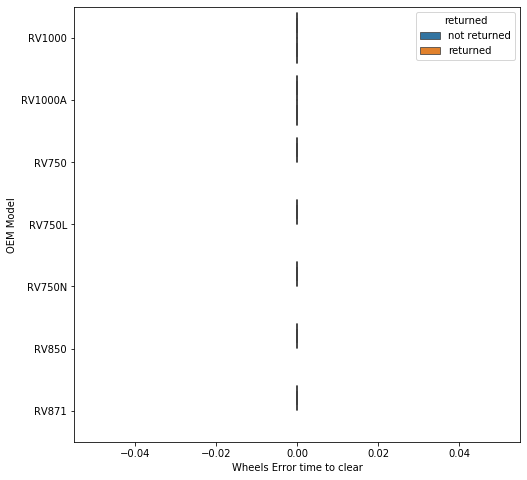

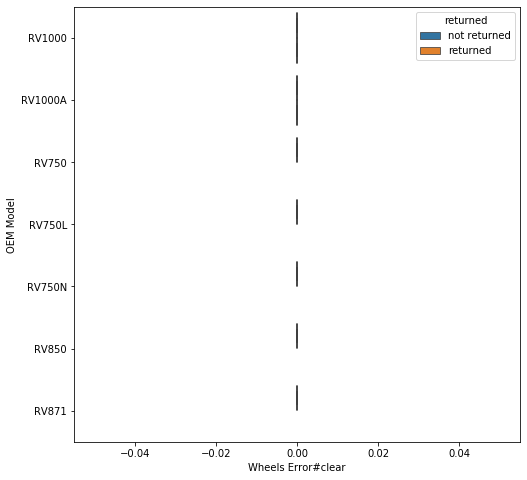

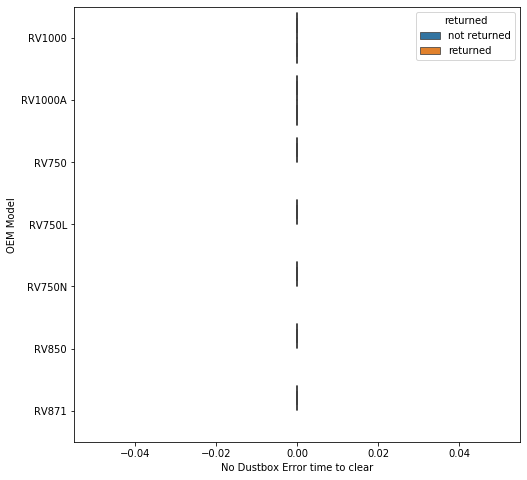

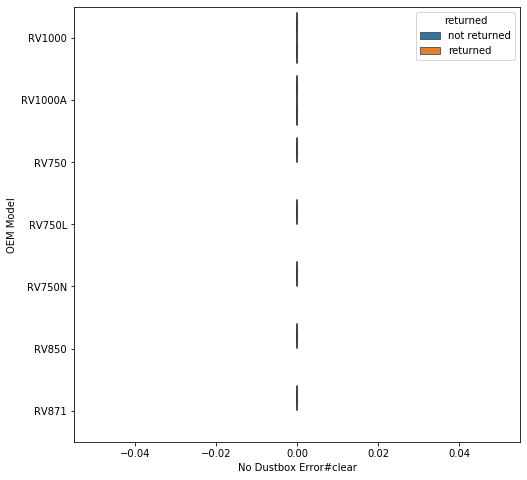

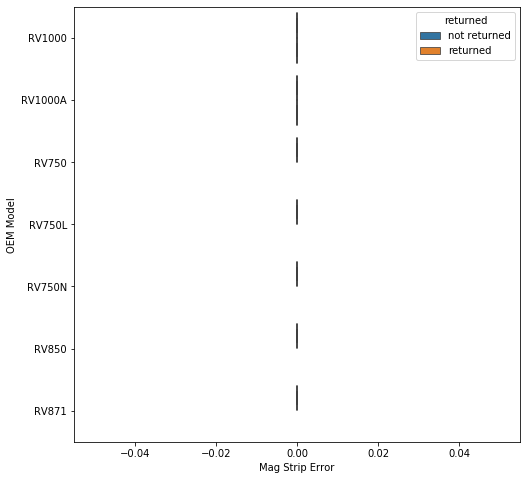

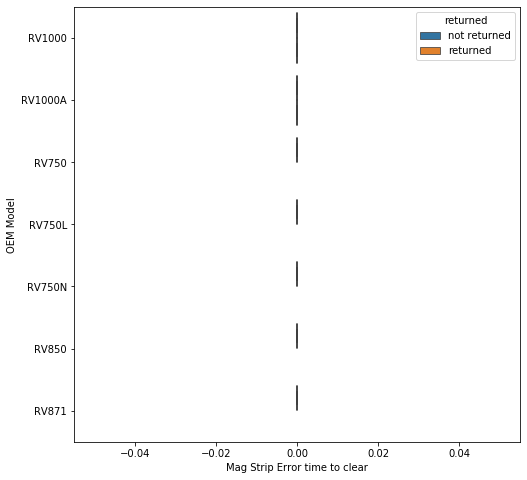

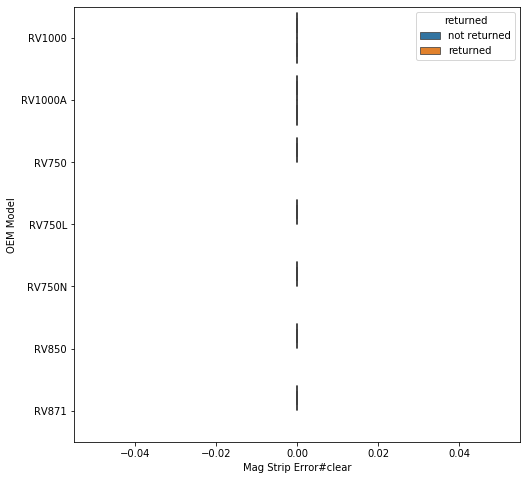

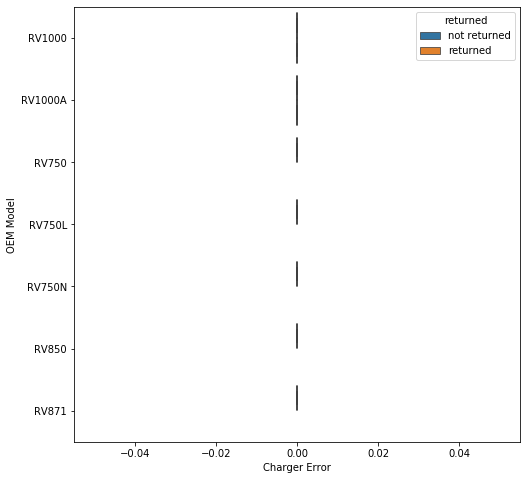

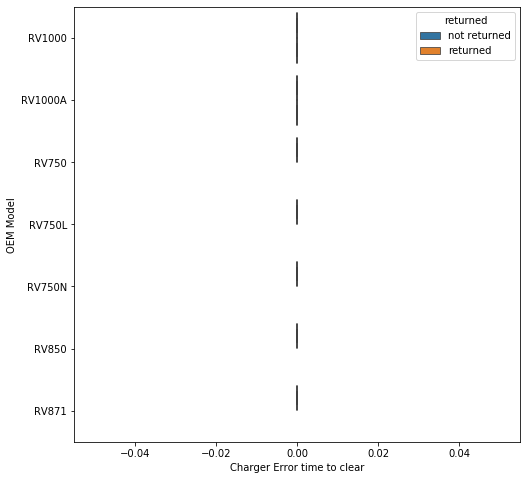

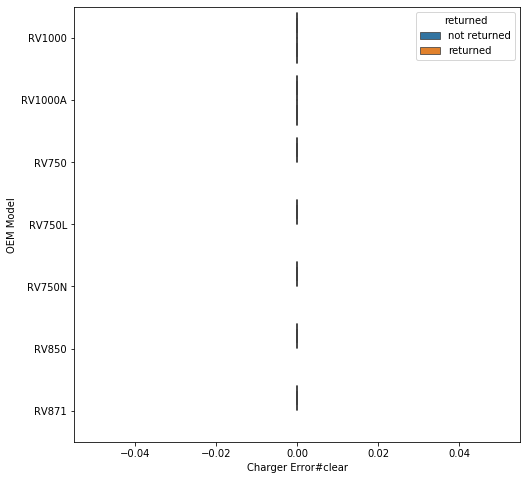

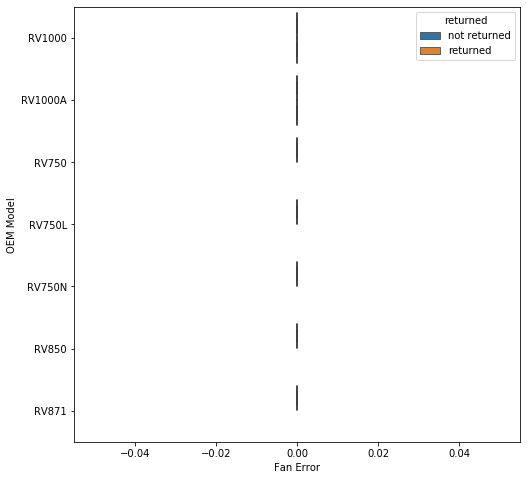

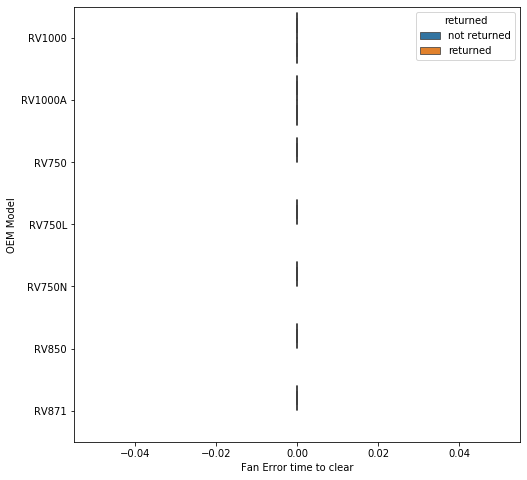

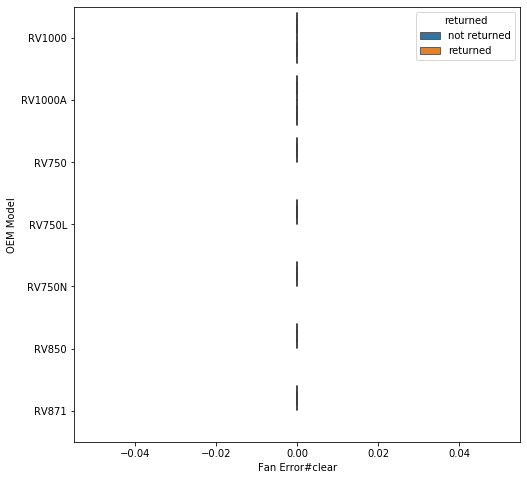

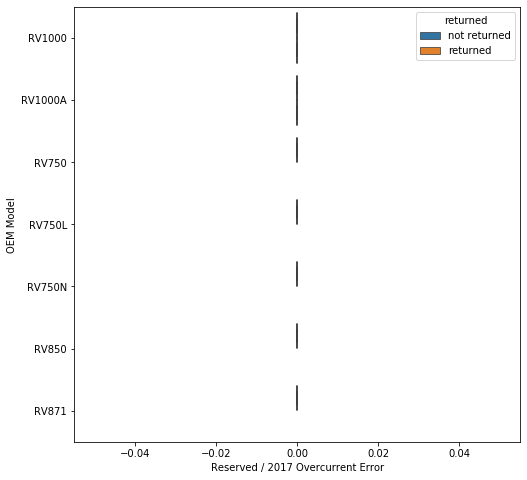

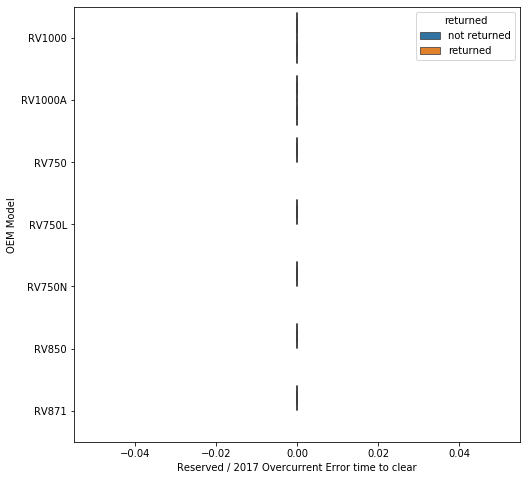

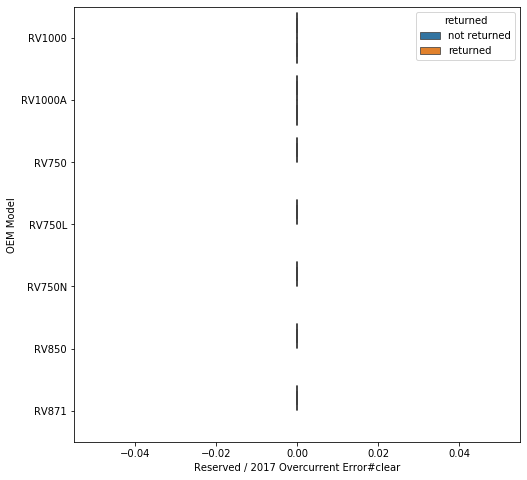

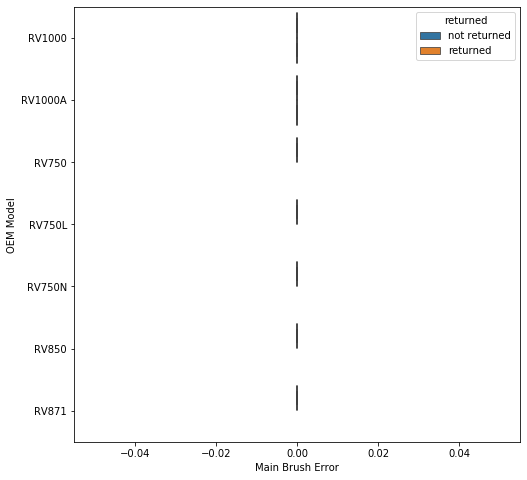

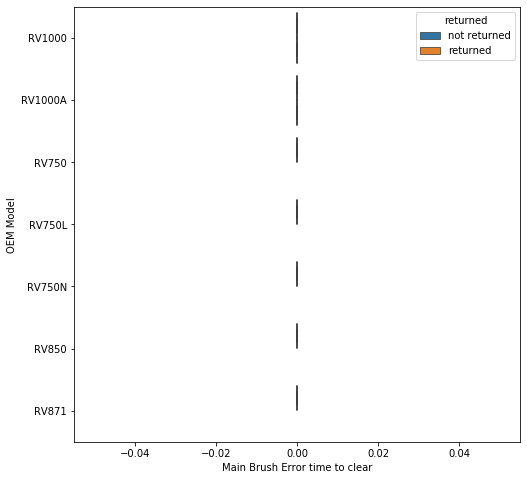

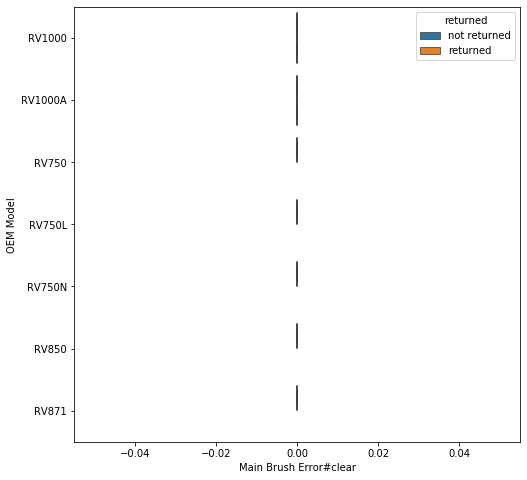

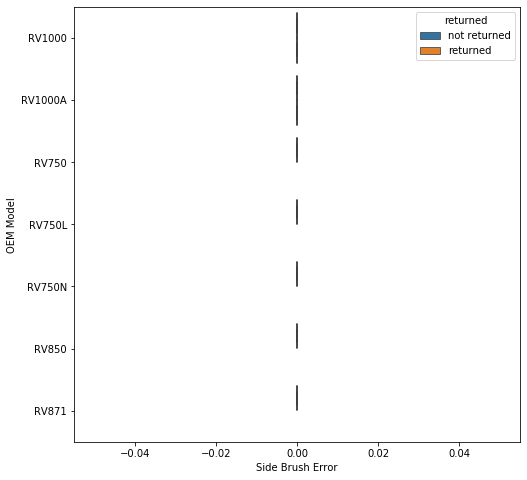

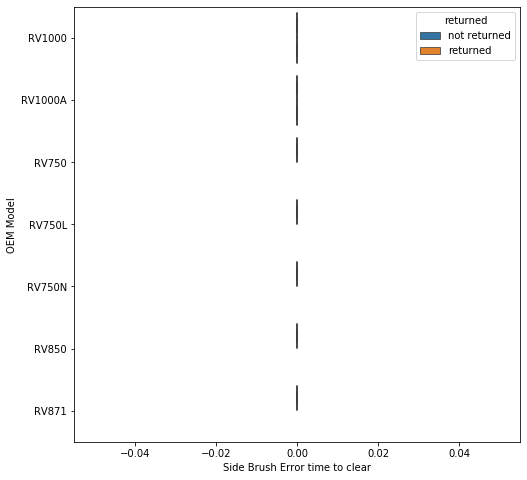

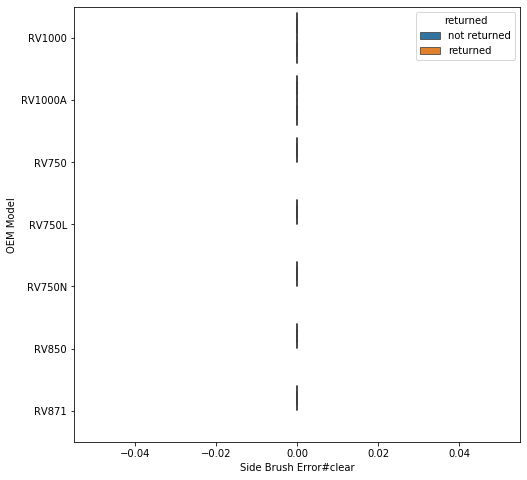

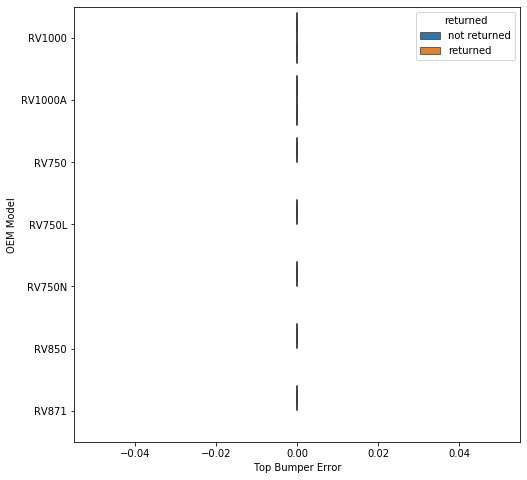

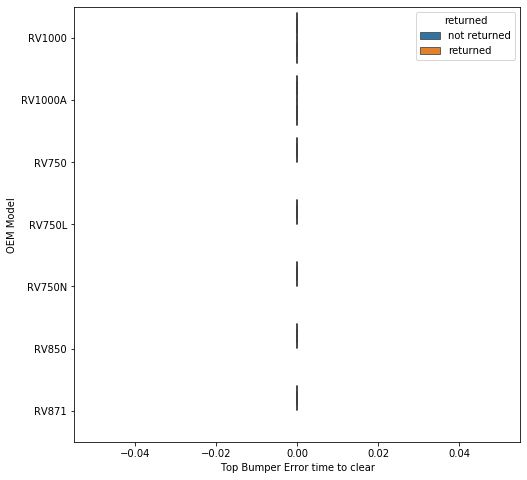

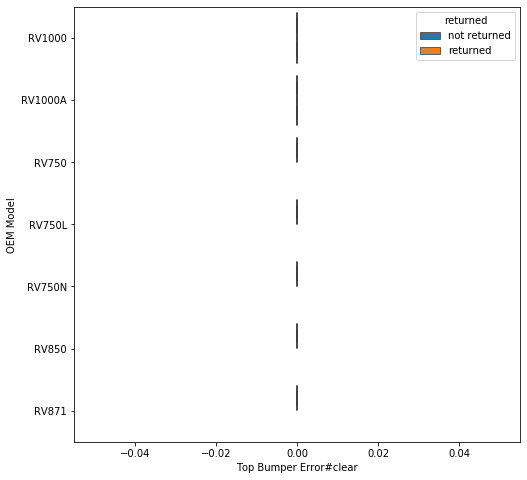

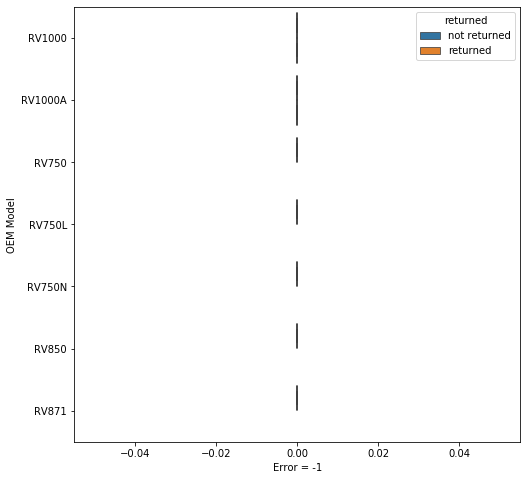

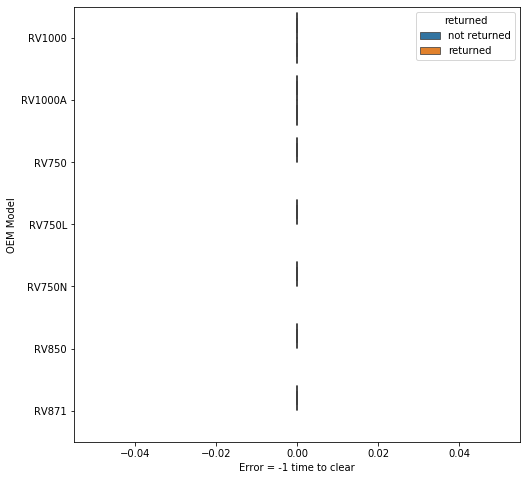

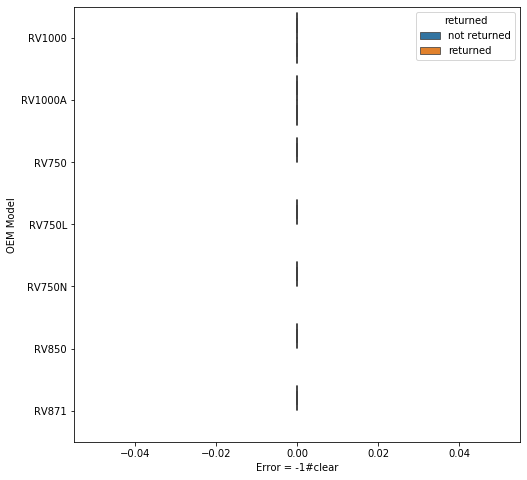

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in ['sum', 'count', 'No Dustbox Error',
       'totalruntime', 'runfreq', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'max_dischargerate', 'min_chargelevel',
       'Bumper Error', 'Cliff Sensor Error', 'Error = 0',
       'Bumper Error time to clear', 'Bumper Error#clear',
       'No Battery/Fuse Error', 'No Battery/Fuse Error time to clear',
       'No Battery/Fuse Error#clear', 'Drop Error', 'Drop Error time to clear',
       'Drop Error#clear', 'Cliff Sensor Error time to clear',
       'Cliff Sensor Error#clear', 'Front Wheel Error',
       'Front Wheel Error time to clear', 'Front Wheel Error#clear',
       'Wheel Encoder Error', 'Wheels Error',
       'Wheel Encoder Error time to clear', 'Wheel Encoder Error#clear',
       'Wheels Error time to clear', 'Wheels Error#clear',
       'No Dustbox Error time to clear', 'No Dustbox Error#clear',
       'Mag Strip Error', 'Mag Strip Error time to clear',
       'Mag Strip Error#clear', 'Charger Error', 'Charger Error time to clear',
       'Charger Error#clear', 'Fan Error', 'Fan Error time to clear',
       'Fan Error#clear', 'Reserved / 2017 Overcurrent Error',
       'Reserved / 2017 Overcurrent Error time to clear',
       'Reserved / 2017 Overcurrent Error#clear', 'Main Brush Error',
       'Main Brush Error time to clear', 'Main Brush Error#clear',
       'Side Brush Error', 'Side Brush Error time to clear',
       'Side Brush Error#clear', 'Top Bumper Error',
       'Top Bumper Error time to clear', 'Top Bumper Error#clear',
       'Error = -1', 'Error = -1 time to clear', 'Error = -1#clear']:
    plt.figure(figsize=(8,8))
    sns.boxplot(x=i,y='OEM Model',hue='returned',data=part1[(part1['OEM Model']!='RV750R')].fillna(0),showfliers=False)
    plt.show()

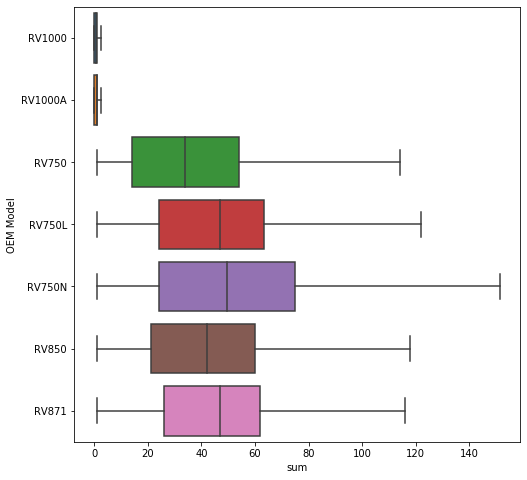

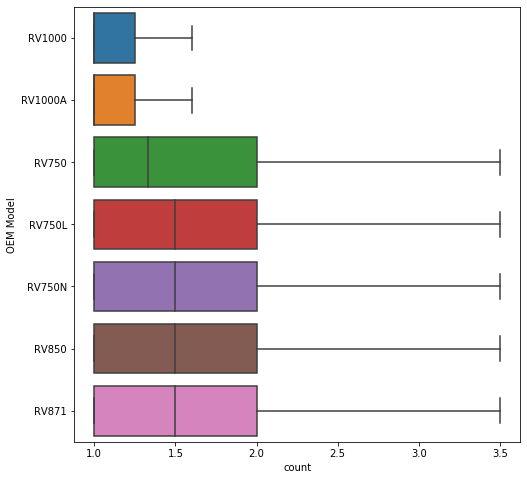

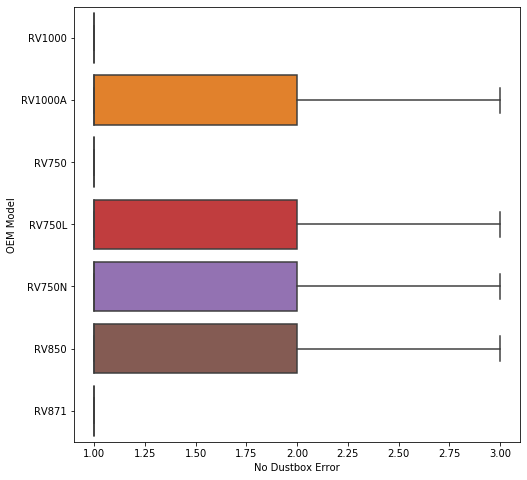

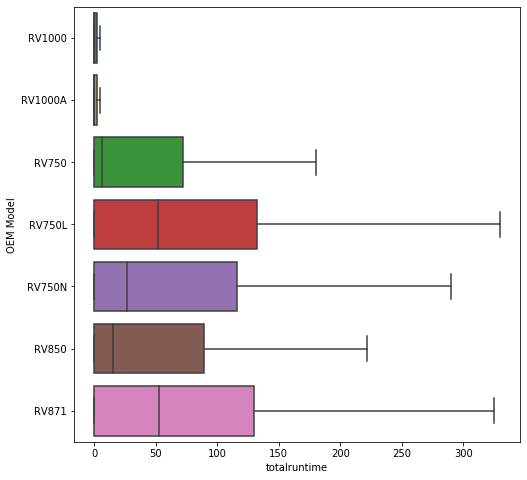

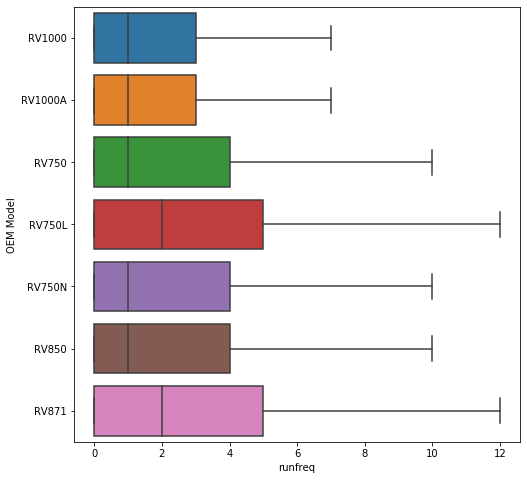

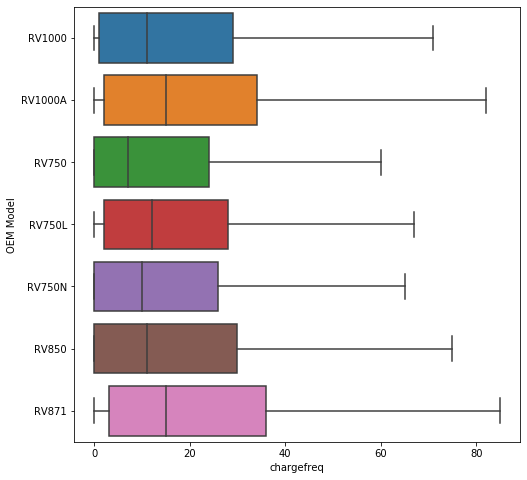

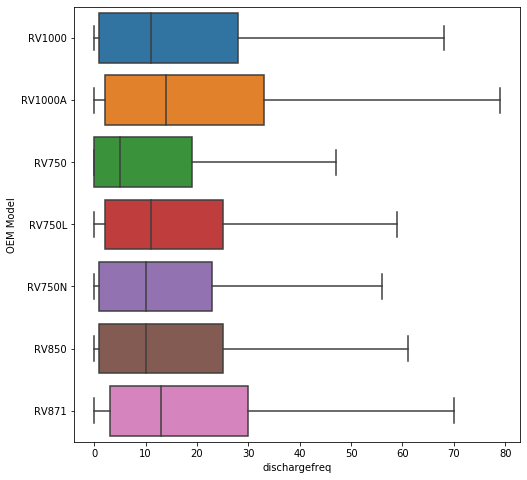

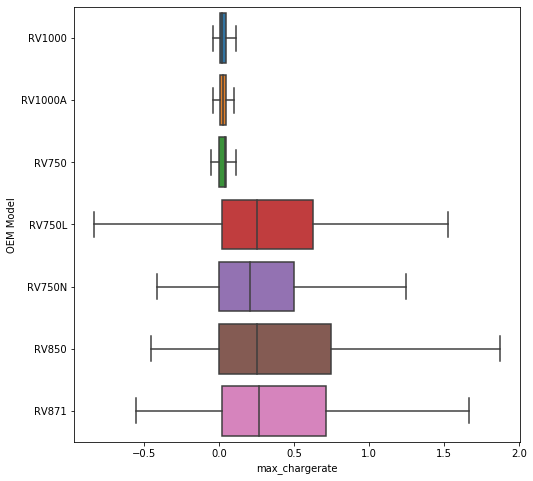

/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


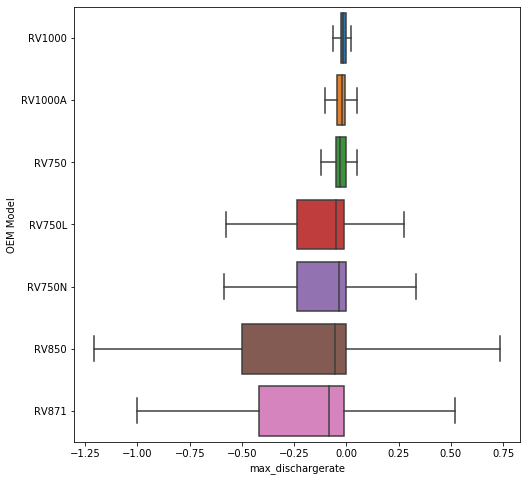

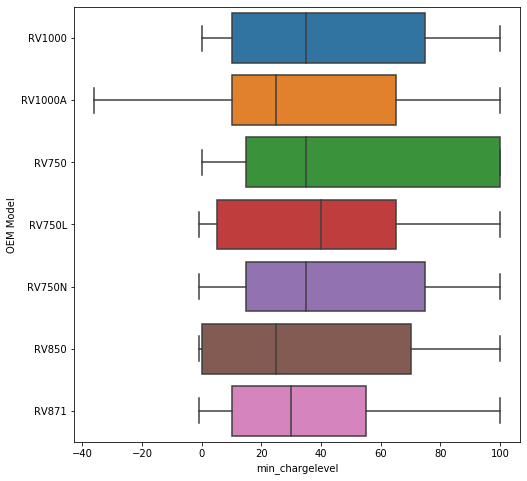

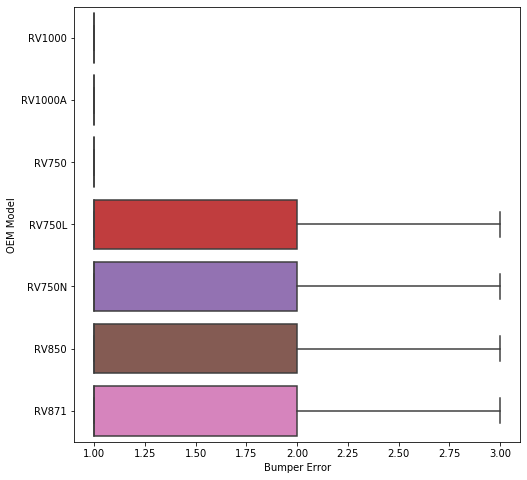

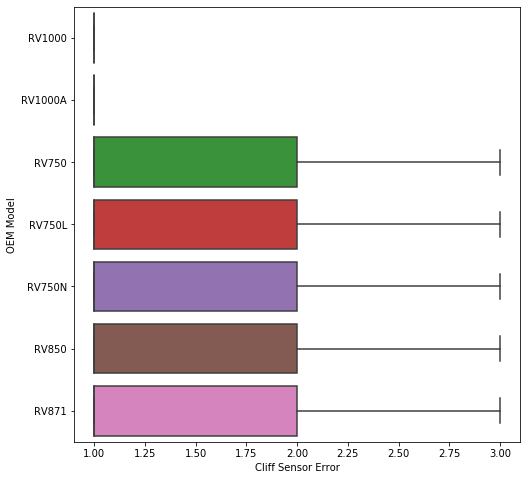

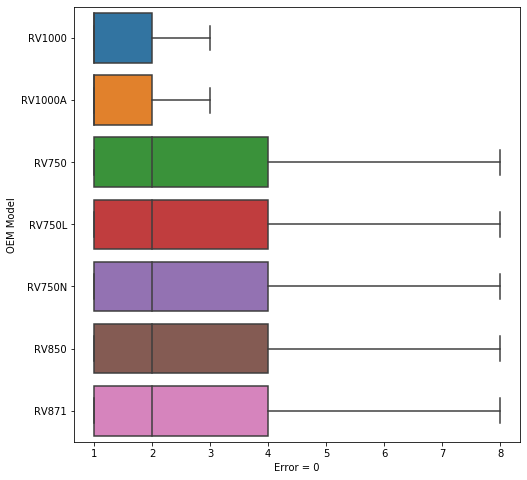

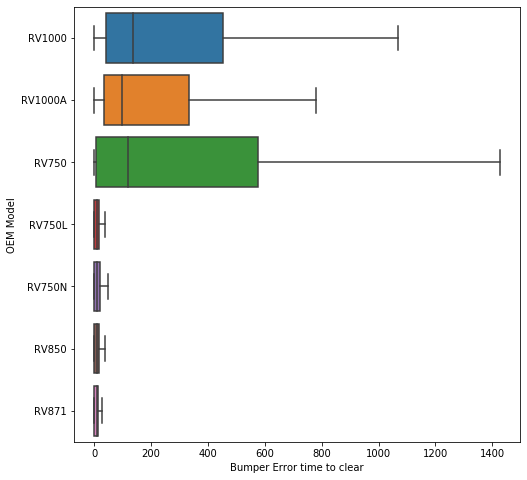

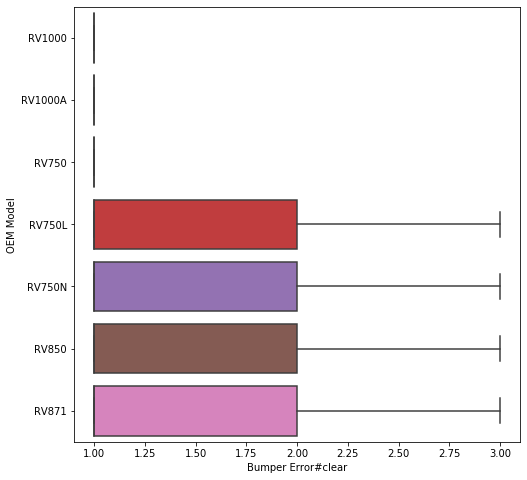

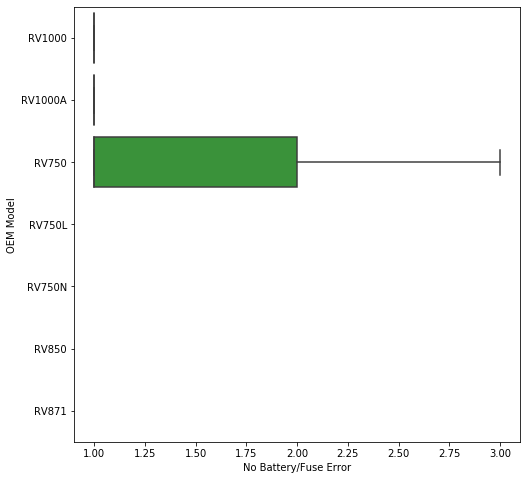

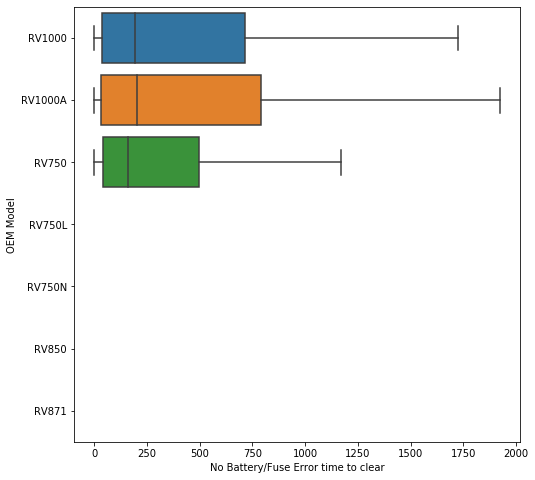

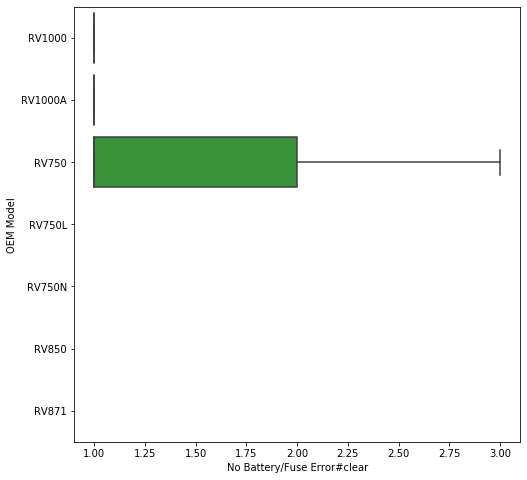

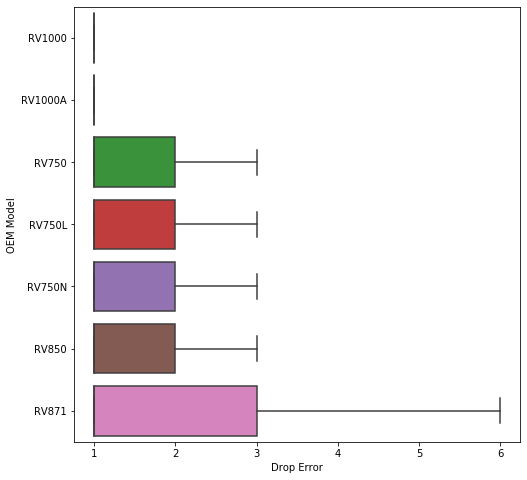

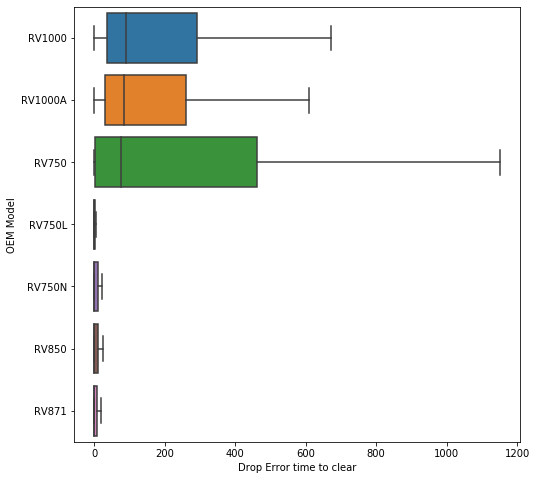

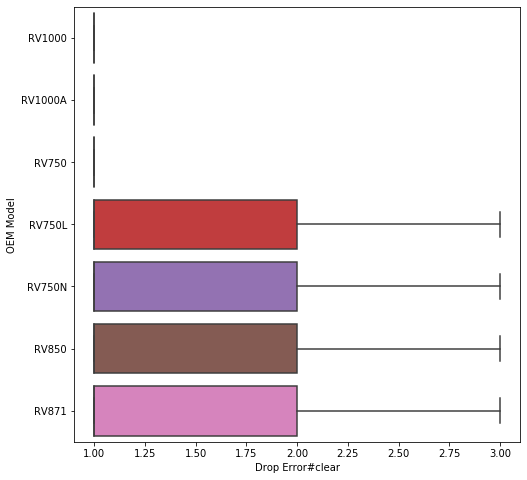

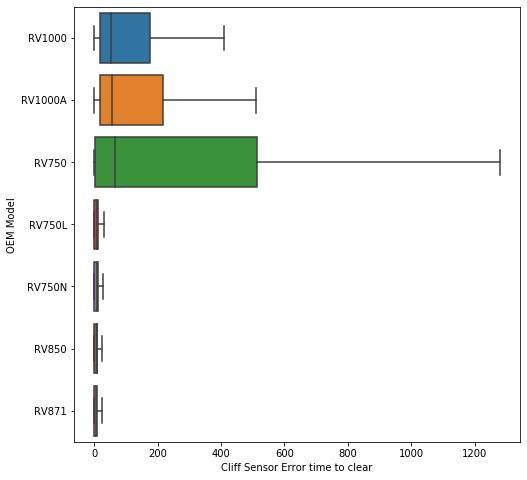

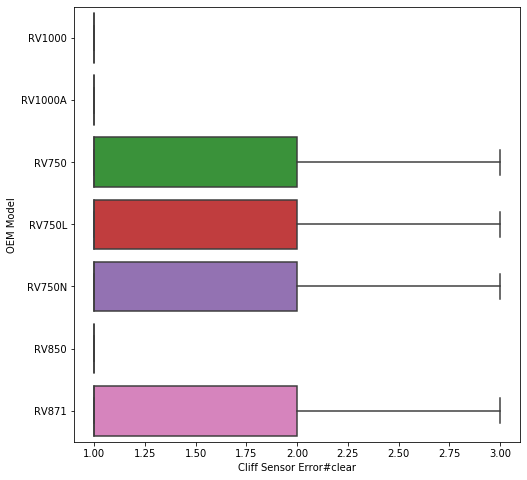

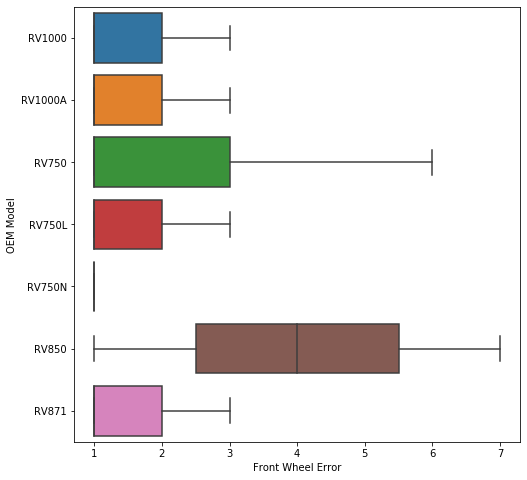

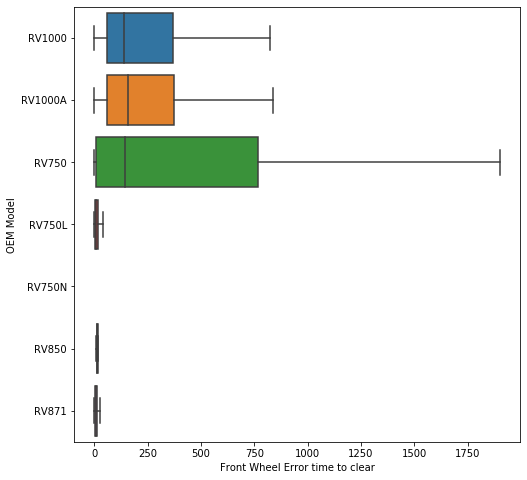

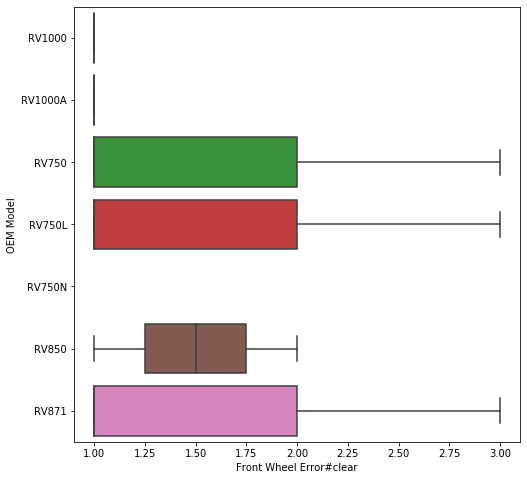

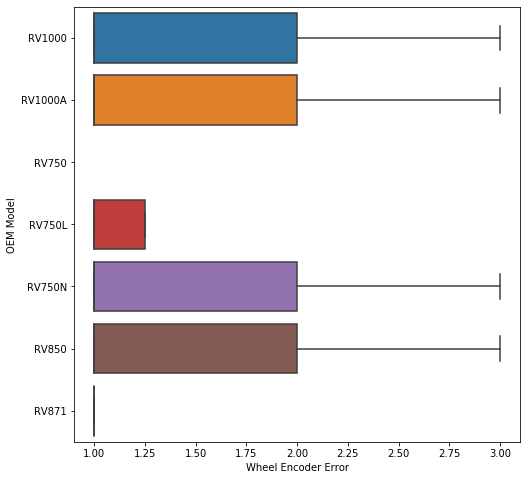

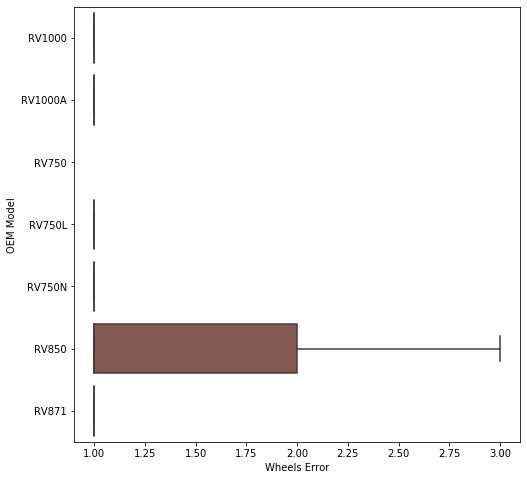

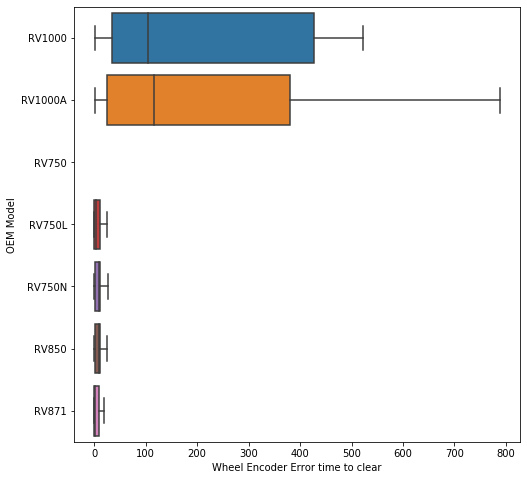

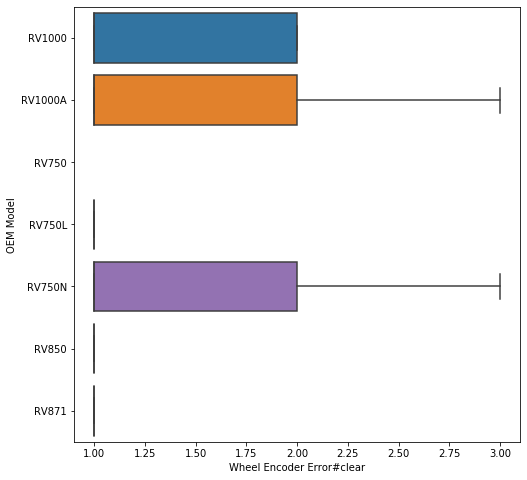

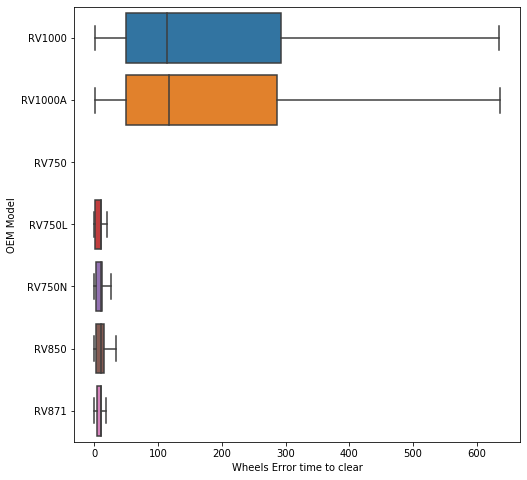

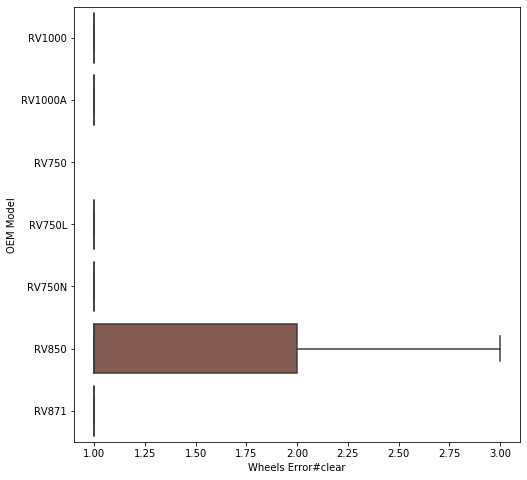

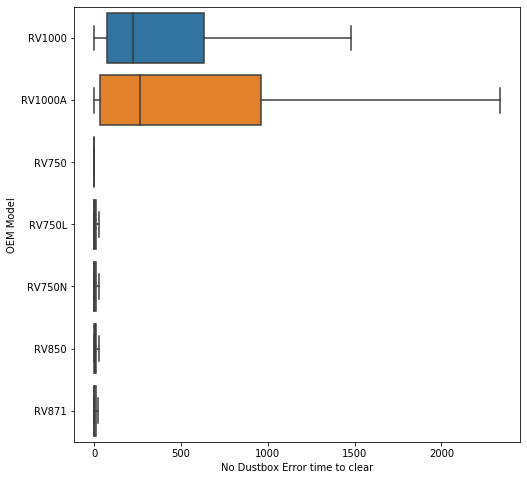

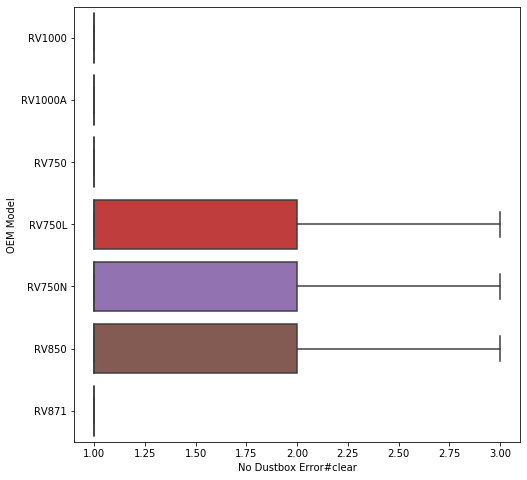

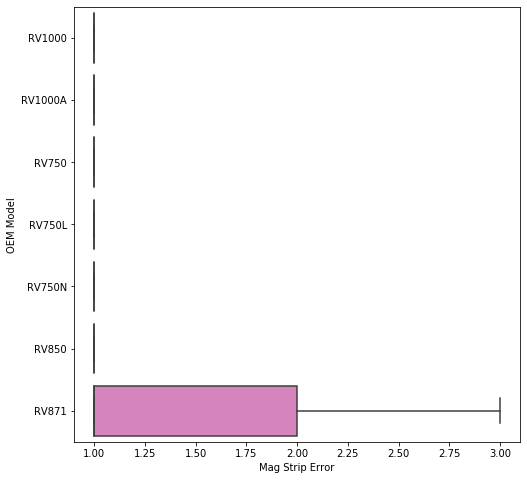

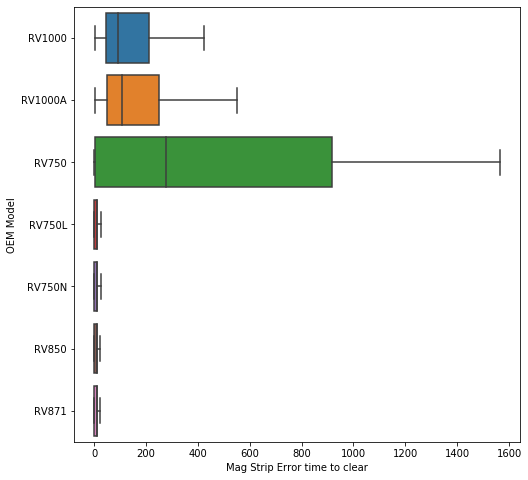

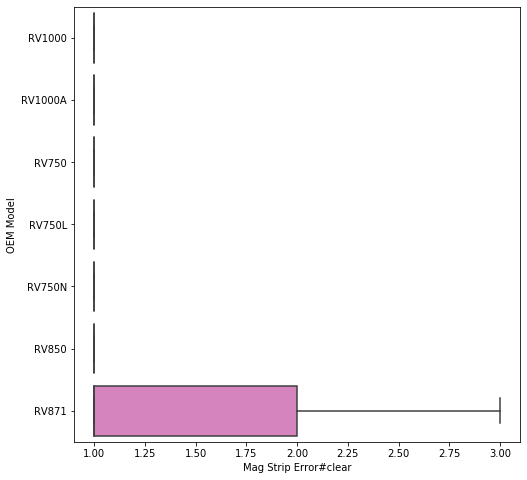

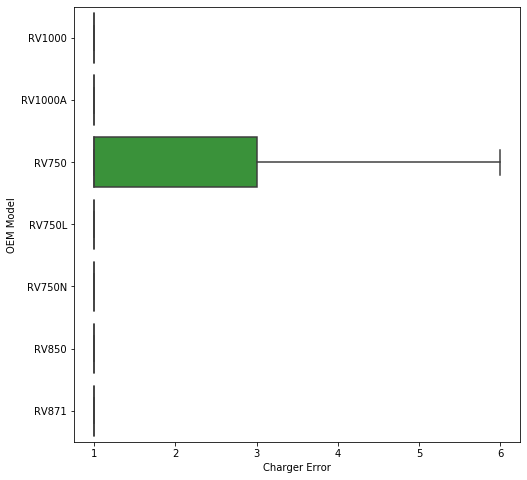

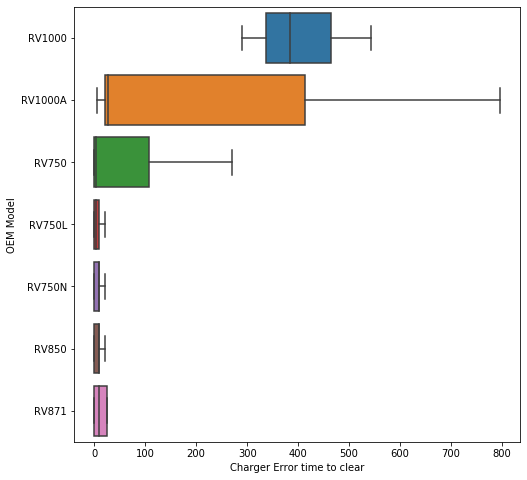

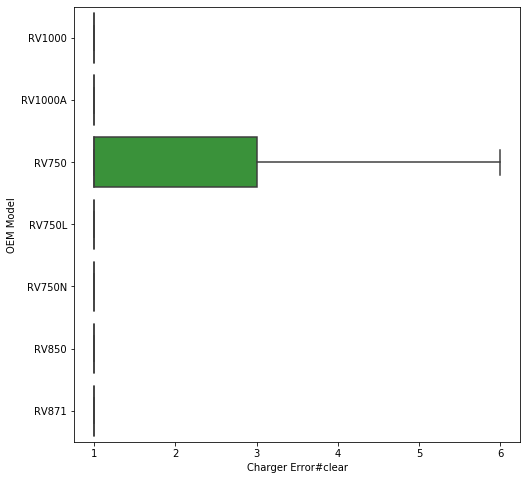

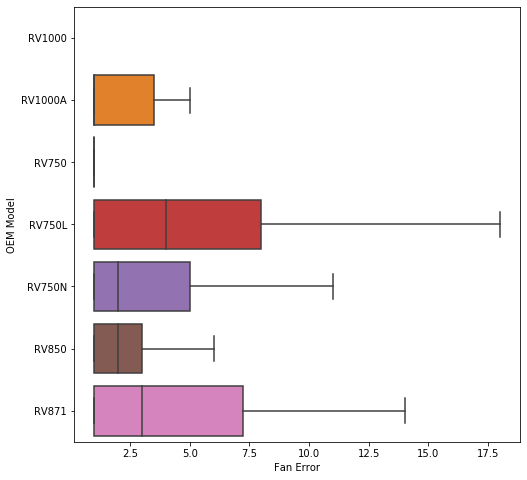

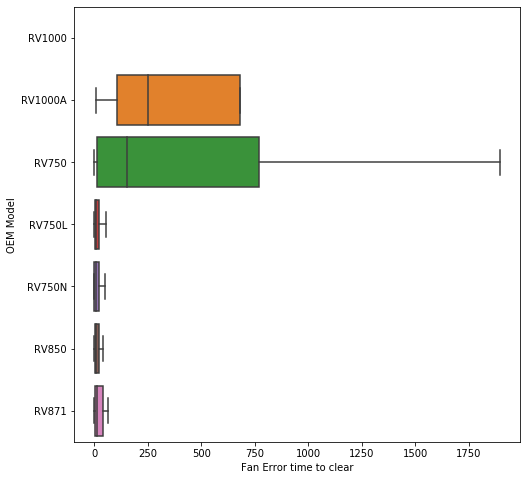

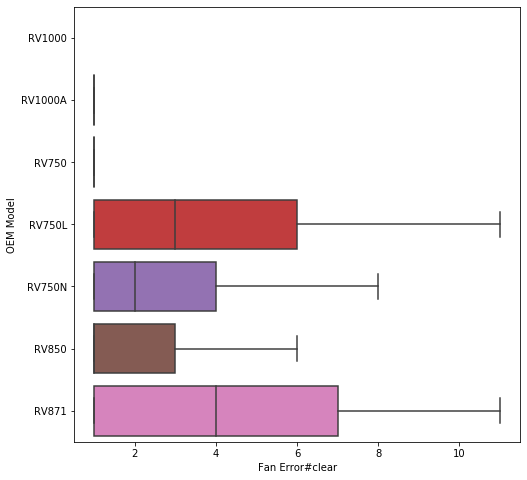

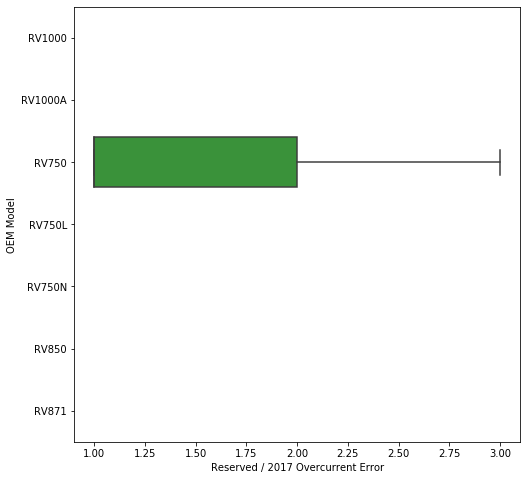

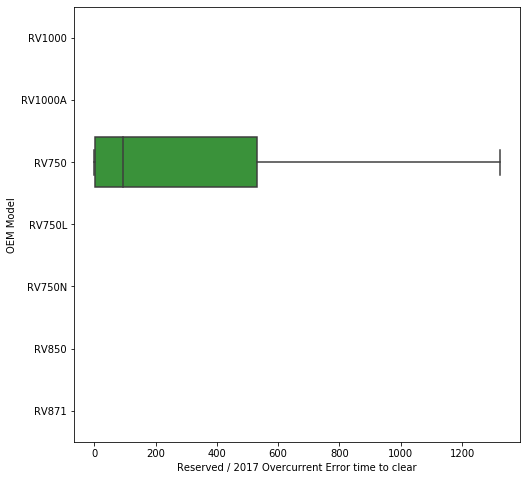

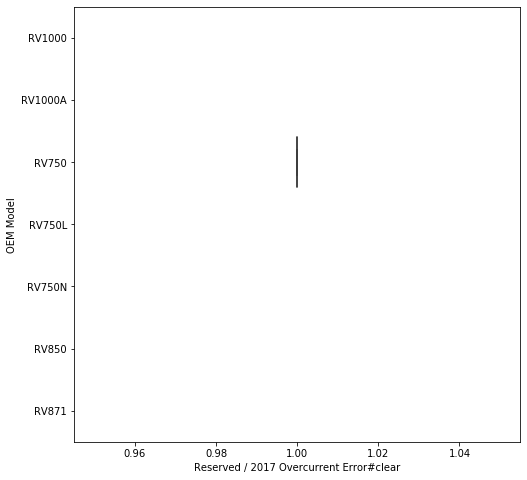

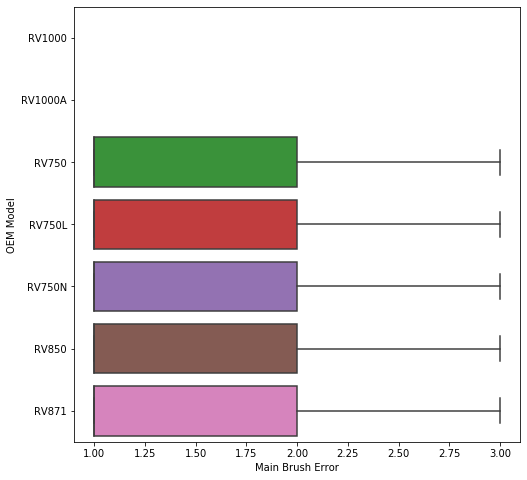

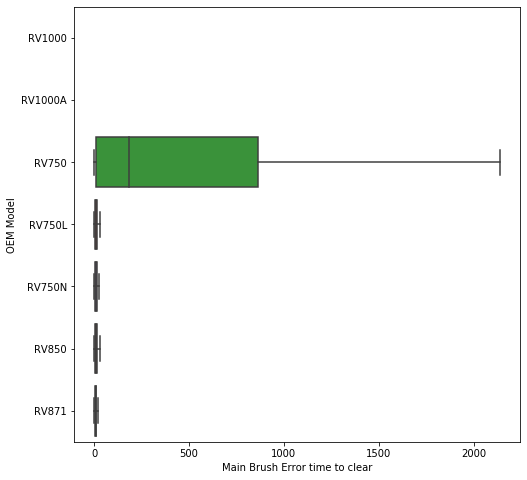

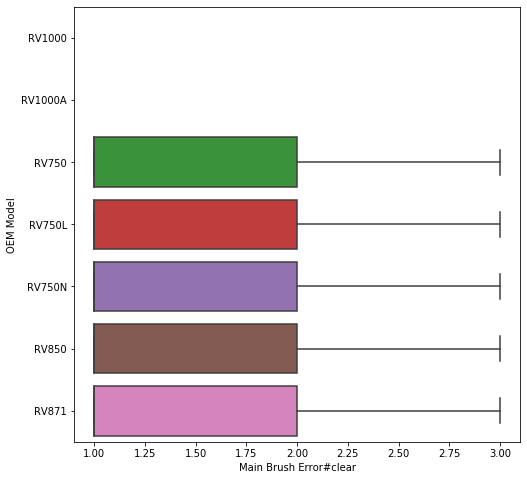

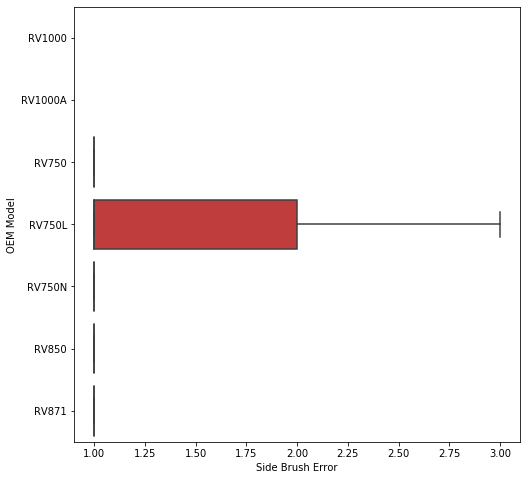

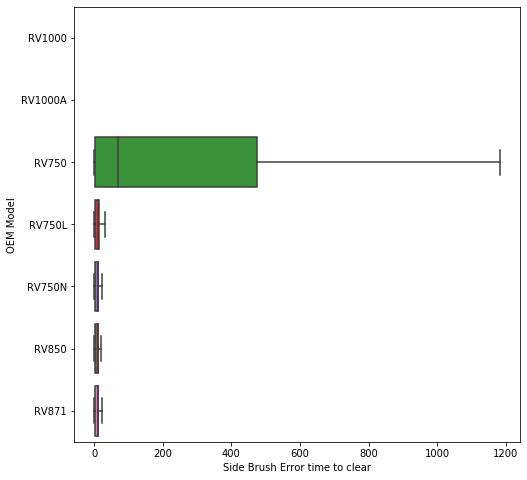

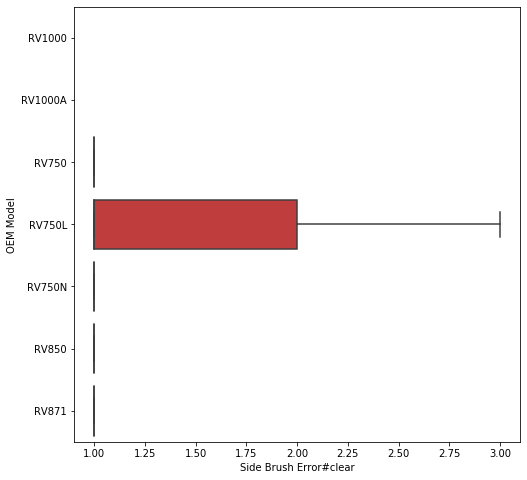

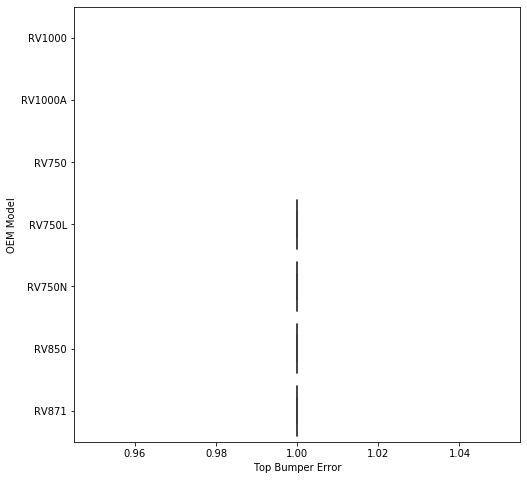

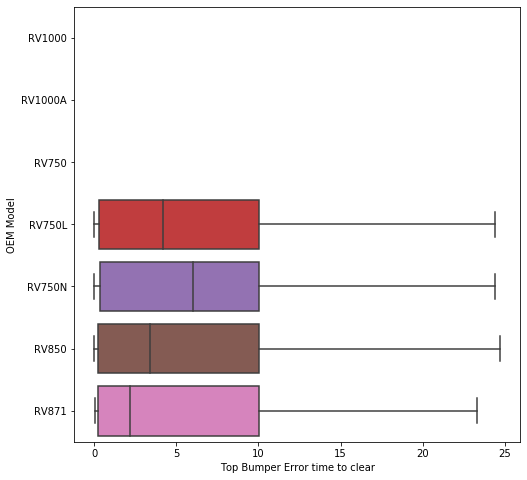

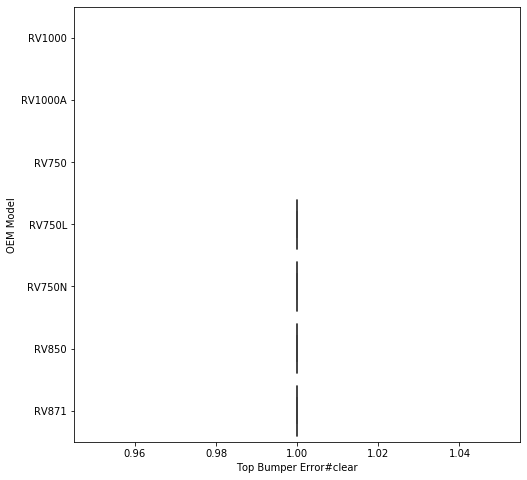

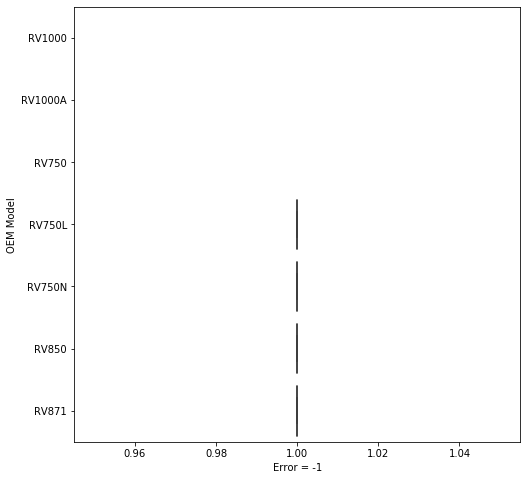

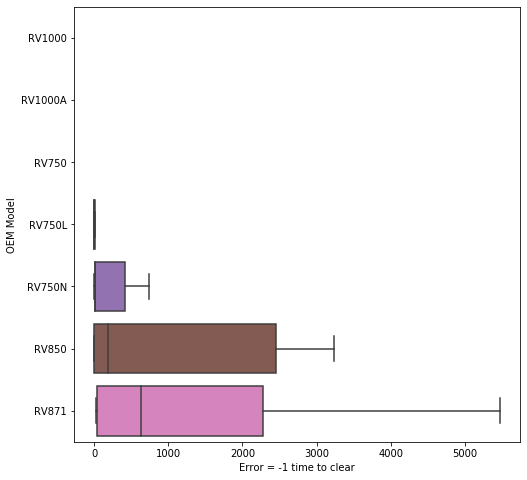

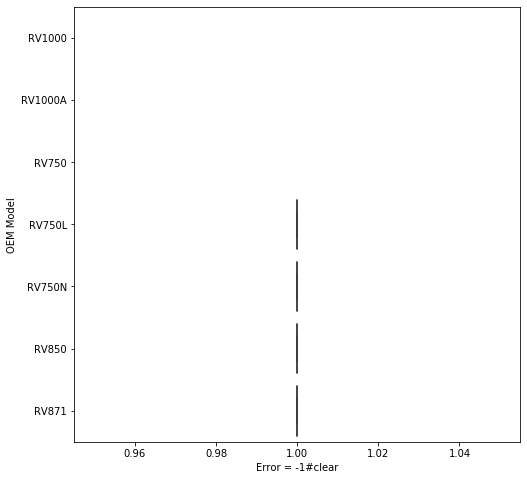

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in ['sum', 'count', 'No Dustbox Error',
       'totalruntime', 'runfreq', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'max_dischargerate', 'min_chargelevel',
       'Bumper Error', 'Cliff Sensor Error', 'Error = 0',
       'Bumper Error time to clear', 'Bumper Error#clear',
       'No Battery/Fuse Error', 'No Battery/Fuse Error time to clear',
       'No Battery/Fuse Error#clear', 'Drop Error', 'Drop Error time to clear',
       'Drop Error#clear', 'Cliff Sensor Error time to clear',
       'Cliff Sensor Error#clear', 'Front Wheel Error',
       'Front Wheel Error time to clear', 'Front Wheel Error#clear',
       'Wheel Encoder Error', 'Wheels Error',
       'Wheel Encoder Error time to clear', 'Wheel Encoder Error#clear',
       'Wheels Error time to clear', 'Wheels Error#clear',
       'No Dustbox Error time to clear', 'No Dustbox Error#clear',
       'Mag Strip Error', 'Mag Strip Error time to clear',
       'Mag Strip Error#clear', 'Charger Error', 'Charger Error time to clear',
       'Charger Error#clear', 'Fan Error', 'Fan Error time to clear',
       'Fan Error#clear', 'Reserved / 2017 Overcurrent Error',
       'Reserved / 2017 Overcurrent Error time to clear',
       'Reserved / 2017 Overcurrent Error#clear', 'Main Brush Error',
       'Main Brush Error time to clear', 'Main Brush Error#clear',
       'Side Brush Error', 'Side Brush Error time to clear',
       'Side Brush Error#clear', 'Top Bumper Error',
       'Top Bumper Error time to clear', 'Top Bumper Error#clear',
       'Error = -1', 'Error = -1 time to clear', 'Error = -1#clear']:
    plt.figure(figsize=(8,8))
    sns.boxplot(x=i,y='OEM Model',data=part1[part1['OEM Model']!='RV750R'],showfliers=False)
    plt.show()

In [202]:
part1['OEM Model']!='RV750R'.value_counts()

RV1000A    88894
RV750      81566
RV850      76713
RV750N     72746
RV750L     46031
RV1000     20104
RV871       5293
RV750R        24
Name: OEM Model, dtype: int64

In [221]:
part1.columns

Index(['OEM Model', 'DSN', 'level_2', 'sum', 'count', 'No Dustbox Error',
       'totalruntime', 'runfreq', 'online', 'chargefreq', 'dischargefreq',
       'max_chargerate', 'max_dischargerate', 'min_chargelevel',
       'Bumper Error', 'Cliff Sensor Error', 'Error = 0',
       'Bumper Error time to clear', 'Bumper Error#clear',
       'No Battery/Fuse Error', 'No Battery/Fuse Error time to clear',
       'No Battery/Fuse Error#clear', 'Drop Error', 'Drop Error time to clear',
       'Drop Error#clear', 'Cliff Sensor Error time to clear',
       'Cliff Sensor Error#clear', 'Front Wheel Error',
       'Front Wheel Error time to clear', 'Front Wheel Error#clear',
       'Wheel Encoder Error', 'Wheels Error',
       'Wheel Encoder Error time to clear', 'Wheel Encoder Error#clear',
       'Wheels Error time to clear', 'Wheels Error#clear',
       'No Dustbox Error time to clear', 'No Dustbox Error#clear',
       'Mag Strip Error', 'Mag Strip Error time to clear',
       'Mag Strip Error#cl

In [229]:
part1['sum_error']=part1[['No Dustbox Error',
       'Bumper Error', 'Cliff Sensor Error', 
       
       'No Battery/Fuse Error', 
       'Drop Error', 
   
       'Front Wheel Error',
    
       'Wheel Encoder Error', 'Wheels Error',



       'Mag Strip Error', 'Charger Error',  'Fan Error',  'Reserved / 2017 Overcurrent Error',
       'Main Brush Error',
      
       'Side Brush Error','Top Bumper Error',
    
       'Error = -1']].sum(axis=1)

In [228]:
part1['time_to_clear_error']=part1[['Bumper Error time to clear',  'No Battery/Fuse Error time to clear',
        'Drop Error time to clear',
     'Cliff Sensor Error time to clear',
       
       'Front Wheel Error time to clear', 
       'Wheel Encoder Error time to clear', 
       'Wheels Error time to clear', 
       'No Dustbox Error time to clear',  'Mag Strip Error time to clear',
        'Charger Error time to clear',
       'Fan Error time to clear',
       
       'Reserved / 2017 Overcurrent Error time to clear',
       
       'Main Brush Error time to clear',  'Side Brush Error time to clear',
       
       'Top Bumper Error time to clear',  'Error = -1 time to clear']].mean(axis=1)

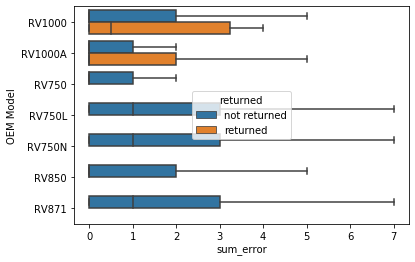

In [342]:
sns.boxplot(x='sum_error',y='OEM Model',hue='returned',data=part1[part1['OEM Model']!='RV750R'].fillna(0),showfliers=False)


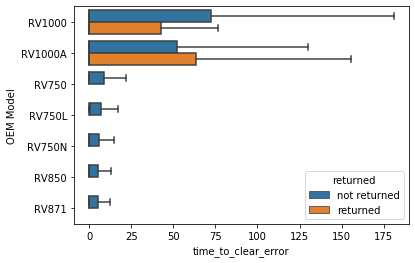

In [343]:
sns.boxplot(x='time_to_clear_error',y='OEM Model',hue='returned',data=part1[part1['OEM Model']!='RV750R'].fillna(0),showfliers=False)



In [239]:
#part1['OEM Model']=='RV1000'
#part1['OEM Model']=='RV1000A'

part1[((part1['totalruntime']==0) | (part1['totalruntime']>=100))&
((part1['max_chargerate']>=0.6)|
(part1['max_dischargerate']<=-0.5)|
(part1['min_chargelevel']<0))&
((part1['sum_error']>=3)|
(part1['time_to_clear_error']>=60))]

OEM Model              DSN  level_2         sum     count  \
34        RV1000  AC000W007209763        0    0.000000  2.000000   
564       RV1000  AC000W008115460        0    0.000000  2.000000   
673       RV1000  AC000W008118962        0    0.000000  1.000000   
904       RV1000  AC000W008121398        0    0.000000  2.666667   
1163      RV1000  AC000W008126554        0    0.000000  1.000000   
...          ...              ...      ...         ...       ...   
391327     RV871  AC000W009335973        0  117.500000  4.000000   
391341     RV871  AC000W009337849        0   73.250000  3.000000   
391352     RV871  AC000W009338332        0   44.666667  2.333333   
391355     RV871  AC000W009338526        0   70.333333  1.666667   
391363     RV871  AC000W009339661        0   40.750000  1.500000   

        No Dustbox Error  totalruntime  runfreq       online  chargefreq  ...  \
34                   NaN           0.0      4.0  7529.683333        28.0  ...   
564                  NaN           0.0      2.0  8889.766667       162.0  ...   
673                  NaN           0.0      1.0  8879.216667         8.0  ...   
904                  NaN           0.0      8.0  5033.583333        28.0  ...   
1163                 2.0           0.0      2.0  8659.450000        33.0  ...   
...                  ...           ...      ...          ...         ...  ...   
391327               NaN         235.0      8.0  3126.150000        56.0  ...   
391341               NaN         293.0     12.0  8901.783333        70.0  ...   
391352               NaN         134.0      7.0  8355.400000        39.0  ...   
391355               NaN         211.0      5.0  8661.683333        59.0  ...   
391363               1.0         163.0      6.0  8858.916667        48.0  ...   

        Side Brush Error time to clear  Side Brush Error#clear  \
34                                 NaN                     NaN   
564                                NaN                     NaN   
673                                NaN                     NaN   
904                                NaN                     NaN   
1163                               NaN                     NaN   
...                                ...                     ...   
391327                             NaN                     NaN   
391341                             NaN                     NaN   
391352                             NaN                     NaN   
391355                             NaN                     NaN   
391363                             NaN                     NaN   

        Top Bumper Error  Top Bumper Error time to clear  \
34                   NaN                             NaN   
564                  NaN                             NaN   
673                  NaN                             NaN   
904                  NaN                             NaN   
1163                 NaN                             NaN   
...                  ...                             ...   
391327               NaN                             NaN   
391341               NaN                             NaN   
391352               1.0                             NaN   
391355               NaN                             NaN   
391363               NaN                             NaN   

        Top Bumper Error#clear  Error = -1  Error = -1 time to clear  \
34                         NaN         NaN                       NaN   
564                        NaN         NaN                       NaN   
673                        NaN         NaN                       NaN   
904                        NaN         NaN                       NaN   
1163                       NaN         NaN                       NaN   
...                        ...         ...                       ...   
391327                     NaN         NaN                       NaN   
391341                     NaN         NaN                       NaN   
391352                     NaN         NaN             

In [235]:
part1.shape

(391371, 64)

In [241]:
part1['DSN'].count()

391371

In [ ]:
usage timeline
usage profile
clean mode
confidence value
location
charge cycles
error code
reinstall app
more data
delete set_pmvote=1 like set_deletemaps
weekday Mon, Tue, Wed
less than 5min and error
returned units
internal user units
set evacand resume
Get charging status ==False 
True on the dock
time from first dock event to charging status
how to calculate runtime
usage trend
age
successful rate


In [ ]:
# Import the domomagic package into the script 
from domomagic import *
import pandas as pd
import numpy as np
# read data from inputs into a data frame
final_df = read_dataframe('Python Script')
final_df['date']=final_df['Created At'].dt.date# write your script here

final_df['year']=final_df['Created At'].dt.year
#final_df['month']=final_df['Created At'].dt.month

final_df['week']=final_df['Created At'].dt.week

final_df['weekday']=final_df['Created At'].dt.weekday





def fun(data):
    data['created_next']=data['Created At'].shift(-1)
    data['dur']=(data['created_next']-data['Created At']).dt.total_seconds()/60
    
    time=data[data['Property Name']=='RunTimeCycle']
    usagetime=time['Value'].sum()
    usagefreq=time['Value'].count()
    daily=time.groupby('date')['Value'].agg(['sum','count'])
    #print(daily.mean().T)
    #online=(data['Created At'].max()-data['Created At'].min()).total_seconds()/60
    #print('youupypew')
    
    error=data[data['Property Name']=='GET_Error_Code']
    err=error.groupby(['error']).size()
    error['error_next']=error['error'].shift(-1)
    error['dur_err']=(error['Created At'].shift(-1)-error['Created At']).dt.total_seconds()/60

    clear=error[(error['error_next']=='Error = 0')&(error['error']!='Error = 0')]
    #print(error)
#     if len(clear)>0:
#         print( clear.groupby('error')['dur_err'].sum())
    errordur=clear.groupby('error')['dur_err'].sum()
    errordur.index= [i+' time to clear' for i in errordur.index]
    errorfreq=clear.groupby('error')['dur_err'].count()
    errorfreq.index= [i+'#clear' for i in errorfreq.index]
    cap=data[data['Property Name']=='GET_Battery_Capacity']
    cap['rate']=cap['Value'].diff()/cap['Created At'].diff().dt.total_seconds()
    charge=sum(cap['rate']>0)
    discharge=sum(cap['rate']<0)
    if len(cap['rate'].dropna())>0:
        max_charge=max(cap['rate'].dropna())
        maxdischarge=min(cap['rate'].dropna())
    else: 
        max_charge=0
        maxdischarge=0
    
#     version=[data[data['Property Name']=='GET_SCM_FW_Version']['Value'].iloc[0] ,
#     data[data['Property Name']=='GET_WiFi_HW_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Main_PCB_HW_Version']['Value'].iloc[0] ,
#     data[data['Property Name']=='GET_Nav_Module_FW_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Device_Model_Number']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Main_PCB_FW_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Main_PCB_BL_Version']['Value'].iloc[0],
#     data[data['Property Name']=='GET_Nav_Module_HW_Version']['Value'].iloc[0] ,
#     data[data['Property Name']=='GET_Nav_Module_BL_Version']['Value'].iloc[0]]
#     v=pd.DataFrame(version,index=['GET_SCM_FW_Version','GET_WiFi_HW_Version','GET_Main_PCB_HW_Version','GET_Nav_Module_FW_Version',
#                                'GET_Device_Model_Number','GET_Main_PCB_FW_Version','GET_Main_PCB_BL_Version','GET_Nav_Module_HW_Version','GET_Nav_Module_BL_Version'])
		
    #print(a)
    #print(err)
    #print(errordur.T)
    #print(pd.concat([daily.mean().T,err.T,a,errordur.T,errorfreq.T]).T)
    a=pd.DataFrame([usagetime,usagefreq,charge,discharge,max_charge,maxdischarge,
                    cap['Value'].min()],index=['totalruntime','runfreq','chargefreq','dischargefreq',
                                               'max_chargerate','max_dischargerate','min_chargelevel'])
    return pd.concat([daily.mean().T,a,errordur.T,errorfreq.T,err.T]).T

final_df=final_df.groupby(['OEM Model','DSN','year','week']).apply(fun).reset_index()
# write a data frame so it's available to the next action
write_dataframe(final_df)

In [112]:
location=pd.read_csv('location_zone.csv')

/Users/ycui/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [113]:
import geocoder
def getcity(data):
    g = geocoder.osm([data['Lat'],data['Long']], method='reverse')
    try: city=g.json['city']
    except: 
        try: city=g.json['county']
        except: city=''
    
    #print(pd.DataFrame([city,g.json['state'],g.json['country']]))
    #print([city,g.json['state'],g.json['country']])
    try: state=g.json['state']
    except: state=''
    c=pd.DataFrame([city,state,g.json['country']],index=['county','state','country'])
    sleep(3)
    #print(pd.concat([data,c],index=[1]).T)
    return c.T

In [116]:
#location=location.groupby(['DSN','zone']).apply(getcity).reset_index()

In [127]:
final_df['Created At'].min(),final_df['Created At'].max()

(Timestamp('2020-01-28 00:00:00'), Timestamp('2020-02-03 04:50:34'))

In [126]:
final_df['Created At']=pd.to_datetime(final_df['Created At'])

In [128]:
final_df['Created At']

0          2020-02-02 16:35:59
1          2020-02-02 17:00:54
2          2020-02-02 17:02:53
3          2020-02-02 17:02:54
4          2020-02-02 17:02:54
                   ...        
71937676   2020-02-02 20:06:07
71937677   2020-02-02 22:09:41
71937678   2020-02-02 22:10:36
71937679   2020-02-02 22:10:41
71937680   2020-02-02 22:12:56
Name: Created At, Length: 71937681, dtype: datetime64[ns]

In [135]:
missions=pd.read_csv('missions.csv')

In [142]:
missions[missions['DSN']=='AC000W003768926']

OEM Model              DSN            Property Name  \
772669     RV750  AC000W003768926       Entered Clean Mode   
772670     RV750  AC000W003768926      Entered Paused Mode   
772671     RV750  AC000W003768926        Entered Dock Mode   
772672     RV750  AC000W003768926  Contacted Charging Dock   
772673     RV750  AC000W003768926        Entered Dock Mode   
772674     RV750  AC000W003768926  Contacted Charging Dock   
772675     RV750  AC000W003768926        Entered Dock Mode   
772676     RV750  AC000W003768926  Contacted Charging Dock   
772677     RV750  AC000W003768926        Entered Dock Mode   
772678     RV750  AC000W003768926  Contacted Charging Dock   
772679     RV750  AC000W003768926        Entered Dock Mode   
772680     RV750  AC000W003768926  Contacted Charging Dock   
772681     RV750  AC000W003768926        Entered Dock Mode   
772682     RV750  AC000W003768926  Contacted Charging Dock   
772683     RV750  AC000W003768926        Entered Dock Mode   
772684     RV750  AC000W003768926  Contacted Charging Dock   
772685     RV750  AC000W003768926        Entered Dock Mode   
772686     RV750  AC000W003768926  Contacted Charging Dock   
772687     RV750  AC000W003768926        Entered Dock Mode   
772688     RV750  AC000W003768926    Lost Charging Contact   
772689     RV750  AC000W003768926        Entered Dock Mode   
772690     RV750  AC000W003768926    Lost Charging Contact   
772691     RV750  AC000W003768926  Contacted Charging Dock   
772692     RV750  AC000W003768926        Entered Dock Mode   
772693     RV750  AC000W003768926    Lost Charging Contact   
772694     RV750  AC000W003768926        Entered Dock Mode   
772695     RV750  AC000W003768926  Contacted Charging Dock   
772696     RV750  AC000W003768926    Lost Charging Contact   
772697     RV750  AC000W003768926        Entered Dock Mode   
772698     RV750  AC000W003768926  Contacted Charging Dock   
772699     RV750  AC000W003768926      Entered Paused Mode   
772700     RV750  AC000W003768926             RunTimeCycle   
772701     RV750  AC000W003768926        RunTimeCumulative   

                      Display Name Data Type          Created At  \
772669       Start/Stop/Home/Pause   integer 2020-01-28 00:08:11   
772670       Start/Stop/Home/Pause   integer 2020-01-28 01:09:20   
772671       Start/Stop/Home/Pause   integer 2020-01-28 01:09:50   
772672             Charging Status   boolean 2020-01-28 07:11:51   
772673       Start/Stop/Home/Pause   integer 2020-01-28 07:11:52   
772674             Charging Status   boolean 2020-01-28 07:11:52   
772675       Start/Stop/Home/Pause   integer 2020-01-28 07:11:53   
772676             Charging Status   boolean 2020-01-28 19:02:20   
772677       Start/Stop/Home/Pause   integer 2020-01-28 19:03:04   
772678             Charging Status   boolean 2020-01-28 19:03:07   
772679       Start/Stop/Home/Pause   integer 2020-01-28 19:03:14   
772680             Charging Status   boolean 2020-01-29 07:02:58   
772681       Start/Stop/Home/Pause   integer 2020-01-29 07:02:59   
772682             Charging Status   boolean 2020-01-29 07:03:00   
772683       Start/Stop/Home/Pause   integer 2020-01-29 07:03:02   
772684             Charging Status   boolean 2020-01-29 19:04:04   
772685       Start/Stop/Home/Pause   integer 2020-01-29 19:04:05   
772686             Charging Status   boolean 2020-01-29 19:04:05   
772687       Start/Stop/Home/Pause   integer 2020-01-29 19:04:06   
772688             Charging Status   boolean 2020-01-30 07:03:55   
772689       Start/Stop/Home/Pause   integer 2020-01-30 07:04:02   
772690             Charging Status   boolean 2020-01-30 19:01:57   
772691             Charging Status   boolean 2020-01-30 19:02:14   
772692       Start/Stop/Home/Pause   integer 2020-01-30 19:02:18   
772693             Charging Status   boolean 2020-01-31 07:14:00   
772694       Start/Stop/Home/Pause   integer 2020-01-31 10:02:47   
772695             Charging Status   boolean 2020-02-02 19:04: